In [ ]:
#####################################################################
#   PROJET 4 - Segmentez des clients d'un site e-commerce           #
#-------------------------------------------------------------------#
#   ESSAIS DES DIFFERENTES APPROCHES DE MODELISATION :              #
#   différentes pistes de modélisation et modèle final sélectionné  #
#####################################################################

In [ ]:
#!pip install yellowbrick

In [ ]:
#############################################################################
# PLAN CODE :                                                               #
#############################################################################
# 1. DONNEES
#    1.1. DONNEES NORMALISEES
#    1.2. DONNEES PAR VERTICALE / THEME
#    1.3. DONNEES DE DIMENSION REDUITE
#    1.4. CREATION SOUS-DATAFRAMES
#
# 2. CLUSTERING ALGORITHME K-MEANS
#    2.1. METHODE DU COUDE / ELBOW
#         2.1.1. RECHERCHE NOMBRE DE CLUSTERS K OPTIMAL
#         2.1.2. K-MEANS AVEC K = 4 CLUSTERS
#                2.1.2.1. VERTICALE RFM (RECENCE - FREQUENCE - MONETAIRE)
#                2.1.2.2. VERTICALE RFMS (RECENCE, FREQUENCE, MONETAIRE, SATISFACTION)
#                2.1.2.3. VERTICALE RFMSL (RECENCE, FREQUENCE, MONETAIRE, SATISFACTION, LIVRAISON)
#    2.2. METHODE COEFFICIENT DE SILHOUETTE
#    2.3. K-MEANS AVEC LE NOMBRE DE CLUSTERS K OPTIMAL (DONNEES NORMALISEES)
#         2.3.1. ESSAI POUR 4 A 6 CLUSTERS
#         2.3.2. IDENTIFICATION CLUSTERS
#    2.4. K-MEANS AVEC LE NOMBRE DE CLUSTERS K OPTIMAL (DONNEES REDUITES)
#
# 3. CLUSTERING ALGORITHME DBSCAN
#    3.1. COMPUTE REQUIRED PARAMETERS FOR DBSCAN CLUSTERING
#    3.2. COMPUTE DBSCAN CLUSTERING & VIZUALISATION
#         3.2.1. ALGORITHME DBSCAN SUR DATAFRAME df_RFMSL_1_sample
#         3.2.2. ALGORITHME DBSCAN SUR DATAFRAME df_RFMSL_1  
#         3.2.3. ANALYSE PARAMETRES DBSCAN

In [1]:
# Data
import pandas as pd
import numpy as np

# Features standardization
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# Réduction dimension
from sklearn.decomposition import PCA
from sklearn import manifold

# Clustering
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
from sklearn.cluster import KMeans
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Visualisation
# Couleurs  : https://matplotlib.org/stable/gallery/color/named_colors.html
# Marqueurs : https://matplotlib.org/stable/api/markers_api.html
import seaborn as sns
import matplotlib.pyplot as plt
from kneed import KneeLocator
from mpl_toolkits import mplot3d
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import silhouette_visualizer
import matplotlib.cm as cm

# Métriques
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.metrics import adjusted_rand_score
from collections import Counter

# 1. DONNEES

In [2]:
# Constantes
C_DATASET_CLEANED = './data/cleaned/'

In [3]:
################################################
#      Chargement jeu de données               #
################################################
# Données nettoyées
data_customers_orders = pd.read_csv(C_DATASET_CLEANED + 'data_customers_orders_clean.csv', sep = '\t')
data_customers        = pd.read_csv(C_DATASET_CLEANED + 'data_customers_clean.csv', sep = '\t')

In [4]:
print('data_customers_orders shape =\t', data_customers_orders.shape)
print('data_customers shape =\t\t', data_customers.shape)

data_customers_orders shape =	 (109757, 26)
data_customers shape =		 (88771, 68)


In [5]:
##############################
#            DATA            #
##############################
X = data_customers   # Données client

# 1.1. DONNEES NORMALISEES

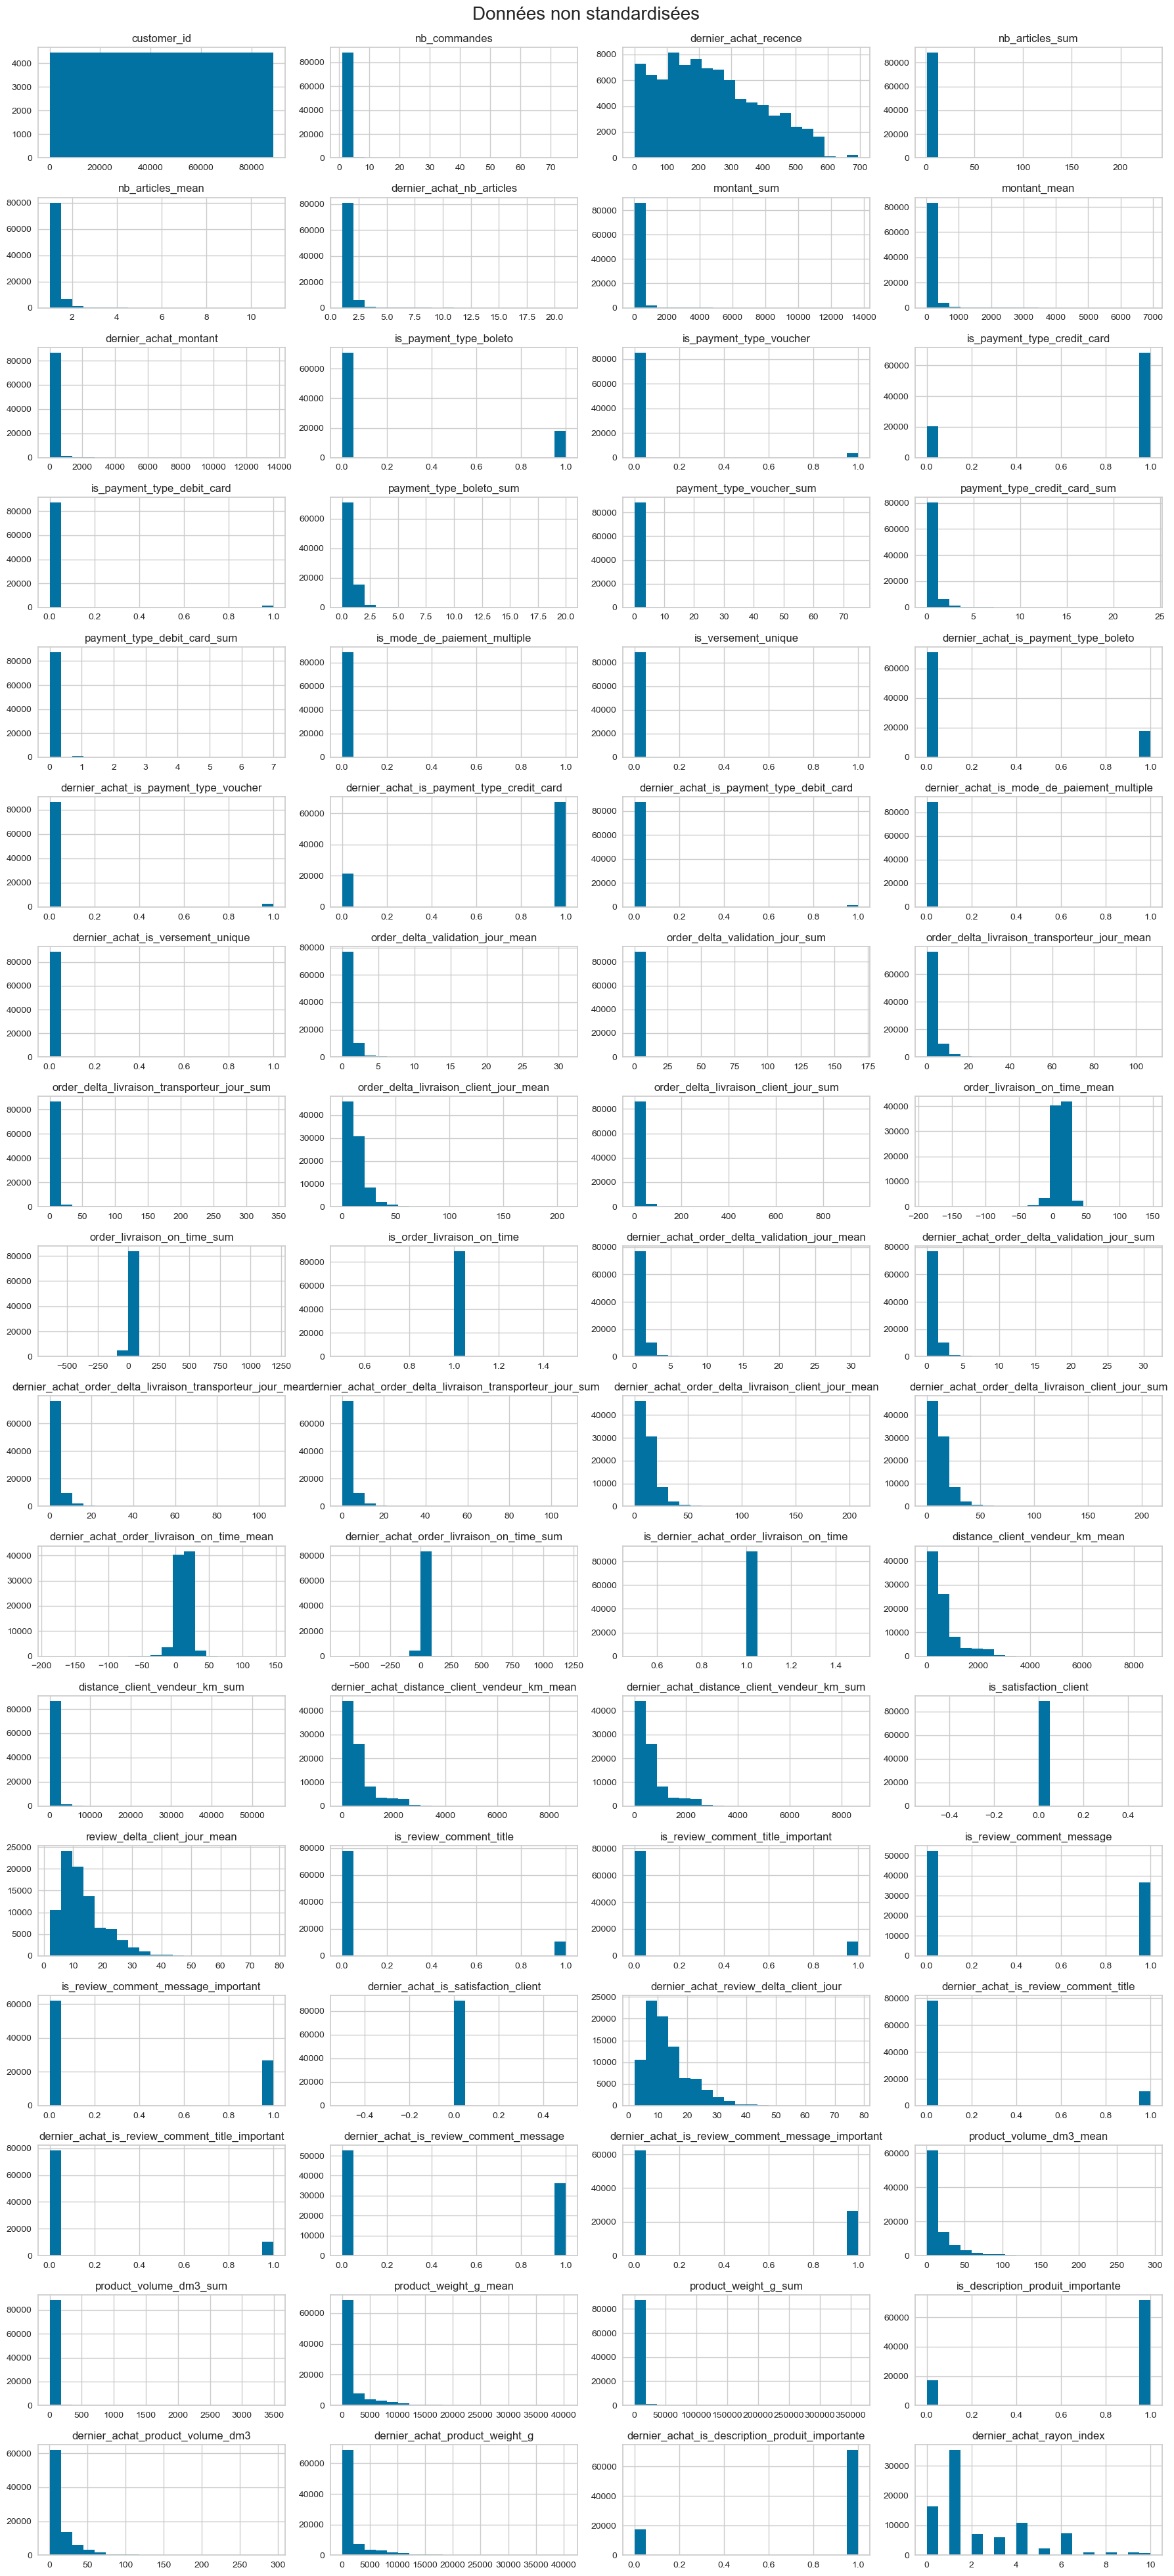

In [6]:
#############################################
#         Données non standardisées         #
#############################################
# Visualisation des données en un seul schéma pour savoir si nécessité de normaliser
fig = plt.figure(figsize = (18, 40))  # Width, height
index = 1

for col in X.columns:
    ax = fig.add_subplot(17, 4, index)   # lignes, colonnes
    X[col].hist(bins = 20)
    ax.set_title(col, fontsize = 12)
    index = index + 1
    
fig.suptitle('Données non standardisées\n\n', fontsize = 20)
fig.tight_layout() # pour éviter chevauchement titre et ligne suivante

In [ ]:
################################################
#           NORMALISATION DES DONNEES          #
################################################

In [7]:
# https://www.geeksforgeeks.org/how-to-standardize-data-in-a-pandas-dataframe/
# https://www.kaggle.com/code/lilyelizabethjohn/standardization-using-standardscaler
# https://stackoverflow.com/questions/40758562/can-anyone-explain-me-standardscaler
# https://stacklima.com/comment-mettre-a-l-echelle-les-colonnes-pandas-dataframe/

# Define standard scaler
scaler = StandardScaler()

# Transform data
X_norm = scaler.fit_transform(X)

# Maj type : numpy.ndarray --> panda dataframe
X_norm = pd.DataFrame(X_norm, columns = X.columns)

print ('X_norm =', X_norm.shape)

X_norm = (88771, 68)


In [8]:
# Vérification que la moyenne = 0 et l'écart type = 1
idx = ['mean', 'std']

#pd.DataFrame(X_norm).describe().round(2).loc[idx, :]
pd.DataFrame(X_norm).describe().round(2).loc[idx, :].transpose()  # transpose met les attributs en ligne pour + de lisibilité

mean  std
customer_id                                      -0.0  1.0
nb_commandes                                     -0.0  1.0
dernier_achat_recence                            -0.0  1.0
nb_articles_sum                                  -0.0  1.0
nb_articles_mean                                 -0.0  1.0
...                                               ...  ...
is_description_produit_importante                -0.0  1.0
dernier_achat_product_volume_dm3                 -0.0  1.0
dernier_achat_product_weight_g                   -0.0  1.0
dernier_achat_is_description_produit_importante  -0.0  1.0
dernier_achat_rayon_index                        -0.0  1.0

[68 rows x 2 columns]

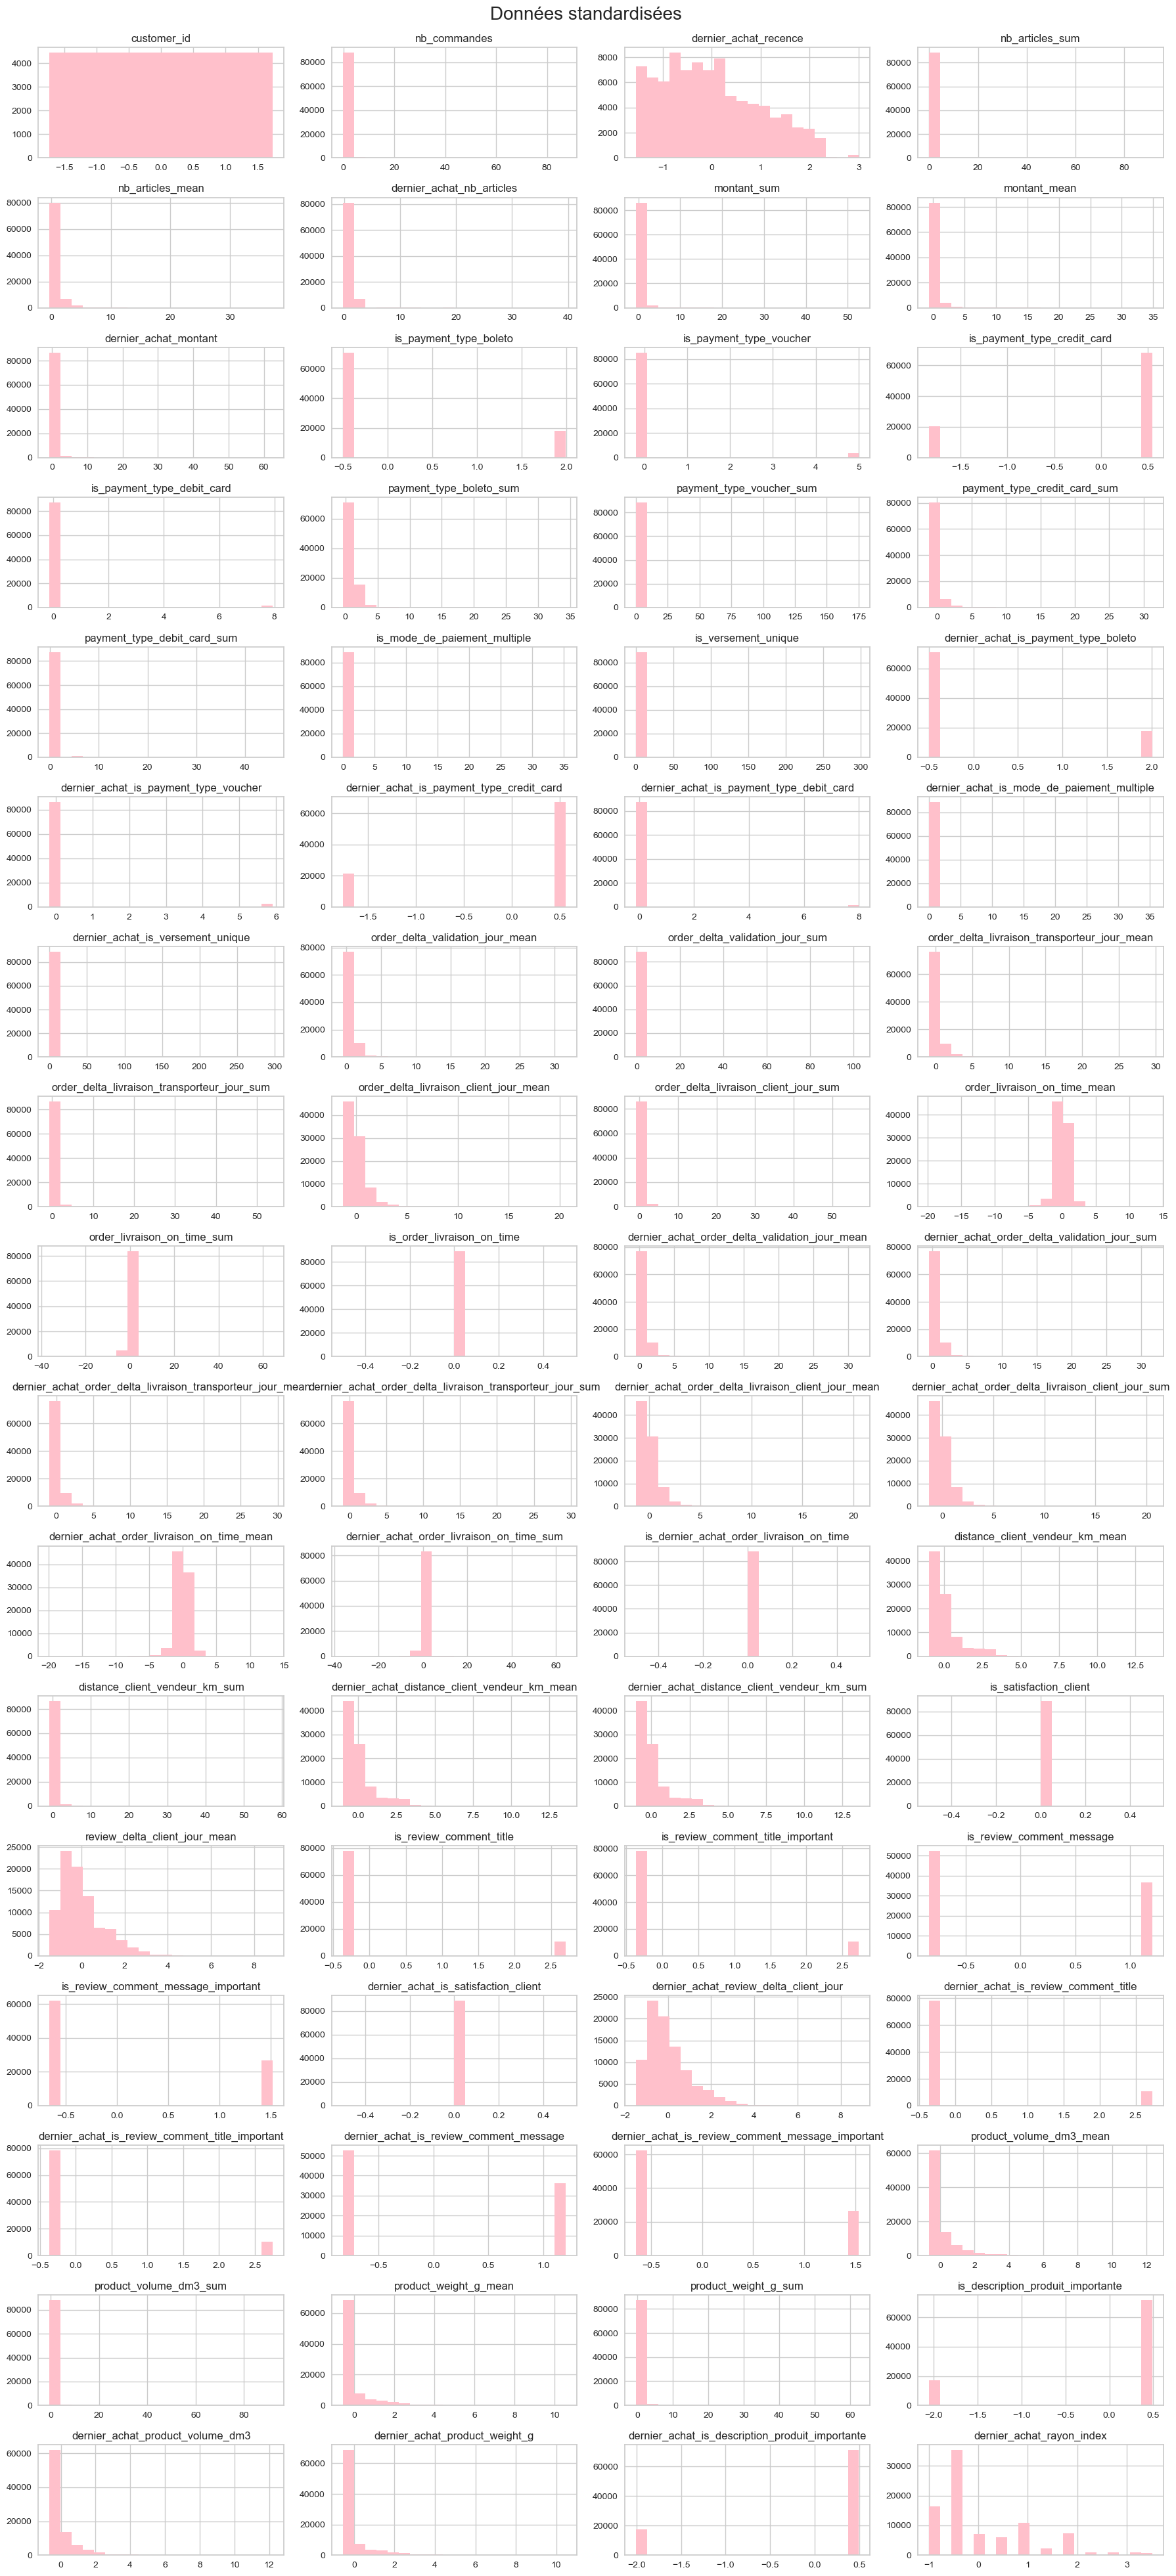

In [9]:
#############################################
#           Données normalisées             #
#############################################
# Visualisation des données en un seul schéma pour savoir si nécessité de standardiser
fig = plt.figure(figsize = (18, 40))  # Width, height
index = 1

for col in X_norm.columns:
    ax = fig.add_subplot(17, 4, index)   # lignes, colonnes
    X_norm[col].hist(bins = 20, color = 'pink')
    ax.set_title(col, fontsize = 12)
    index = index + 1
    
fig.suptitle('Données standardisées\n\n', fontsize = 20)
fig.tight_layout() # pour éviter chevauchement titre et ligne suivante

In [10]:
print('X_norm ---->', len(X_norm.columns), 'colonnes :\n', X_norm.columns)

X_norm ----> 68 colonnes :
 Index(['customer_id', 'nb_commandes', 'dernier_achat_recence',
       'nb_articles_sum', 'nb_articles_mean', 'dernier_achat_nb_articles',
       'montant_sum', 'montant_mean', 'dernier_achat_montant',
       'is_payment_type_boleto', 'is_payment_type_voucher',
       'is_payment_type_credit_card', 'is_payment_type_debit_card',
       'payment_type_boleto_sum', 'payment_type_voucher_sum',
       'payment_type_credit_card_sum', 'payment_type_debit_card_sum',
       'is_mode_de_paiement_multiple', 'is_versement_unique',
       'dernier_achat_is_payment_type_boleto',
       'dernier_achat_is_payment_type_voucher',
       'dernier_achat_is_payment_type_credit_card',
       'dernier_achat_is_payment_type_debit_card',
       'dernier_achat_is_mode_de_paiement_multiple',
       'dernier_achat_is_versement_unique', 'order_delta_validation_jour_mean',
       'order_delta_validation_jour_sum',
       'order_delta_livraison_transporteur_jour_mean',
       'order_delta_l

In [11]:
colonnes_cluster = []

# 1.2. DONNEES PAR VERTICALE / THEME

In [12]:
# Dictionnaire des verticales (thèmes)
dict_verticale = {}

# Chaque verticale a 6 dimensions : 
#    > 'sum'     : somme de la feature pour le client
#    > 'mean'    : moyenne de la feature pour le client
#    > 'bool'    : booléen de la feature
#    > 'DA_sum'  : idem 'sum' pour le dernier achat (DA)
#    > 'DA_mean' : idem 'mean' pour le dernier achat (DA)
#    > 'DA_bool' : idem 'bool' pour le dernier achat (DA)

In [13]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @                Recence (R)                   @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
dict_recence = {}

dict_recence['sum']      = {}
dict_recence['mean']     = {}
dict_recence['bool']     = {}
dict_recence['DA_sum']   = X_norm[['dernier_achat_recence']]  # nombre jours depuis le dernier achat
dict_recence['DA_mean']  = {}
dict_recence['DA_bool']  = {}
dict_recence['DA_categ'] = {}

dict_verticale['recence'] = dict_recence


# Traces
print('dict_recence :')
for cle, valeur in dict_recence.items():
    if (len(valeur) != 0):  # affichage des éléments renseignés
        print('\t', cle, ':', valeur.columns.tolist())

dict_recence :
	 DA_sum : ['dernier_achat_recence']


In [14]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @               Frequence (F)                  @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
dict_frequence = {}

dict_frequence['sum']      = X_norm[['nb_articles_sum']]  # nombre d’achat sur la période
dict_frequence['mean']     = X_norm[['nb_articles_mean']]
dict_frequence['bool']     = {}
dict_frequence['DA_sum']   = X_norm[['dernier_achat_nb_articles']]  # nombre d'articles depuis le dernier achat
dict_frequence['DA_mean']  = {}
dict_frequence['DA_bool']  = {}
dict_frequence['DA_categ'] = {}

dict_verticale['frequence'] = dict_frequence


# Traces
print('dict_frequence :')
for cle, valeur in dict_frequence.items():    
    if (len(valeur) != 0):  # affichage des éléments renseignés
        print('\t', cle, ':', valeur.columns.tolist())

dict_frequence :
	 sum : ['nb_articles_sum']
	 mean : ['nb_articles_mean']
	 DA_sum : ['dernier_achat_nb_articles']


In [15]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @               Monétaire (M)                  @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
dict_monetaire = {}

dict_monetaire['sum']      = X_norm[['montant_sum', # somme des ventes sur la période
                                     'payment_type_boleto_sum',
                                     'payment_type_voucher_sum',
                                     'payment_type_credit_card_sum',
                                     'payment_type_debit_card_sum']]
dict_monetaire['mean']     = X_norm[['montant_mean']]
dict_monetaire['bool']     = X_norm[['is_payment_type_boleto', 'is_payment_type_voucher', 'is_payment_type_credit_card',
                                     'is_payment_type_debit_card', 'is_mode_de_paiement_multiple', 'is_versement_unique']]
dict_monetaire['DA_sum']   = X_norm[['dernier_achat_montant']]
dict_monetaire['DA_mean']  = {}
dict_monetaire['DA_bool']  = X_norm[['dernier_achat_is_payment_type_boleto', 'dernier_achat_is_payment_type_voucher',
                                     'dernier_achat_is_payment_type_credit_card',
                                     'dernier_achat_is_payment_type_debit_card', 
                                     'dernier_achat_is_mode_de_paiement_multiple', 'dernier_achat_is_versement_unique']]
dict_monetaire['DA_categ'] = {}

dict_verticale['monetaire'] = dict_monetaire


# Traces
print('dict_monetaire :')
for cle, valeur in dict_monetaire.items():    
    if (len(valeur) != 0):  # affichage des éléments renseignés
        print('\t', cle, ':', valeur.columns.tolist())

dict_monetaire :
	 sum : ['montant_sum', 'payment_type_boleto_sum', 'payment_type_voucher_sum', 'payment_type_credit_card_sum', 'payment_type_debit_card_sum']
	 mean : ['montant_mean']
	 bool : ['is_payment_type_boleto', 'is_payment_type_voucher', 'is_payment_type_credit_card', 'is_payment_type_debit_card', 'is_mode_de_paiement_multiple', 'is_versement_unique']
	 DA_sum : ['dernier_achat_montant']
	 DA_bool : ['dernier_achat_is_payment_type_boleto', 'dernier_achat_is_payment_type_voucher', 'dernier_achat_is_payment_type_credit_card', 'dernier_achat_is_payment_type_debit_card', 'dernier_achat_is_mode_de_paiement_multiple', 'dernier_achat_is_versement_unique']


In [16]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @     Satisfaction et commentaires client (S)  @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
dict_satisfaction = {}

dict_satisfaction['sum']      = {}
dict_satisfaction['mean']     = X_norm[['review_delta_client_jour_mean']]
dict_satisfaction['bool']     = X_norm[['is_satisfaction_client', 'is_review_comment_title', 
                                        'is_review_comment_title_important', 'is_review_comment_message',
                                        'is_review_comment_message_important']]
dict_satisfaction['DA_sum']   = X_norm[['dernier_achat_review_delta_client_jour']]
dict_satisfaction['DA_mean']  = {}
dict_satisfaction['DA_bool']  = X_norm[['dernier_achat_is_satisfaction_client', 'dernier_achat_is_review_comment_title',
                                        'dernier_achat_is_review_comment_title_important',
                                        'dernier_achat_is_review_comment_message', 
                                        'dernier_achat_is_review_comment_message_important']]
dict_satisfaction['DA_categ'] = {}

dict_verticale['satisfaction'] = dict_satisfaction


# Traces
print('dict_satisfaction :')
for cle, valeur in dict_satisfaction.items():    
    if (len(valeur) != 0):  # affichage des éléments renseignés
        print('\t', cle, ':', valeur.columns.tolist())

dict_satisfaction :
	 mean : ['review_delta_client_jour_mean']
	 bool : ['is_satisfaction_client', 'is_review_comment_title', 'is_review_comment_title_important', 'is_review_comment_message', 'is_review_comment_message_important']
	 DA_sum : ['dernier_achat_review_delta_client_jour']
	 DA_bool : ['dernier_achat_is_satisfaction_client', 'dernier_achat_is_review_comment_title', 'dernier_achat_is_review_comment_title_important', 'dernier_achat_is_review_comment_message', 'dernier_achat_is_review_comment_message_important']


In [17]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @                 Livraison (L)                @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
dict_livraison = {}

dict_livraison['sum']      = X_norm[['order_delta_validation_jour_sum', 'order_delta_livraison_transporteur_jour_sum',
                                     'order_delta_livraison_client_jour_sum', 'order_livraison_on_time_sum']]
dict_livraison['mean']     = X_norm[['order_delta_validation_jour_mean', 'order_delta_livraison_transporteur_jour_mean',
                                     'order_delta_livraison_client_jour_mean', 'order_livraison_on_time_mean']]
dict_livraison['bool']     = X_norm[['is_order_livraison_on_time']]
dict_livraison['DA_sum']   = X_norm[['dernier_achat_order_delta_validation_jour_sum', 
                                     'dernier_achat_order_delta_livraison_transporteur_jour_sum',
                                     'dernier_achat_order_delta_livraison_client_jour_sum',
                                     'dernier_achat_order_livraison_on_time_sum']]
dict_livraison['DA_mean']  = X_norm[['dernier_achat_order_delta_validation_jour_mean',
                                     'dernier_achat_order_delta_livraison_transporteur_jour_mean',
                                     'dernier_achat_order_delta_livraison_client_jour_mean',
                                     'dernier_achat_order_livraison_on_time_mean']]
dict_livraison['DA_bool']  = X_norm[['is_dernier_achat_order_livraison_on_time']]
dict_livraison['DA_categ'] = {}

dict_verticale['livraison'] = dict_livraison


# Traces
print('dict_livraison :')
for cle, valeur in dict_livraison.items():    
    if (len(valeur) != 0):  # affichage des éléments renseignés
        print('\t', cle, ':', valeur.columns.tolist())

dict_livraison :
	 sum : ['order_delta_validation_jour_sum', 'order_delta_livraison_transporteur_jour_sum', 'order_delta_livraison_client_jour_sum', 'order_livraison_on_time_sum']
	 mean : ['order_delta_validation_jour_mean', 'order_delta_livraison_transporteur_jour_mean', 'order_delta_livraison_client_jour_mean', 'order_livraison_on_time_mean']
	 bool : ['is_order_livraison_on_time']
	 DA_sum : ['dernier_achat_order_delta_validation_jour_sum', 'dernier_achat_order_delta_livraison_transporteur_jour_sum', 'dernier_achat_order_delta_livraison_client_jour_sum', 'dernier_achat_order_livraison_on_time_sum']
	 DA_mean : ['dernier_achat_order_delta_validation_jour_mean', 'dernier_achat_order_delta_livraison_transporteur_jour_mean', 'dernier_achat_order_delta_livraison_client_jour_mean', 'dernier_achat_order_livraison_on_time_mean']
	 DA_bool : ['is_dernier_achat_order_livraison_on_time']


In [18]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @               Distance vendeur               @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
dict_distance_vendeur = {}

dict_distance_vendeur['sum']      = X_norm[['distance_client_vendeur_km_sum']]
dict_distance_vendeur['mean']     = X_norm[['distance_client_vendeur_km_mean']]
dict_distance_vendeur['bool']     = {}
dict_distance_vendeur['DA_sum']   = X_norm[['dernier_achat_distance_client_vendeur_km_sum']]
dict_distance_vendeur['DA_mean']  = X_norm[['dernier_achat_distance_client_vendeur_km_mean']]
dict_distance_vendeur['DA_bool']  = {}
dict_distance_vendeur['DA_categ'] = {}

dict_verticale['distance_vendeur'] = dict_distance_vendeur


# Traces
print('dict_distance_vendeur :')
for cle, valeur in dict_distance_vendeur.items():    
    if (len(valeur) != 0):  # affichage des éléments renseignés
        print('\t', cle, ':', valeur.columns.tolist())

dict_distance_vendeur :
	 sum : ['distance_client_vendeur_km_sum']
	 mean : ['distance_client_vendeur_km_mean']
	 DA_sum : ['dernier_achat_distance_client_vendeur_km_sum']
	 DA_mean : ['dernier_achat_distance_client_vendeur_km_mean']


In [19]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @ Produit (volume, poids, rayon, description)  @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
dict_produit = {}

dict_produit['sum']      = X_norm[['product_volume_dm3_sum', 'product_weight_g_sum']]
dict_produit['mean']     = X_norm[['product_volume_dm3_mean', 'product_weight_g_mean']]
dict_produit['bool']     = X_norm[['is_description_produit_importante']]
dict_produit['DA_sum']   = X_norm[['dernier_achat_product_volume_dm3', 'dernier_achat_product_weight_g']]
dict_produit['DA_mean']  = {}
dict_produit['DA_bool']  = X_norm[['dernier_achat_is_description_produit_importante']]
dict_produit['DA_categ'] = X_norm[['dernier_achat_rayon_index']]

dict_verticale['produit'] = dict_produit


# Traces
print('dict_produit :')
for cle, valeur in dict_produit.items():    
    if (len(valeur) != 0):  # affichage des éléments renseignés
        print('\t', cle, ':', valeur.columns.tolist())

dict_produit :
	 sum : ['product_volume_dm3_sum', 'product_weight_g_sum']
	 mean : ['product_volume_dm3_mean', 'product_weight_g_mean']
	 bool : ['is_description_produit_importante']
	 DA_sum : ['dernier_achat_product_volume_dm3', 'dernier_achat_product_weight_g']
	 DA_bool : ['dernier_achat_is_description_produit_importante']
	 DA_categ : ['dernier_achat_rayon_index']


In [20]:
dict_verticale.keys()

dict_keys(['recence', 'frequence', 'monetaire', 'satisfaction', 'livraison', 'distance_vendeur', 'produit'])

# 1.3. DONNEES DE DIMENSION REDUITE

In [ ]:
########################################
#               T-SNE                  #
########################################

In [21]:
# https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html
tsne = manifold.TSNE(n_components = 2, init = 'random') #  perplexity = 30.0 (default value)
X_norm_tsne = tsne.fit_transform(X_norm)
print('X_norm shape :\t\t', X_norm.shape, '\n',
      'X_norm_tsne shape :\t', X_norm_tsne.shape)

C:\Users\valdu\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


X_norm shape :		 (88771, 68) 
 X_norm_tsne shape :	 (88771, 2)


In [22]:
# Maj type : numpy.ndarray --> panda dataframe
X_norm_tsne = pd.DataFrame(X_norm_tsne, columns = ['TSNE_1', 'TSNE_2'])   # 2 colonnes

print ('X_norm_tsne =', X_norm_tsne.shape)

X_norm_tsne = (88771, 2)


# 1.4. CREATION SOUS-DATAFRAMES

In [ ]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sample.html
# Bp de points => pour + de lisibilité, on travaille sur un sous-ensemble 

In [ ]:
###########################################################
# VERTICALES : RECENCE (R), FREQUENCE (F), MONETAIRE (M)  #
###########################################################

In [23]:
# https://www.nextlytics.com/blog/machine-learning-in-customer-segmentation-with-rfm-analysis
# Récence (R) d'un client : jours depuis le dernier achat.
# Fréquence (F) des réservations/chiffre d'affaires d'un client : Nombre d'achats, par exemple, en 6 mois.
# Monétaire (M) - Le chiffre d'affaires total d'un client : Somme des ventes, par exemple, en 6 mois.

df_RFM_1 = X_norm[['dernier_achat_recence', # dict_recence['DA_sum']
                   'nb_articles_sum',       # dict_frequence['sum']
                   'montant_sum']]          # dict_monetaire['sum']

print('df_RFM_1 :', df_RFM_1.shape, '---->', len(df_RFM_1.columns), 'colonnes :\n', df_RFM_1.columns.tolist())


# Sous-ensemble, pour plus de lisibilité
df_RFM_1_sample = df_RFM_1.sample(frac = 0.2, replace = True, random_state = 1)  # ensemble = 20 % des points initiaux
print('\ndf_RFM_1_sample :', df_RFM_1_sample.shape)

df_RFM_1 : (88771, 3) ----> 3 colonnes :
 ['dernier_achat_recence', 'nb_articles_sum', 'montant_sum']

df_RFM_1_sample : (17754, 3)


In [24]:
df_RFM_2 = X_norm[['dernier_achat_recence',         # dict_recence['DA_sum']-----> OK
                   'dernier_achat_nb_articles',     # dict_frequence['DA_sum']
                   'montant_sum',                   # dict_monetaire['sum']------> OK
                   'is_mode_de_paiement_multiple']] # dict_monetaire['bool']

print('df_RFM_2 :', df_RFM_2.shape, '---->', len(df_RFM_2.columns), 'colonnes :\n', df_RFM_2.columns.tolist())


# Sous-ensemble, pour plus de lisibilité
df_RFM_2_sample = df_RFM_2.sample(frac = 0.2, replace = True, random_state = 1)  # ensemble = 20 % des points initiaux
print('\ndf_RFM_2_sample :', df_RFM_2_sample.shape)

df_RFM_2 : (88771, 4) ----> 4 colonnes :
 ['dernier_achat_recence', 'dernier_achat_nb_articles', 'montant_sum', 'is_mode_de_paiement_multiple']

df_RFM_2_sample : (17754, 4)


In [25]:
df_RFM_3 = X_norm[['dernier_achat_recence',        # dict_recence['DA_sum']-------> OK
                   'dernier_achat_nb_articles',    # dict_frequence['DA_sum']-----> OK
                   'nb_articles_mean',             # dict_frequence['mean']
                   'montant_sum',                  # dict_monetaire['sum']--------> OK
                   'is_mode_de_paiement_multiple', # dict_monetaire['bool']-------> OK
                   'dernier_achat_montant']]       # dict_monetaire['DA_sum'] 

print('df_RFM_3 :', df_RFM_3.shape, '---->', len(df_RFM_3.columns), 'colonnes :\n', df_RFM_3.columns.tolist())


# Sous-ensemble, pour plus de lisibilité
df_RFM_3_sample = df_RFM_3.sample(frac = 0.2, replace = True, random_state = 1)  # ensemble = 20 % des points initiaux
print('\ndf_RFM_3_sample :', df_RFM_3_sample.shape)

df_RFM_3 : (88771, 6) ----> 6 colonnes :
 ['dernier_achat_recence', 'dernier_achat_nb_articles', 'nb_articles_mean', 'montant_sum', 'is_mode_de_paiement_multiple', 'dernier_achat_montant']

df_RFM_3_sample : (17754, 6)


In [26]:
df_RFM_4 = X_norm[['dernier_achat_recence',                     # dict_recence['DA_sum']-------> OK
                   'dernier_achat_nb_articles',                 # dict_frequence['DA_sum']-----> OK
                   'montant_sum',                               # dict_monetaire['sum']--------> OK
                   'is_mode_de_paiement_multiple',              # dict_monetaire['bool']-------> OK
                   'dernier_achat_is_payment_type_debit_card']] # dict_monetaire['DA_bool']
print('df_RFM_4 :', df_RFM_4.shape, '---->', len(df_RFM_4.columns), 'colonnes :\n', df_RFM_4.columns.tolist())


# Sous-ensemble, pour plus de lisibilité
df_RFM_4_sample = df_RFM_4.sample(frac = 0.2, replace = True, random_state = 1)  # ensemble = 20 % des points initiaux
print('\ndf_RFM_4_sample :', df_RFM_4_sample.shape)

df_RFM_4 : (88771, 5) ----> 5 colonnes :
 ['dernier_achat_recence', 'dernier_achat_nb_articles', 'montant_sum', 'is_mode_de_paiement_multiple', 'dernier_achat_is_payment_type_debit_card']

df_RFM_4_sample : (17754, 5)


In [27]:
df_RFM_5 = X_norm[['dernier_achat_recence',       # dict_recence['DA_sum']-------> OK
                   'dernier_achat_nb_articles',   # dict_frequence['DA_sum']-----> OK
                   'montant_sum',                 # dict_monetaire['sum']--------> OK
                   'is_payment_type_debit_card',  # dict_monetaire['bool']-------> OK
                   'montant_mean']]               # dict_monetaire['mean'] 
print('df_RFM_5 :', df_RFM_5.shape, '---->', len(df_RFM_5.columns), 'colonnes :\n', df_RFM_5.columns.tolist())


# Sous-ensemble, pour plus de lisibilité
df_RFM_5_sample = df_RFM_5.sample(frac = 0.2, replace = True, random_state = 1)  # ensemble = 20 % des points initiaux
print('\ndf_RFM_5_sample :', df_RFM_5_sample.shape)

df_RFM_5 : (88771, 5) ----> 5 colonnes :
 ['dernier_achat_recence', 'dernier_achat_nb_articles', 'montant_sum', 'is_payment_type_debit_card', 'montant_mean']

df_RFM_5_sample : (17754, 5)


In [ ]:
############################################################################
# VERTICALES : RECENCE (R), FREQUENCE (F), MONETAIRE (M), SATISFACTION (S) #
############################################################################

In [28]:
df_RFMS_1 = X_norm[['dernier_achat_recence',          # dict_recence['DA_sum']-------> OK
                    'dernier_achat_nb_articles',      # dict_frequence['DA_sum']-----> OK
                    'montant_sum',                    # dict_monetaire['sum']--------> OK
                    'is_payment_type_debit_card',     # dict_monetaire['bool']-------> OK
                    'review_delta_client_jour_mean']] # dict_satisfaction['mean']----> OK
print('df_RFMS_1 :', df_RFMS_1.shape, '---->', len(df_RFMS_1.columns), 'colonnes :\n', df_RFMS_1.columns.tolist())


# Sous-ensemble, pour plus de lisibilité
df_RFMS_1_sample = df_RFMS_1.sample(frac = 0.2, replace = True, random_state = 1)  # ensemble = 20 % des points initiaux
print('\ndf_RFMS_1_sample :', df_RFMS_1_sample.shape)

df_RFMS_1 : (88771, 5) ----> 5 colonnes :
 ['dernier_achat_recence', 'dernier_achat_nb_articles', 'montant_sum', 'is_payment_type_debit_card', 'review_delta_client_jour_mean']

df_RFMS_1_sample : (17754, 5)


In [ ]:
###########################################################################################
# VERTICALES : RECENCE (R), FREQUENCE (F), MONETAIRE (M), SATISFACTION (S), LIVRAISON (L) #
###########################################################################################

In [29]:
df_RFMSL_1 = X_norm[['dernier_achat_recence',                                      # dict_recence['DA_sum']-------> OK
                     'dernier_achat_nb_articles',                                  # dict_frequence['DA_sum']-----> OK
                     'montant_sum',                                                # dict_monetaire['sum']--------> OK
                     'is_payment_type_debit_card',                                 # dict_monetaire['bool']-------> OK
                     'review_delta_client_jour_mean',                              # dict_satisfaction['mean']----> OK
                     'dernier_achat_order_delta_livraison_transporteur_jour_sum']] # dict_livraison['DA_sum']-----> OK
print('df_RFMSL_1 :', df_RFMSL_1.shape, '---->', len(df_RFMSL_1.columns), 'colonnes :\n', df_RFMSL_1.columns.tolist())


# Sous-ensemble, pour plus de lisibilité
df_RFMSL_1_sample = df_RFMSL_1.sample(frac = 0.2, replace = True, random_state = 1)  # ensemble = 20 % des points initiaux
print('\ndf_RFMSL_1_sample :', df_RFMSL_1_sample.shape)         

df_RFMSL_1 : (88771, 6) ----> 6 colonnes :
 ['dernier_achat_recence', 'dernier_achat_nb_articles', 'montant_sum', 'is_payment_type_debit_card', 'review_delta_client_jour_mean', 'dernier_achat_order_delta_livraison_transporteur_jour_sum']

df_RFMSL_1_sample : (17754, 6)


# 2. CLUSTERING ALGORITHME K-MEANS

In [ ]:
# https://realpython.com/k-means-clustering-python/
# https://www.w3schools.com/python/python_ml_k-means.asp
# https://www.data-transitionnumerique.com/k-means/ : iris
# https://cedric.cnam.fr/vertigo/Cours/ml/tpKmeans.html

# 2.1. METHODE DU COUDE / ELBOW

# 2.1.1. RECHERCHE NOMBRE DE CLUSTERS K OPTIMAL

In [30]:
# Hyperparamètres K-means
kmeans_kwargs_1 = {'init'        : 'k-means++',  # améliore les résultats par rapport à une initialisation aléatoire
                   'n_init'      : 10,
                   'max_iter'    : 300,
                   'random_state': 42}

In [31]:
# Dictionnaires pour valeurs elbow (clé = nom df)
dict_elbow_kl                  = {}
dict_elbow_kl_sample           = {}
dict_elbow_sse                 = {}
dict_elbow_sse_sample          = {}
dict_elbow_indice_coude        = {}
dict_elbow_indice_coude_sample = {}

In [32]:
# https://www.delftstack.com/fr/howto/matplotlib/how-to-save-plots-as-an-image-file-without-displaying-in-matplotlib/
#def kmeans_elbow_recherche_k_optimal(key_in, kmeans_kwargs_in, intervalle_k_in):
def kmeans_elbow_recherche_k_optimal(df_in, df_sample_in, key_in, kmeans_kwargs_in, intervalle_k_in, afficher_courbe_in):
    
    sse               = [] # A list holds the SSE values for each k
    sse_indice        = [] # indices
    # sample
    sse_sample        = [] # A list holds the SSE values for each k
    sse_indice_sample = [] # indices

    
    # colonnes
    colonnes = df_in.columns.tolist()
    print('key_in =', key_in, '\n', 
          '\t- ', len(colonnes), 'colonnes =', colonnes)    
    
    for k in intervalle_k_in:  
        kmeans = KMeans(n_clusters = k, **kmeans_kwargs_in)
        kmeans.fit(df_in)
        sse.append(kmeans.inertia_)
        sse_indice.append(k)
        
        # sample
        kmeans_sample = KMeans(n_clusters = k, **kmeans_kwargs_in)
        kmeans_sample.fit(df_sample_in)
        sse_sample.append(kmeans_sample.inertia_)
        sse_indice_sample.append(k)
       
    
    # Point du coude
    kl        = KneeLocator(intervalle_k_in, sse,        curve = 'convex', direction = 'decreasing')
    kl_sample = KneeLocator(intervalle_k_in, sse_sample, curve = 'convex', direction = 'decreasing')    
    print('\t- elbow (coude)\t\t=', kl.elbow, 'clusters')
    print('\t- elbow_sample (coude)\t=', kl_sample.elbow, 'clusters')    
    
    # Indice du point du coude dans la liste
    indice_coude        = sse_indice.index(kl.elbow)
    indice_coude_sample = sse_indice_sample.index(kl_sample.elbow)    
    
    # Courbe
    if (afficher_courbe_in):
        # Linestyle : https://www.delftstack.com/fr/howto/matplotlib/linestyles-in-matplotlib-python/
        fig = plt.figure(figsize = (7, 4))  # largeur, hauteur
    
        plt.plot(intervalle_k_in, sse, color = 'blue', marker = 'o', linestyle = ':', linewidth = 2, 
                 label = key_in)
        plt.plot(kl.elbow, sse[indice_coude], color = 'red', marker = 'o', markersize = 14)    # point du coude en rouge
    
        # sample
        plt.plot(intervalle_k_in, sse_sample, color = 'green', marker = 'o', linestyle = ':', linewidth = 2, 
                 label = key_in + '_sample')
        plt.plot(kl_sample.elbow, sse_sample[indice_coude], color = 'red', marker = 'o', markersize = 14)    # point du coude en rouge
    
        plt.legend(fontsize = 10)
    
        plt.title('METHODE DU COUDE / ELBOW - ' + str(key_in) + ' : SSE % clusters', fontsize = 14)
        plt.xlabel('Nombre de clusters', fontsize = 12)
        plt.ylabel('SSE', fontsize = 12)

#       # Sauvegarde de la figure dans un fichier (pour réduire le poids du notebook)
#       path_name = './'
#       file_name = 'méthode elbow ' + key_in +'.pdf'
#       plt.savefig(path_name + file_name, dpi = 'figure')
#       print('\nCourbe enregistrée dans fichier "' + file_name + '"')
#    
#       plt.close(fig)   # Pour ne pas afficher la figure en mode interactif
        plt.show()
        
    # Dictionnaires pour valeurs elbow (clé = nom df)
    dict_elbow_kl[key_in]                  = kl
    dict_elbow_kl_sample[key_in]           = kl_sample
    dict_elbow_sse[key_in]                 = sse
    dict_elbow_sse_sample[key_in]          = sse_sample
    dict_elbow_indice_coude[key_in]        = indice_coude
    dict_elbow_indice_coude_sample[key_in] = indice_coude_sample

In [33]:
##############################################################################
#   Graphique de synthèse des courbes précédentes en groupant par verticale  #
##############################################################################
def kmeans_elbow_recherche_k_optimal_synthese(intervalle_k_in, type_verticale_in, liste_key_in):

    # Courbe
    # Linestyle : https://www.delftstack.com/fr/howto/matplotlib/linestyles-in-matplotlib-python/
    # dict_keys(['-', '--', '-.', ':', 'None', ' ', ''])
    
    color = ['blue', 'fuchsia', 'lime', 'cyan', 'yellow', 'green', 'orange']
    indice_color = 0
    

    for key in liste_key_in:
        
        # Dictionnaires pour valeurs elbow (clé = nom df)
        kl                  = dict_elbow_kl[key]
        kl_sample           = dict_elbow_kl_sample[key]
        sse                 = dict_elbow_sse[key] 
        sse_sample          = dict_elbow_sse_sample[key] 
        indice_coude        = dict_elbow_indice_coude[key] 
        indice_coude_sample = dict_elbow_indice_coude_sample[key] 
    
        ###########################
        #         df_xxx          # 
        ###########################
        plt.plot(intervalle_k_in, sse, color = color[indice_color], marker = 'o', linestyle = '-', 
                 linewidth = 1, label = str(kl.elbow) + ' clusters ' + key)
        plt.plot(kl.elbow, sse[indice_coude], color = 'red', marker = 'o', 
                 markersize = 14) # point du coude en rouge
        
        ###########################
        #      df_xxx_sample      #
        ###########################
        plt.plot(intervalle_k_in, sse_sample, color = color[indice_color], marker = 'o', linestyle = ':', 
                 linewidth = 1, label = str(kl_sample.elbow) + ' clusters ' + key + '_sample')
        plt.plot(kl_sample.elbow, sse_sample[indice_coude_sample], color = 'red', marker = 'o', 
                 markersize = 14) # point du coude en rouge
    
        indice_color = indice_color + 1
    
    
    plt.legend(ncol = 2, fontsize = 9)  # légende sur 2 colonnes

    plt.title('METHODE DU COUDE / ELBOW - verticales ' + type_verticale_in + ' : SSE % clusters', fontsize = 15)
    plt.xlabel('Nombre de clusters', fontsize = 12)
    plt.ylabel('SSE', fontsize = 12)
    plt.show()

In [34]:
##################################
#   df_RFM_1 & df_RFM_1_sample   #
##################################
kmeans_elbow_recherche_k_optimal(df_in              = df_RFM_1,
                                 df_sample_in       = df_RFM_1_sample,
                                 key_in             = 'df_RFM_1',
                                 kmeans_kwargs_in   = kmeans_kwargs_1,
                                 intervalle_k_in    = range(2, 11),
                                 afficher_courbe_in = False)

key_in = df_RFM_1 
 	-  3 colonnes = ['dernier_achat_recence', 'nb_articles_sum', 'montant_sum']
	- elbow (coude)		= 5 clusters
	- elbow_sample (coude)	= 5 clusters


In [35]:
##################################
#   df_RFM_2 & df_RFM_2_sample   #
##################################
kmeans_elbow_recherche_k_optimal(df_in              = df_RFM_2,
                                 df_sample_in       = df_RFM_2_sample,
                                 key_in             = 'df_RFM_2',
                                 kmeans_kwargs_in   = kmeans_kwargs_1,
                                 intervalle_k_in    = range(2, 11),
                                 afficher_courbe_in = False)

key_in = df_RFM_2 
 	-  4 colonnes = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'montant_sum', 'is_mode_de_paiement_multiple']
	- elbow (coude)		= 5 clusters
	- elbow_sample (coude)	= 5 clusters


In [36]:
##################################
#   df_RFM_3 & df_RFM_3_sample   #
##################################
kmeans_elbow_recherche_k_optimal(df_in              = df_RFM_3,
                                 df_sample_in       = df_RFM_3_sample,
                                 key_in             = 'df_RFM_3',
                                 kmeans_kwargs_in   = kmeans_kwargs_1,
                                 intervalle_k_in    = range(2, 11),
                                 afficher_courbe_in = False)

key_in = df_RFM_3 
 	-  6 colonnes = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'nb_articles_mean', 'montant_sum', 'is_mode_de_paiement_multiple', 'dernier_achat_montant']
	- elbow (coude)		= 6 clusters
	- elbow_sample (coude)	= 5 clusters


In [37]:
##################################
#   df_RFM_4 & df_RFM_4_sample   #
##################################
kmeans_elbow_recherche_k_optimal(df_in              = df_RFM_4,
                                 df_sample_in       = df_RFM_4_sample,
                                 key_in             = 'df_RFM_4',
                                 kmeans_kwargs_in   = kmeans_kwargs_1,
                                 intervalle_k_in    = range(2, 11),
                                 afficher_courbe_in = False)

key_in = df_RFM_4 
 	-  5 colonnes = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'montant_sum', 'is_mode_de_paiement_multiple', 'dernier_achat_is_payment_type_debit_card']
	- elbow (coude)		= 6 clusters
	- elbow_sample (coude)	= 6 clusters


In [38]:
##################################
#   df_RFM_5 & df_RFM_5_sample   #
##################################
kmeans_elbow_recherche_k_optimal(df_in              = df_RFM_5,
                                 df_sample_in       = df_RFM_5_sample,
                                 key_in             = 'df_RFM_5',
                                 kmeans_kwargs_in   = kmeans_kwargs_1,
                                 intervalle_k_in    = range(2, 11),
                                 afficher_courbe_in = False)

key_in = df_RFM_5 
 	-  5 colonnes = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'montant_sum', 'is_payment_type_debit_card', 'montant_mean']
	- elbow (coude)		= 5 clusters
	- elbow_sample (coude)	= 5 clusters


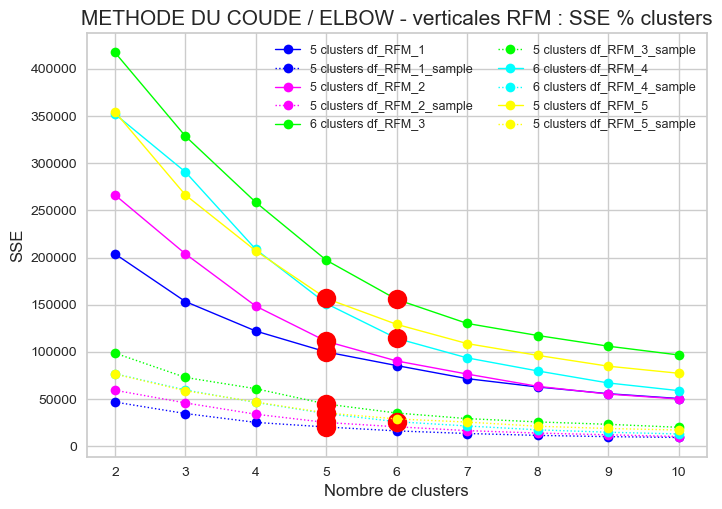

In [39]:
# Synthèse des courbes elbow pour la verticale RFM
kmeans_elbow_recherche_k_optimal_synthese(intervalle_k_in   = range(2, 11), 
                                          type_verticale_in = 'RFM', 
                                          liste_key_in      = ['df_RFM_1', 'df_RFM_2', 'df_RFM_3',
                                                               'df_RFM_4', 'df_RFM_5'])

In [40]:
##################################
#  df_RFMS_1 & df_RFMS_1_sample  #
##################################
kmeans_elbow_recherche_k_optimal(df_in              = df_RFMS_1,
                                 df_sample_in       = df_RFMS_1_sample,
                                 key_in             = 'df_RFMS_1',
                                 kmeans_kwargs_in   = kmeans_kwargs_1,
                                 intervalle_k_in    = range(2, 11),
                                 afficher_courbe_in = False)

key_in = df_RFMS_1 
 	-  5 colonnes = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'montant_sum', 'is_payment_type_debit_card', 'review_delta_client_jour_mean']
	- elbow (coude)		= 6 clusters
	- elbow_sample (coude)	= 6 clusters


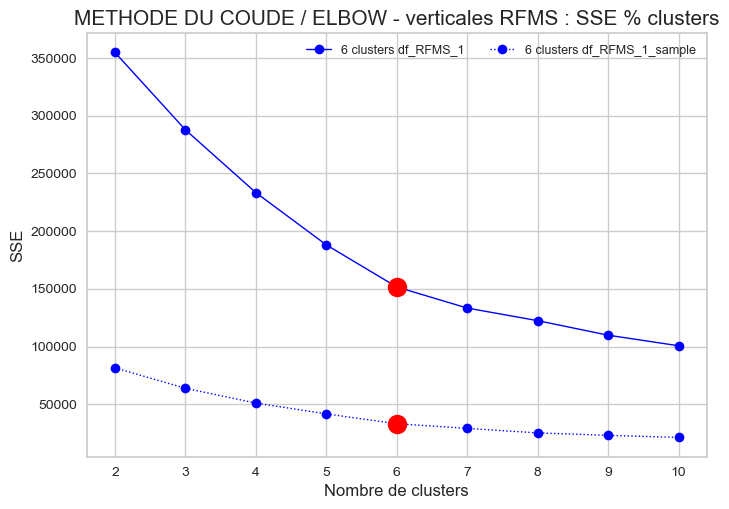

In [41]:
# Synthèse des courbes elbow pour la verticale RFMS
kmeans_elbow_recherche_k_optimal_synthese(intervalle_k_in   = range(2, 11), 
                                          type_verticale_in = 'RFMS', 
                                          liste_key_in      = ['df_RFMS_1'])

In [42]:
####################################
#  df_RFMSL_1 & df_RFMSL_1_sample  #
####################################
kmeans_elbow_recherche_k_optimal(df_in              = df_RFMSL_1,
                                 df_sample_in       = df_RFMSL_1_sample,
                                 key_in             = 'df_RFMSL_1',
                                 kmeans_kwargs_in   = kmeans_kwargs_1,
                                 intervalle_k_in    = range(2, 11),
                                 afficher_courbe_in = False)

key_in = df_RFMSL_1 
 	-  6 colonnes = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'montant_sum', 'is_payment_type_debit_card', 'review_delta_client_jour_mean', 'dernier_achat_order_delta_livraison_transporteur_jour_sum']
	- elbow (coude)		= 5 clusters
	- elbow_sample (coude)	= 6 clusters


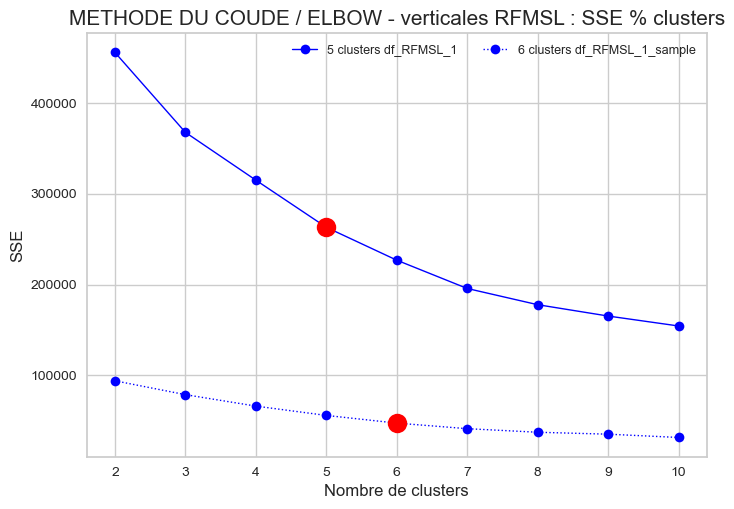

In [43]:
# Synthèse des courbes elbow pour la verticale RFMSL
kmeans_elbow_recherche_k_optimal_synthese(intervalle_k_in   = range(2, 11), 
                                          type_verticale_in = 'RFMSL', 
                                          liste_key_in      = ['df_RFMSL_1'])

# 2.1.2. K-MEANS AVEC K = 4 CLUSTERS

In [ ]:
# https://www.data-transitionnumerique.com/k-means/

In [44]:
# Calcul combinaisons i.e. nombre de subplots
#    | 1  2  3  4  5  6  7  8  9  10
#----|-----------------------------
# 1  |
# 2  | X
# 3  | X  X
# 4  | X  X  X
# 5  | X  X  X  X
# 6  | X  X  X  X  X
# 7  | X  X  X  X  X  X
# 8  | X  X  X  X  X  X  X
# 9  | X  X  X  X  X  X  X  X
# 10 | X  X  X  X  X  X  X  X  X

def calcul_nb_subplots (nb_col_in):
    
    if (nb_col_in == 2):
        nb_subplots = 1
    elif (nb_col_in == 3):
        nb_subplots = 3
    elif (nb_col_in == 4):
        nb_subplots = 6
    elif (nb_col_in == 5):
        nb_subplots = 10
    elif (nb_col_in == 6):
        nb_subplots = 15
    elif (nb_col_in == 7):
        nb_subplots = 21
    elif (nb_col_in == 8):
        nb_subplots = 28
    elif (nb_col_in == 9):
        nb_subplots = 36
    elif (nb_col_in == 10):
        nb_subplots = 45
    else:
        nb_subplots = 0
          
    return nb_subplots

In [45]:
################################################
# Recherche des clusters optimaux et affichage #
################################################
# https://www.data-transitionnumerique.com/k-means/
def kmeans_elbow_k_optimal(df_in,
                           key_in,                    # clé du dictionnaire
                           n_clusters_in,
                           kmeans_kwargs_in,
                           liste_colonnes_in = ''):   # liste de colonnes (si vide, on prend toutes celles du dictionnaire)

    # Couleurs : https://matplotlib.org/stable/gallery/color/named_colors.html
    colormap = np.array(['yellow', 'fuchsia', 'cornflowerblue', 'lime', 'green', 'red'])  # couleurs des clusters
    dict_nb_figure = {} # dictionnaire avec le nombre de figures dessinées par colonne
    num_ligne = 0
       
    # Initialisation suivant les paramètres d'entrée  
    if (liste_colonnes_in != ''):   # liste de colonnes (sous-ensemble du df)
        colonnes = liste_colonnes_in 
    else:  # on prend toutes les colonnes du df
        colonnes = df_in.columns.tolist()
    nb_col = len(colonnes)
    
    # Dictionnaire pour stocker le nombre de fois où la figure est tracée
    for c in colonnes:
        dict_nb_figure[c] = 0
    
    print('key_in =', key_in, '\n',
          '\t-', n_clusters_in, 'clusters\n',
          '\t-', nb_col, 'colonnes =', colonnes)


    #################################################
    #                 n clusters                    #
    #################################################
    cls = KMeans(n_clusters = n_clusters_in, **kmeans_kwargs_in)
    cls.fit(df_in)


    #################################################
    #             Graphique en 2D                   #
    #    (1 subplot = 1 ligne = 1 colonne du df)    #
    #################################################
    # Calcul combinaisons i.e. nombre de subplots
    nb_subplots = calcul_nb_subplots(nb_col_in = nb_col)
    print('\t- nb_subplots =', nb_subplots, '\n')
    
    # adjusting heights of individual subplots :
    # https://stackoverflow.com/questions/3330137/adjusting-heights-of-individual-subplots-in-matplotlib-in-python
    fig, axs = plt.subplots(nb_subplots, figsize = (10, 1.5 * nb_subplots))

    # On n'affiche q
    for col_1 in colonnes:
        for col_2 in colonnes:
            if (col_1 != col_2):
                if ((dict_nb_figure[col_1] < nb_col - 1) & (dict_nb_figure[col_2] < nb_col - 1)):
                    dict_nb_figure[col_1] = dict_nb_figure[col_1] + 1
                    dict_nb_figure[col_2] = dict_nb_figure[col_2] + 1
                    
                    axs[num_ligne].scatter(df_in[col_1], df_in[col_2], c = colormap[cls.labels_])
                    # le centre du cluster est mis pour l'instant en croix grise pour mieux voir les clusters.
                    axs[num_ligne].scatter(cls.cluster_centers_[:, 0], cls.cluster_centers_[:, 1], 
                                           s = 60, marker = '1', c = 'grey')
                    axs[num_ligne].set_xlabel(col_1, fontsize = 8.5)
                    axs[num_ligne].set_ylabel(col_2, fontsize = 8.5)
                    
                    num_ligne = num_ligne + 1
                    print('num_ligne =', num_ligne, ': col_1 =', col_1, ', col_2 =', col_2, ) 

    print('\ndict_nb_figure =', dict_nb_figure)
    
    plt.suptitle('KMEANS (elbow) - ' + str(n_clusters_in) + ' clusters - ' + str(key_in), fontsize = 15)

    fig.tight_layout()
    fig.set_size_inches(5, 2 * nb_subplots)  # longueur, hauteur = 2 pour chaque subplot
    plt.show()
    
    if (liste_colonnes_in != ''):
        print('\n', '@' * 120, '\n')  # Séparation des graphiques
    else:
        print('\n')

In [46]:
#########################################
#            PROJECTION 3D              #
#########################################
def kmeans_elbow_k_optimal_3D(df_in,
                              key_in,                    # clé du dictionnaire
                              n_clusters_in,
                              kmeans_kwargs_in,
                              liste_colonnes_in = ''):   # liste de 3 colonnes

    colormap = np.array(['yellow', 'fuchsia', 'cornflowerblue', 'lime', 'green', 'red'])  # couleurs des clusters

    cls = KMeans(n_clusters = n_clusters_in, **kmeans_kwargs_in)
    cls.fit(df_in)

    # define data
    x = df_in[liste_colonnes_in[0]]
    y = df_in[liste_colonnes_in[1]]
    z = df_in[liste_colonnes_in[2]]
    
    # create figure
    fig = plt.figure(figsize = (6, 6))
    ax = plt.axes(projection = '3d')
 
    # create plot
    ax.scatter3D(x, y, z, c = colormap[cls.labels_])
    ax.set_xlabel(liste_colonnes_in[0], fontsize = 8.5)
    ax.set_ylabel(liste_colonnes_in[1], fontsize = 8.5)
    ax.set_zlabel(liste_colonnes_in[2], fontsize = 8.5)
    
    plt.title('Projection 3D - K-Means (méthode elbow)\n' 
              + key_in + ' - ' + str(n_clusters_in) + ' clusters', fontsize = 14)
    # show plot
    plt.show()

# 2.1.2.1. VERTICALE RFM (RECENCE - FREQUENCE - MONETAIRE)

In [ ]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @         df_RFM_1           @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

key_in = df_RFM_1 
 	- 4 clusters
 	- 3 colonnes = ['dernier_achat_recence', 'nb_articles_sum', 'montant_sum']
	- nb_subplots = 3 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = nb_articles_sum
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = montant_sum
num_ligne = 3 : col_1 = nb_articles_sum , col_2 = montant_sum

dict_nb_figure = {'dernier_achat_recence': 2, 'nb_articles_sum': 2, 'montant_sum': 2}


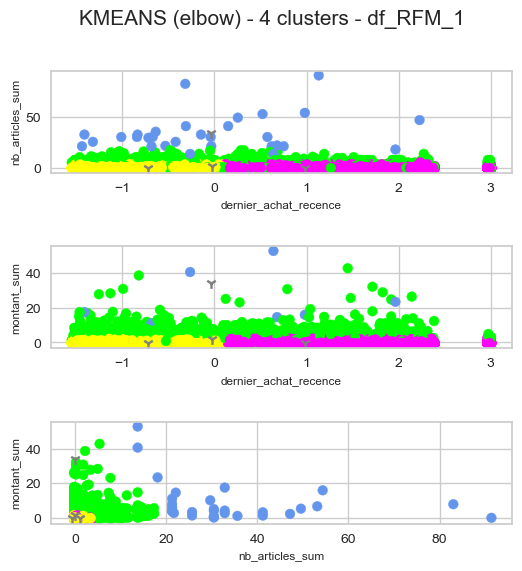

In [47]:
kmeans_elbow_k_optimal(df_in            = df_RFM_1,
                       key_in           = 'df_RFM_1',
                       n_clusters_in    = 4,                 # 4 clusters
                       kmeans_kwargs_in = kmeans_kwargs_1)

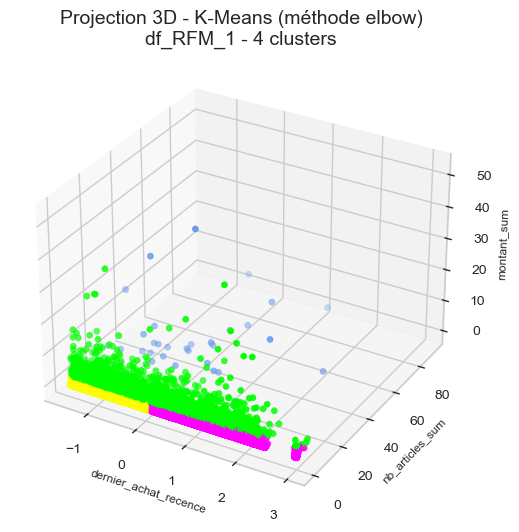

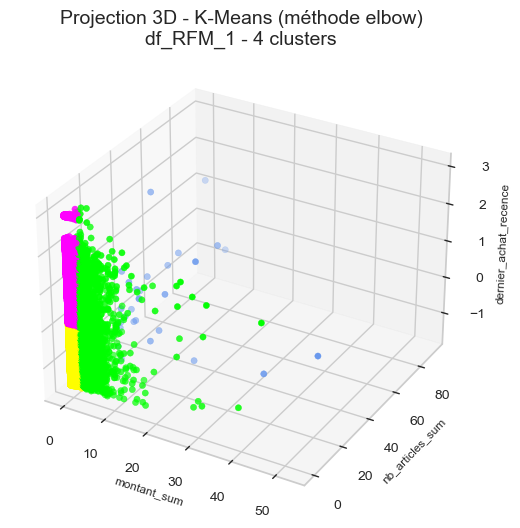

In [48]:
# Projection 3D des colonnes avec les meilleurs clusters
liste_1 = ['dernier_achat_recence', 'nb_articles_sum', 'montant_sum']
liste_2 = ['montant_sum', 'nb_articles_sum', 'dernier_achat_recence']

for liste in [liste_1, liste_2]:    
    kmeans_elbow_k_optimal_3D(df_in             = df_RFM_1,
                              key_in            = 'df_RFM_1',
                              n_clusters_in     = 4,                # 4 clusters
                              kmeans_kwargs_in  = kmeans_kwargs_1,
                              liste_colonnes_in = liste)
    print('\n')

In [49]:
# Analyse courbes 2D et 3D pour la création de clusters : 
# |-------------------------|---------------------------------|-------------------------------------------------------|
# |    Colonnes utiles      |       Colonnes inutiles         | Commentaire                                           |
# |-------------------------|---------------------------------|-------------------------------------------------------|
# | dernier_achat_recence   |                                 | 2 clusters créés (sur toute la longueur de l'axe).    |
# | montant_sum             |                                 | cluster créé (forme compacte)                         |
# |                         | nb_articles_sum                 | peu d'impact (pas de cluster créé)                    |
# |-------------------------|---------------------------------|-------------------------------------------------------|


# Maj liste colonnes_cluster :
colonnes_cluster.append('dernier_achat_recence')
colonnes_cluster.append('montant_sum')
print('colonnes_cluster df_RFM_1 :', colonnes_cluster)

colonnes_cluster df_RFM_1 : ['dernier_achat_recence', 'montant_sum']


In [ ]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @         df_RFM_2           @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

key_in = df_RFM_2 
 	- 4 clusters
 	- 4 colonnes = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'montant_sum', 'is_mode_de_paiement_multiple']
	- nb_subplots = 6 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = dernier_achat_nb_articles
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = montant_sum
num_ligne = 3 : col_1 = dernier_achat_recence , col_2 = is_mode_de_paiement_multiple
num_ligne = 4 : col_1 = dernier_achat_nb_articles , col_2 = montant_sum
num_ligne = 5 : col_1 = dernier_achat_nb_articles , col_2 = is_mode_de_paiement_multiple
num_ligne = 6 : col_1 = montant_sum , col_2 = is_mode_de_paiement_multiple

dict_nb_figure = {'dernier_achat_recence': 3, 'dernier_achat_nb_articles': 3, 'montant_sum': 3, 'is_mode_de_paiement_multiple': 3}


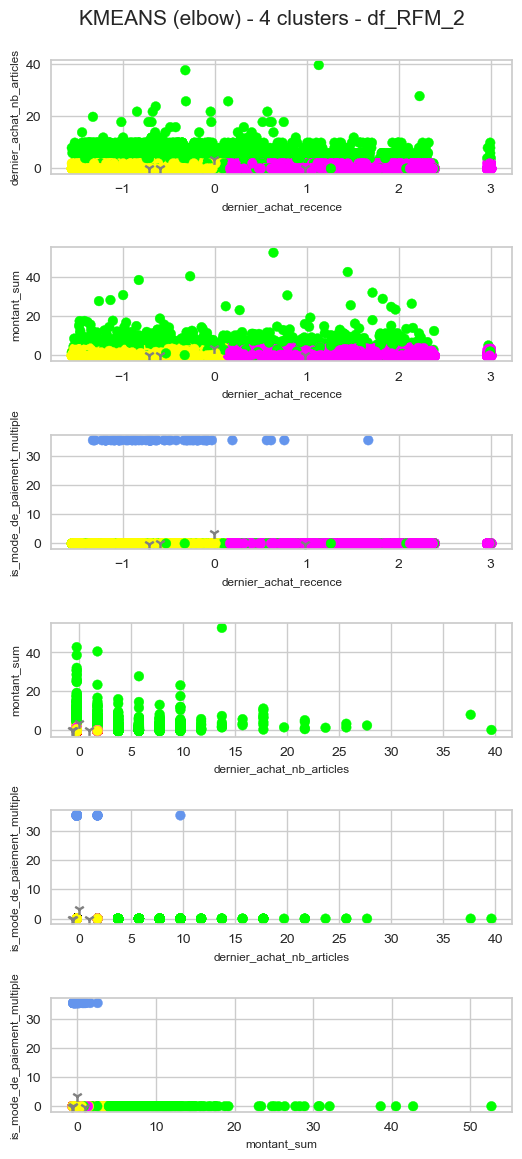

In [51]:
kmeans_elbow_k_optimal(df_in            = df_RFM_2,
                       key_in           = 'df_RFM_2',
                       n_clusters_in    = 4,                 # 4 clusters
                       kmeans_kwargs_in = kmeans_kwargs_1)   

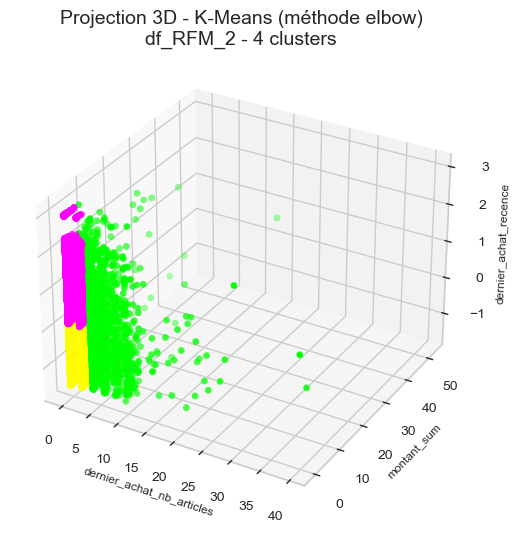

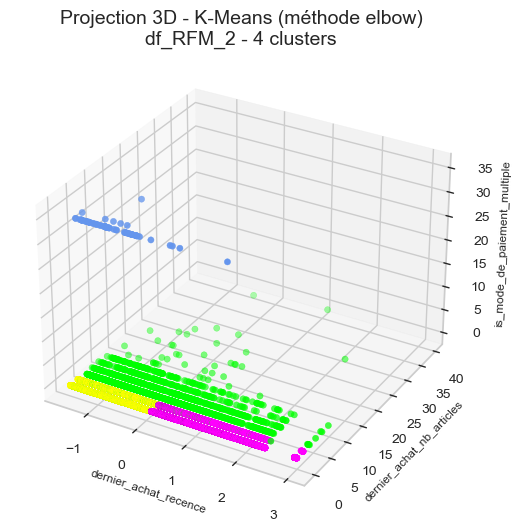

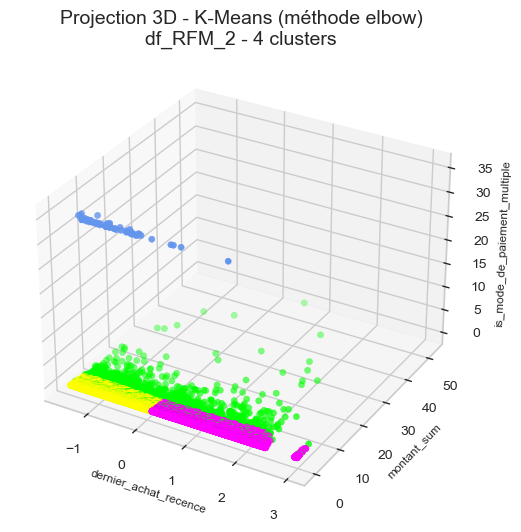

In [52]:
# Projection 3D des colonnes avec les meilleurs clusters

# Anciennes features : dernier_achat_recence, montant_sum
# Nouvelles features : dernier_achat_nb_articles, is_mode_de_paiement_multiple

liste_1 = ['dernier_achat_nb_articles', 'montant_sum', 'dernier_achat_recence']
liste_2 = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'is_mode_de_paiement_multiple']
liste_3 = ['dernier_achat_recence', 'montant_sum', 'is_mode_de_paiement_multiple']

for liste in [liste_1, liste_2, liste_3]:
    kmeans_elbow_k_optimal_3D(df_in             = df_RFM_2,
                              key_in            = 'df_RFM_2',
                              n_clusters_in     = 4,                 # 4 clusters
                              kmeans_kwargs_in  = kmeans_kwargs_1,
                              liste_colonnes_in = liste)
    print('\n')

In [53]:
# Analyse courbes 2D et 3D pour la création de clusters : 
# |------------------------------|---------------------------------|----------------------------------------------------|
# |    Colonnes utiles           |       Colonnes inutiles         | Commentaire                                        |
# |------------------------------|---------------------------------|----------------------------------------------------|
# | dernier_achat_recence        |                                 | 2 clusters créés (sur toute la longueur de l'axe). |
# | montant_sum                  |                                 | cluster créé (forme compacte)                      |
# |                              |                                 |                                                    |
# |.......   Colonnes ajoutées dans le dataframe : ................|....................................................|
# | dernier_achat_nb_articles    |                                 | cluster créé (forme compacte).                     |
# | is_mode_de_paiement_multiple |                                 | création d'un petit cluster                        |
# |------------------------------|---------------------------------|----------------------------------------------------|


# Maj liste colonnes_cluster :
colonnes_cluster.append('dernier_achat_nb_articles')
colonnes_cluster.append('is_mode_de_paiement_multiple')
print('colonnes_cluster df_RFM_2 :', colonnes_cluster)

colonnes_cluster df_RFM_2 : ['dernier_achat_recence', 'montant_sum', 'dernier_achat_nb_articles', 'is_mode_de_paiement_multiple']


In [ ]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @         df_RFM_3           @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [12]:
kmeans_elbow_k_optimal(df_in            = df_RFM_3,
                       key_in           = 'df_RFM_3',
                       n_clusters_in    = 4,                 # 4 clusters
                       kmeans_kwargs_in = kmeans_kwargs_1)

# PERTE DES CLUSTERS INITIAUX


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Traces & graphiques supprimés.

In [19]:
# Perte de clusters :
# df_RFM_3 perd les clusters trouvés dans df_RFM_2. Comparaison avec des features communes entre les deux.
liste_colonnes = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'is_mode_de_paiement_multiple']

kmeans_elbow_k_optimal(df_in            = df_RFM_2,
                       key_in           = 'df_RFM_2',
                       n_clusters_in    = 4,                 # 4 clusters
                       kmeans_kwargs_in = kmeans_kwargs_1,
                       liste_colonnes_in = liste_colonnes)

kmeans_elbow_k_optimal(df_in            = df_RFM_3,
                       key_in           = 'df_RFM_3',
                       n_clusters_in    = 4,                 # 4 clusters
                       kmeans_kwargs_in = kmeans_kwargs_1,
                       liste_colonnes_in = liste_colonnes)


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Traces & graphiques supprimés.

In [18]:
# Projection 3D des colonnes avec les meilleurs clusters

# Anciennes features : dernier_achat_recence, dernier_achat_nb_articles, 
#                      montant_sum, is_mode_de_paiement_multiple
# Nouvelles features : nb_articles_mean, dernier_achat_montant

liste_1 = ['nb_articles_mean', 'dernier_achat_nb_articles', 'dernier_achat_recence']
liste_2 = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'dernier_achat_montant']
liste_3 = ['montant_sum', 'is_mode_de_paiement_multiple', 'nb_articles_mean']
liste_4 = ['montant_sum', 'is_mode_de_paiement_multiple', 'dernier_achat_montant']

for liste in [liste_1, liste_2, liste_3, liste_4]:
    kmeans_elbow_k_optimal_3D(df_in             = df_RFM_3,
                              key_in            = 'df_RFM_3',
                              n_clusters_in     = 4,                 # 4 clusters
                              kmeans_kwargs_in  = kmeans_kwargs_1,
                              liste_colonnes_in = liste)
    print('\n')
    

# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Traces & graphiques supprimés.    

In [57]:
# Analyse courbes 2D et 3D pour la création de clusters : 
# |------------------------------|---------------------------------|----------------------------------------------------|
# |    Colonnes utiles           |       Colonnes inutiles         | Commentaire                                        |
# |------------------------------|---------------------------------|----------------------------------------------------|
# | dernier_achat_recence        |                                 | 2 clusters créés (sur toute la longueur de l'axe). |
# | montant_sum                  |                                 | cluster créé (forme compacte)                      |
# | dernier_achat_nb_articles    |                                 | cluster créé (forme compacte).                     |
# | is_mode_de_paiement_multiple |                                 | création d'un petit cluster                        |
# |                              |                                 |                                                    |
# |.......   Colonnes ajoutées dans le dataframe : ................|....................................................|
# |                              | nb_articles_mean                | pas de cluster, données clairsemées,               |
# |                              |                                 | brouillage des autres clusters.                    |
# |                              | dernier_achat_montant           | pas de cluster.                                    |
# |                              |                                 | brouillage des autres clusters.                    |
# |------------------------------|---------------------------------|----------------------------------------------------|


# Maj liste colonnes_cluster :
print('colonnes_cluster df_RFM_3 :', colonnes_cluster)

colonnes_cluster df_RFM_3 : ['dernier_achat_recence', 'montant_sum', 'dernier_achat_nb_articles', 'is_mode_de_paiement_multiple']


In [ ]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @         df_RFM_4           @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [11]:
kmeans_elbow_k_optimal(df_in            = df_RFM_4,
                       key_in           = 'df_RFM_4',
                       n_clusters_in    = 4,                 # 4 clusters
                       kmeans_kwargs_in = kmeans_kwargs_1)

# PERTE DES CLUSTERS INITIAUX


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Traces & graphiques supprimés.

In [59]:
# Analyse courbes 2D pour la création de clusters : 
# |------------------------------|---------------------------------|----------------------------------------------------|
# |    Colonnes utiles           |       Colonnes inutiles         | Commentaire                                        |
# |------------------------------|---------------------------------|----------------------------------------------------|
# | dernier_achat_recence        |                                 | 2 clusters créés (sur toute la longueur de l'axe). |
# | montant_sum                  |                                 | cluster créé (forme compacte)                      |
# | dernier_achat_nb_articles    |                                 | cluster créé (forme compacte).                     |
# | is_mode_de_paiement_multiple |                                 | création d'un petit cluster                        |
# |                              |                                 |                                                    |
# |.......   Colonnes ajoutées dans le dataframe : ................|....................................................|
# |                              |   dernier_achat_is_payment_...  | brouillage des autres clusters.                    |
# |                              |  ...type_debit_card             |                                                    |
# |------------------------------|---------------------------------|----------------------------------------------------|


# Maj liste colonnes_cluster :
print('colonnes_cluster df_RFM_4 :', colonnes_cluster)

colonnes_cluster df_RFM_4 : ['dernier_achat_recence', 'montant_sum', 'dernier_achat_nb_articles', 'is_mode_de_paiement_multiple']


In [ ]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @    df_RFM_monetaire_sum    @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Boucle sur les colonnes dict_monetaire['sum'] restants (dont 'montant_sum').

------------------------------ montant_sum ------------------------------
key_in = df_RFM_monetaire_sum 
 	- 4 clusters
 	- 3 colonnes = ['dernier_achat_recence', 'montant_sum', 'is_mode_de_paiement_multiple']
	- nb_subplots = 3 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = montant_sum
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = is_mode_de_paiement_multiple
num_ligne = 3 : col_1 = montant_sum , col_2 = is_mode_de_paiement_multiple

dict_nb_figure = {'dernier_achat_recence': 2, 'montant_sum': 2, 'is_mode_de_paiement_multiple': 2}


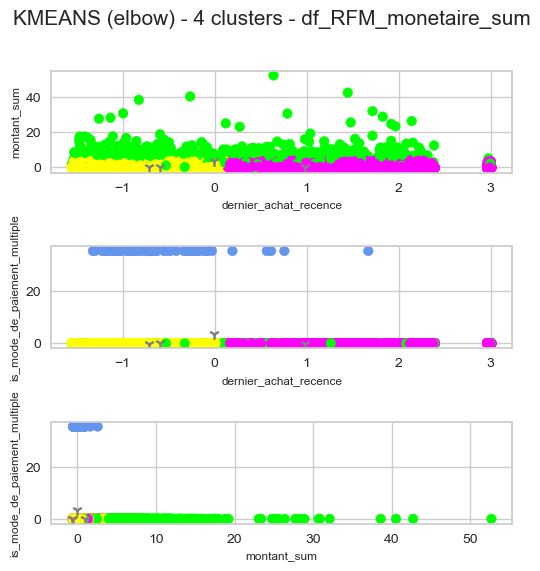


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

------------------------------ payment_type_boleto_sum ------------------------------
key_in = df_RFM_monetaire_sum 
 	- 4 clusters
 	- 3 colonnes = ['dernier_achat_recence', 'payment_type_boleto_sum', 'is_mode_de_paiement_multiple']
	- nb_subplots = 3 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = payment_type_boleto_sum
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = is_mode_de_paiement_multiple
num_ligne = 3 : col_1 = payment_type_boleto_sum , col_2 = is_mode_de_paiement_multiple

dict_nb_figure = {'dernier_achat_recence': 2, 'payment_type_boleto_sum': 2, 'is_mode_de_paiement_multiple': 2}


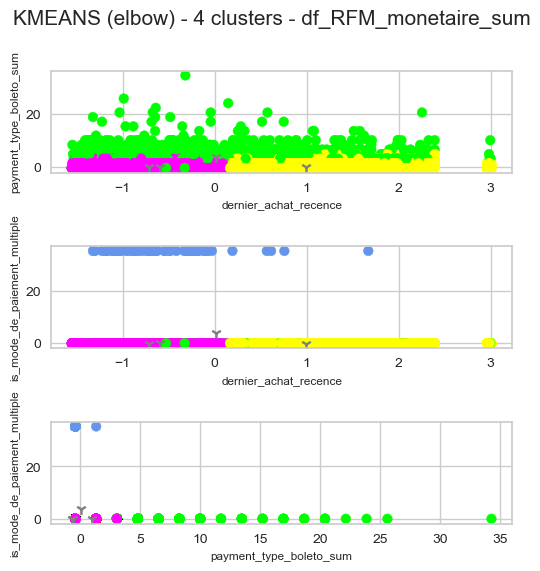


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

------------------------------ payment_type_voucher_sum ------------------------------
key_in = df_RFM_monetaire_sum 
 	- 4 clusters
 	- 3 colonnes = ['dernier_achat_recence', 'payment_type_voucher_sum', 'is_mode_de_paiement_multiple']
	- nb_subplots = 3 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = payment_type_voucher_sum
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = is_mode_de_paiement_multiple
num_ligne = 3 : col_1 = payment_type_voucher_sum , col_2 = is_mode_de_paiement_multiple

dict_nb_figure = {'dernier_achat_recence': 2, 'payment_type_voucher_sum': 2, 'is_mode_de_paiement_multiple': 2}


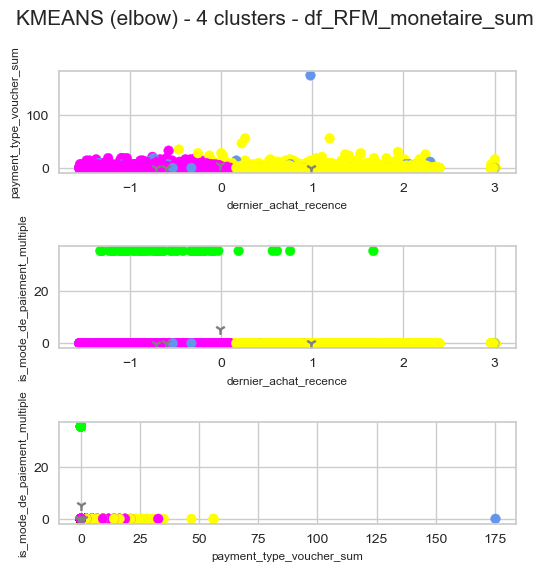


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

------------------------------ payment_type_credit_card_sum ------------------------------
key_in = df_RFM_monetaire_sum 
 	- 4 clusters
 	- 3 colonnes = ['dernier_achat_recence', 'payment_type_credit_card_sum', 'is_mode_de_paiement_multiple']
	- nb_subplots = 3 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = payment_type_credit_card_sum
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = is_mode_de_paiement_multiple
num_ligne = 3 : col_1 = payment_type_credit_card_sum , col_2 = is_mode_de_paiement_multiple

dict_nb_figure = {'dernier_achat_recence': 2, 'payment_type_credit_card_sum': 2, 'is_mode_de_paiement_multiple': 2}


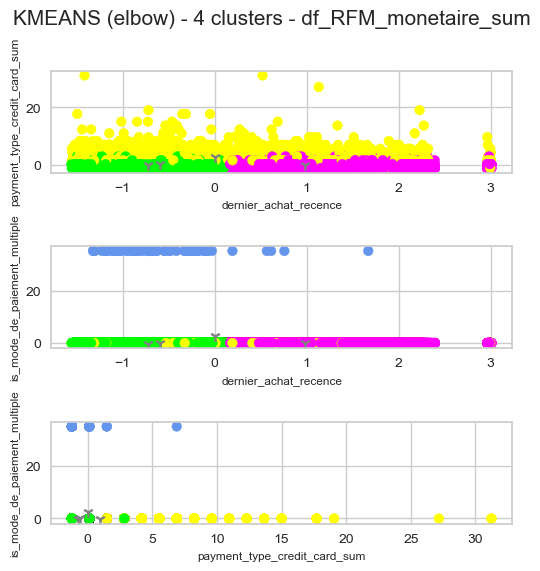


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

------------------------------ payment_type_debit_card_sum ------------------------------
key_in = df_RFM_monetaire_sum 
 	- 4 clusters
 	- 3 colonnes = ['dernier_achat_recence', 'payment_type_debit_card_sum', 'is_mode_de_paiement_multiple']
	- nb_subplots = 3 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = payment_type_debit_card_sum
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = is_mode_de_paiement_multiple
num_ligne = 3 : col_1 = payment_type_debit_card_sum , col_2 = is_mode_de_paiement_multiple

dict_nb_figure = {'dernier_achat_recence': 2, 'payment_type_debit_card_sum': 2, 'is_mode_de_paiement_multiple': 2}


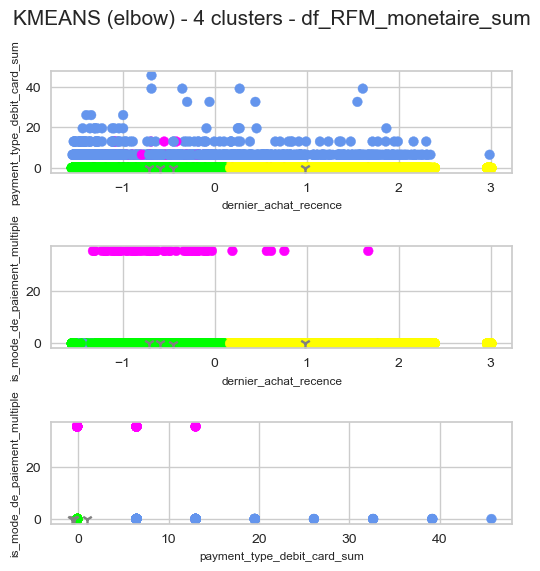


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 



In [60]:
for col_sum in ['montant_sum', 'payment_type_boleto_sum', 'payment_type_voucher_sum', 'payment_type_credit_card_sum',
                'payment_type_debit_card_sum']:
    
    print('-' * 30, col_sum, '-' * 30)
    df_RFM_monetaire_sum = X_norm[['dernier_achat_recence',          # dict_recence['DA_sum']-------> OK
                                   'dernier_achat_nb_articles',      # dict_frequence['DA_sum']-----> OK
                                   col_sum,                          # dict_monetaire['sum']
                                   'is_mode_de_paiement_multiple']]  # dict_monetaire['bool']-------> OK
    
    liste_colonnes = ['dernier_achat_recence', col_sum, 'is_mode_de_paiement_multiple']
    
    kmeans_elbow_k_optimal(df_in             = df_RFM_monetaire_sum,
                           key_in            = 'df_RFM_monetaire_sum',
                           n_clusters_in     = 4,                 # 4 clusters
                           kmeans_kwargs_in  = kmeans_kwargs_1,
                           liste_colonnes_in = liste_colonnes)
    
# ---> CLUSTERS : 'montant_sum', 'payment_type_boleto_sum', 'payment_type_credit_card_sum', 'payment_type_debit_card_sum' 
#                 ont des comportements similaires mais 'montant_sum' a les clusters les plus denses (que l'on garde).
#
# ---> PERTE DES CLUSTERS : 'payment_type_voucher_sum'.
#
# ---> CLUSTERS CLAIRSEMES : 'payment_type_debit_card_sum'.
#
# ==> X_norm[['dernier_achat_recence',         # dict_recence['DA_sum']-------> OK
#             'dernier_achat_nb_articles',     # dict_frequence['DA_sum']-----> OK
#             'montant_sum',                   # dict_monetaire['sum']--------> OK
#             'is_mode_de_paiement_multiple']] # dict_monetaire['bool']


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Traces & graphiques supprimés.

In [ ]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @    df_RFM_monetaire_bool   @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Boucle sur les colonnes dict_monetaire['bool'] restants (dont 'is_mode_de_paiement_multiple').

------------------------------ is_payment_type_boleto ------------------------------
key_in = df_RFM_monetaire_bool 
 	- 4 clusters
 	- 3 colonnes = ['dernier_achat_recence', 'is_payment_type_boleto', 'montant_sum']
	- nb_subplots = 3 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = is_payment_type_boleto
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = montant_sum
num_ligne = 3 : col_1 = is_payment_type_boleto , col_2 = montant_sum

dict_nb_figure = {'dernier_achat_recence': 2, 'is_payment_type_boleto': 2, 'montant_sum': 2}


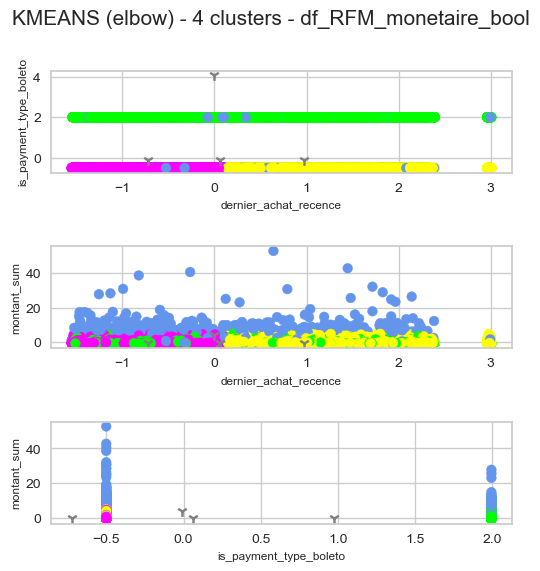


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

------------------------------ is_payment_type_voucher ------------------------------
key_in = df_RFM_monetaire_bool 
 	- 4 clusters
 	- 3 colonnes = ['dernier_achat_recence', 'is_payment_type_voucher', 'montant_sum']
	- nb_subplots = 3 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = is_payment_type_voucher
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = montant_sum
num_ligne = 3 : col_1 = is_payment_type_voucher , col_2 = montant_sum

dict_nb_figure = {'dernier_achat_recence': 2, 'is_payment_type_voucher': 2, 'montant_sum': 2}


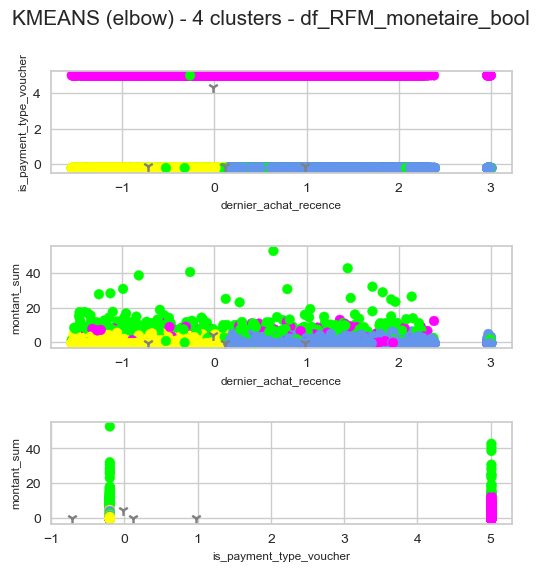


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

------------------------------ is_payment_type_credit_card ------------------------------
key_in = df_RFM_monetaire_bool 
 	- 4 clusters
 	- 3 colonnes = ['dernier_achat_recence', 'is_payment_type_credit_card', 'montant_sum']
	- nb_subplots = 3 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = is_payment_type_credit_card
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = montant_sum
num_ligne = 3 : col_1 = is_payment_type_credit_card , col_2 = montant_sum

dict_nb_figure = {'dernier_achat_recence': 2, 'is_payment_type_credit_card': 2, 'montant_sum': 2}


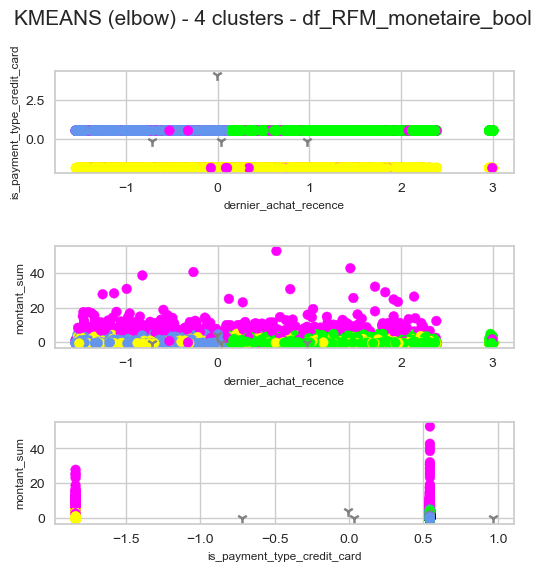


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

------------------------------ is_payment_type_debit_card ------------------------------
key_in = df_RFM_monetaire_bool 
 	- 4 clusters
 	- 3 colonnes = ['dernier_achat_recence', 'is_payment_type_debit_card', 'montant_sum']
	- nb_subplots = 3 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = is_payment_type_debit_card
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = montant_sum
num_ligne = 3 : col_1 = is_payment_type_debit_card , col_2 = montant_sum

dict_nb_figure = {'dernier_achat_recence': 2, 'is_payment_type_debit_card': 2, 'montant_sum': 2}


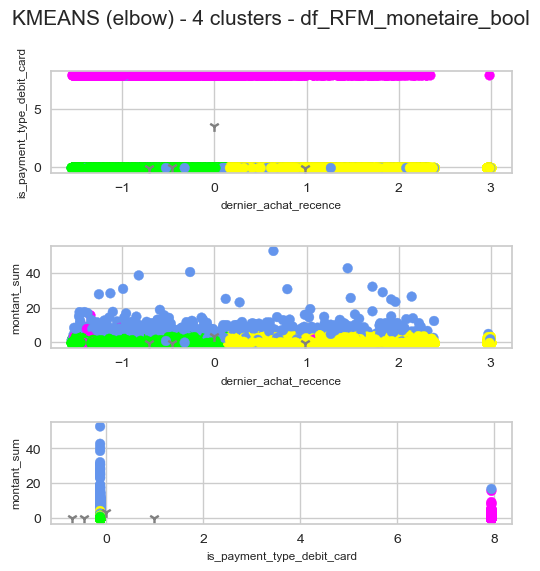


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

------------------------------ is_mode_de_paiement_multiple ------------------------------
key_in = df_RFM_monetaire_bool 
 	- 4 clusters
 	- 3 colonnes = ['dernier_achat_recence', 'is_mode_de_paiement_multiple', 'montant_sum']
	- nb_subplots = 3 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = is_mode_de_paiement_multiple
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = montant_sum
num_ligne = 3 : col_1 = is_mode_de_paiement_multiple , col_2 = montant_sum

dict_nb_figure = {'dernier_achat_recence': 2, 'is_mode_de_paiement_multiple': 2, 'montant_sum': 2}


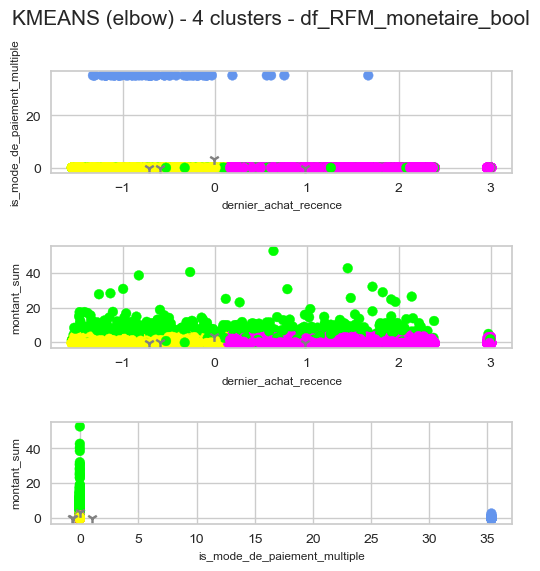


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

------------------------------ is_versement_unique ------------------------------
key_in = df_RFM_monetaire_bool 
 	- 4 clusters
 	- 3 colonnes = ['dernier_achat_recence', 'is_versement_unique', 'montant_sum']
	- nb_subplots = 3 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = is_versement_unique
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = montant_sum
num_ligne = 3 : col_1 = is_versement_unique , col_2 = montant_sum

dict_nb_figure = {'dernier_achat_recence': 2, 'is_versement_unique': 2, 'montant_sum': 2}


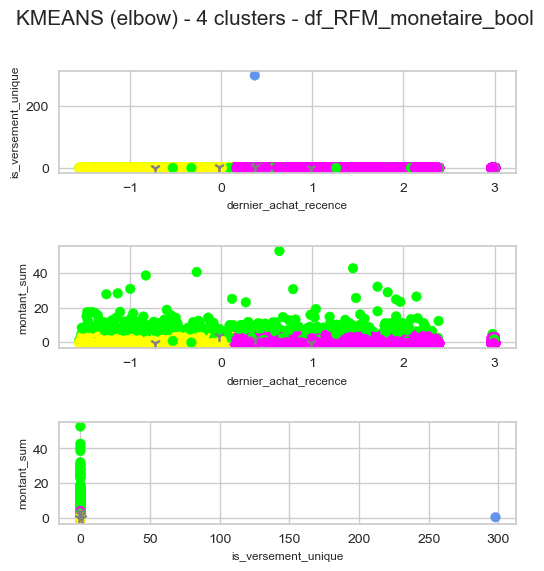


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 



In [61]:
for col_bool in ['is_payment_type_boleto', 'is_payment_type_voucher', 'is_payment_type_credit_card',
                 'is_payment_type_debit_card', 'is_mode_de_paiement_multiple', 'is_versement_unique']:
    
    print('-' * 30, col_bool, '-' * 30)
    df_RFM_monetaire_bool =  X_norm[['dernier_achat_recence',     # dict_recence['DA_sum']-------> OK
                                     'dernier_achat_nb_articles', # dict_frequence['DA_sum']-----> OK
                                     'montant_sum',               # dict_monetaire['sum']--------> OK
                                      col_bool]]                  # dict_monetaire['bool']
    
    liste_colonnes = ['dernier_achat_recence', col_bool, 'montant_sum']
    
    kmeans_elbow_k_optimal(df_in             = df_RFM_monetaire_bool,
                           key_in            = 'df_RFM_monetaire_bool',
                           n_clusters_in     = 4,                        # 4 clusters
                           kmeans_kwargs_in  = kmeans_kwargs_1,
                           liste_colonnes_in = liste_colonnes)
    
# ---> CLUSTERS MOINS BIEN DELIMITES : 'is_payment_type_boleto', 'is_payment_type_voucher', 'is_payment_type_credit_card'.
#
# ---> CLUSTERS : 'is_mode_de_paiement_multiple' et 'is_payment_type_debit_card' ont des clusters similaires mais 
#                 plus fourni pour 'is_payment_type_debit_card' (que l'on garde).
#
# ---> CLUSTER MAIS REDUIT : 'is_versement_unique'.
#
# ==> X_norm[['dernier_achat_recence',       # dict_recence['DA_sum']-------> OK
#             'dernier_achat_nb_articles',   # dict_frequence['DA_sum']-----> OK
#             'montant_sum',                 # dict_monetaire['sum']--------> OK
#             'is_payment_type_debit_card']] # dict_monetaire['bool']-------> OK

In [62]:
# Maj liste colonnes_cluster :i s_mode_de_paiement_multiple remplacé par is_payment_type_debit_card
colonnes_cluster.remove('is_mode_de_paiement_multiple')
colonnes_cluster.append('is_payment_type_debit_card')

# Maj liste colonnes_cluster :
print('colonnes_cluster df_RFM_monetaire_bool :', colonnes_cluster)

colonnes_cluster df_RFM_monetaire_bool : ['dernier_achat_recence', 'montant_sum', 'dernier_achat_nb_articles', 'is_payment_type_debit_card']


In [ ]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @    df_RFM_monetaire_DA_bool    @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Boucle sur les colonnes dict_monetaire['DA_bool'] restants

In [20]:
for col_DA_bool in ['dernier_achat_is_payment_type_boleto', 'dernier_achat_is_payment_type_voucher', 
                    'dernier_achat_is_payment_type_credit_card', 'dernier_achat_is_payment_type_debit_card',
                    'dernier_achat_is_mode_de_paiement_multiple', 'dernier_achat_is_versement_unique']:
    
    print('-' * 30, col_DA_bool, '-' * 30)
    df_RFM_monetaire_DA_bool =  X_norm[['dernier_achat_recence',       # dict_recence['DA_sum']-------> OK
                                        'dernier_achat_nb_articles',   # dict_frequence['DA_sum']-----> OK
                                        'montant_sum',                 # dict_monetaire['sum']--------> OK
                                        'is_payment_type_debit_card',  # dict_monetaire['bool']-------> OK
                                        col_DA_bool]]                  # dict_monetaire['DA_bool']
         
    liste_colonnes = ['dernier_achat_recence', 'dernier_achat_nb_articles', col_DA_bool, 'montant_sum']
    
    kmeans_elbow_k_optimal(df_in             = df_RFM_monetaire_DA_bool,
                           key_in            = 'df_RFM_monetaire_DA_bool',
                           n_clusters_in     = 4,                           # 4 clusters
                           kmeans_kwargs_in  = kmeans_kwargs_1,
                           liste_colonnes_in = liste_colonnes)
    
# ---> PERTE CLUSTER : 'dernier_achat_is_payment_type_boleto', 'dernier_achat_is_payment_type_voucher',
#                      'dernier_achat_is_payment_type_credit_card', 'dernier_achat_is_mode_de_paiement_multiple',
#                      'dernier_achat_is_versement_unique'.
#
# ---> CLUSTER : 'dernier_achat_is_payment_type_debit_card'.


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Traces & graphiques supprimés.

In [ ]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @    df_RFM_monetaire_col_debit_card    @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

------------------------------ is_payment_type_debit_card ------------------------------
key_in = df_RFM_monetaire_col_debit_card 
 	- 4 clusters
 	- 4 colonnes = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'montant_sum', 'is_payment_type_debit_card']
	- nb_subplots = 6 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = dernier_achat_nb_articles
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = montant_sum
num_ligne = 3 : col_1 = dernier_achat_recence , col_2 = is_payment_type_debit_card
num_ligne = 4 : col_1 = dernier_achat_nb_articles , col_2 = montant_sum
num_ligne = 5 : col_1 = dernier_achat_nb_articles , col_2 = is_payment_type_debit_card
num_ligne = 6 : col_1 = montant_sum , col_2 = is_payment_type_debit_card

dict_nb_figure = {'dernier_achat_recence': 3, 'dernier_achat_nb_articles': 3, 'montant_sum': 3, 'is_payment_type_debit_card': 3}


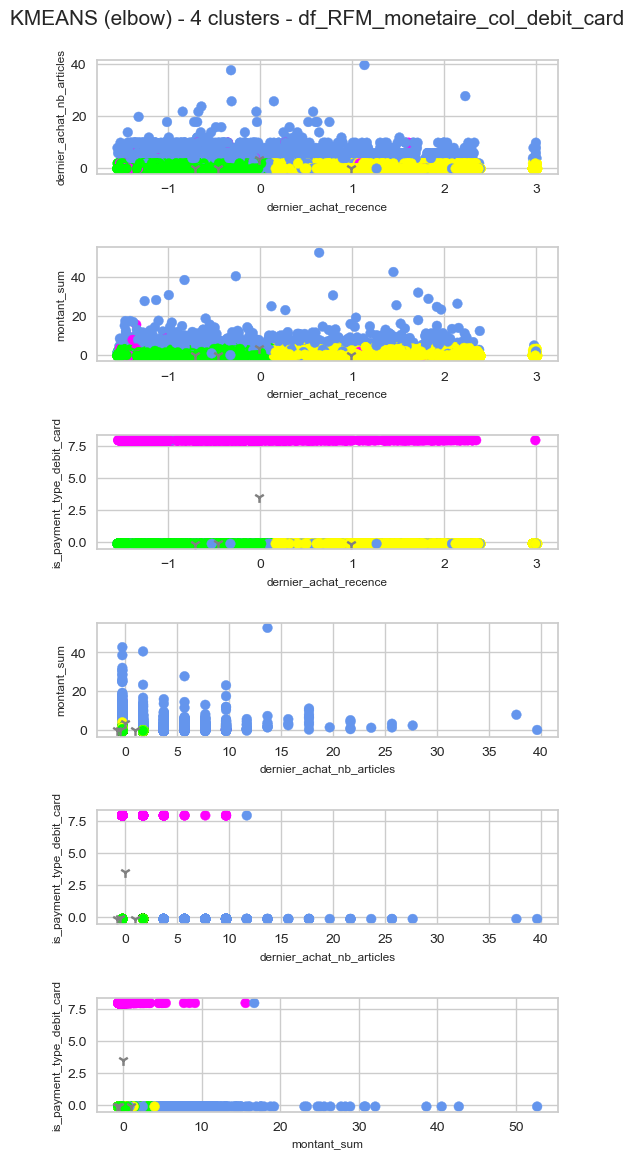



------------------------------ dernier_achat_is_payment_type_debit_card ------------------------------
key_in = df_RFM_monetaire_col_debit_card 
 	- 4 clusters
 	- 4 colonnes = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'montant_sum', 'dernier_achat_is_payment_type_debit_card']
	- nb_subplots = 6 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = dernier_achat_nb_articles
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = montant_sum
num_ligne = 3 : col_1 = dernier_achat_recence , col_2 = dernier_achat_is_payment_type_debit_card
num_ligne = 4 : col_1 = dernier_achat_nb_articles , col_2 = montant_sum
num_ligne = 5 : col_1 = dernier_achat_nb_articles , col_2 = dernier_achat_is_payment_type_debit_card
num_ligne = 6 : col_1 = montant_sum , col_2 = dernier_achat_is_payment_type_debit_card

dict_nb_figure = {'dernier_achat_recence': 3, 'dernier_achat_nb_articles': 3, 'montant_sum': 3, 'dernier_achat_is_payment_type_debit_card': 3}


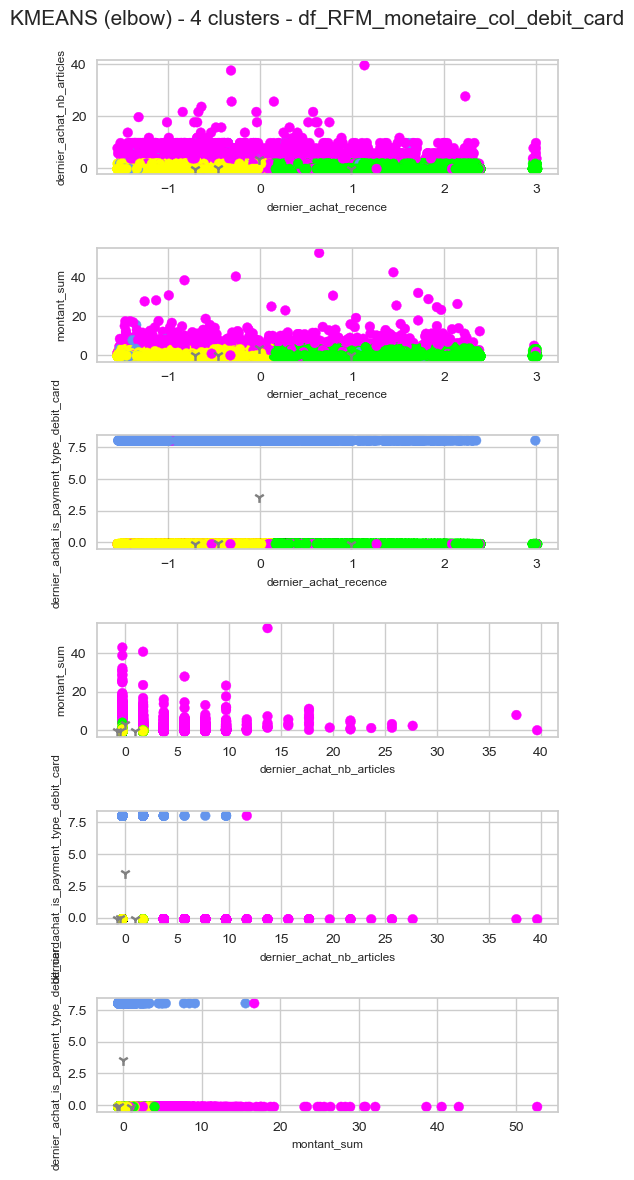

In [64]:
# Comparaison is_payment_type_debit_card et dernier_achat_is_payment_type_debit_card (redondants ?)
for col_debit_card in ['is_payment_type_debit_card', 'dernier_achat_is_payment_type_debit_card']:
    
    print('-' * 30, col_debit_card, '-' * 30)
    df_RFM_monetaire_col_debit_card =  X_norm[['dernier_achat_recence',     # dict_recence['DA_sum']-------> OK
                                               'dernier_achat_nb_articles', # dict_frequence['DA_sum']-----> OK
                                               'montant_sum',               # dict_monetaire['sum']--------> OK
                                               col_debit_card]]             # dict_monetaire['DA_bool']    
    
    
    kmeans_elbow_k_optimal(df_in             = df_RFM_monetaire_col_debit_card,
                           key_in            = 'df_RFM_monetaire_col_debit_card',
                           n_clusters_in     = 4,                                   # 4 clusters
                           kmeans_kwargs_in  = kmeans_kwargs_1)
    
# --> CLUSTER : is_payment_type_debit_card, dernier_achat_is_payment_type_debit_card
#               PAS DE DIFFERENCE => on privilégie la colonne la plus large (celle de tous les achats) : 
#               is_payment_type_debit_card.
#
# ==> X_norm[['dernier_achat_recence',       # dict_recence['DA_sum']-------> OK
#             'dernier_achat_nb_articles',   # dict_frequence['DA_sum']-----> OK
#             'montant_sum',                 # dict_monetaire['sum']--------> OK
#             'is_payment_type_debit_card']] # dict_monetaire['bool']-------> OK

In [65]:
# Maj liste colonnes_cluster :
print('colonnes_cluster df_RFM_monetaire_DA_bool :', colonnes_cluster)

colonnes_cluster df_RFM_monetaire_DA_bool : ['dernier_achat_recence', 'montant_sum', 'dernier_achat_nb_articles', 'is_payment_type_debit_card']


In [ ]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @         df_RFM_5           @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [13]:
kmeans_elbow_k_optimal(df_in            = df_RFM_5,
                       key_in           = 'df_RFM_5',
                       n_clusters_in    = 4,                 # 4 clusters
                       kmeans_kwargs_in = kmeans_kwargs_1)

# PERTE DES CLUSTERS INITIAUX


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Traces & graphiques supprimés.

In [67]:
# Analyse courbes 2D pour la création de clusters : 
# |------------------------------|---------------------------------|----------------------------------------------------|
# |    Colonnes utiles           |       Colonnes inutiles         | Commentaire                                        |
# |------------------------------|---------------------------------|----------------------------------------------------|
# | dernier_achat_recence        |                                 |                                                    |
# | montant_sum                  |                                 |                                                    |
# | dernier_achat_nb_articles    |                                 |                                                    |
# | is_payment_type_debit_card   |                                 |                                                    |
# |                              |  montant_mean                   | PERTE DES CLUSTERS INITIAUX                        |
# |------------------------------|---------------------------------|----------------------------------------------------|


# Maj liste colonnes_cluster :
print('colonnes_cluster df_RFM_5 :', colonnes_cluster)

colonnes_cluster df_RFM_5 : ['dernier_achat_recence', 'montant_sum', 'dernier_achat_nb_articles', 'is_payment_type_debit_card']


# 2.1.2.2. VERTICALE RFMS (RECENCE, FREQUENCE, MONETAIRE, SATISFACTION)

In [ ]:
# @@@@@@@@@@@@@@@@@#@@@@@@@@@@@@@
# @  df_RFMS_satisfaction_bool  @
# @@@@@@@@@@@@@@@@@@#@@@@@@@@@@@@
# Boucle sur les colonnes dict_satisfaction['bool'].

In [22]:
for col_bool in ['is_satisfaction_client', 'is_review_comment_title', 'is_review_comment_title_important',
                 'is_review_comment_message', 'is_review_comment_message_important']:
    
    print('-' * 30, col_bool, '-' * 30)
    df_RFMS_satisfaction_bool =  X_norm[['dernier_achat_recence',      # dict_recence['DA_sum']-------> OK
                                         'dernier_achat_nb_articles',  # dict_frequence['DA_sum']-----> OK
                                         'montant_sum',                # dict_monetaire['sum']--------> OK
                                         'is_payment_type_debit_card', # dict_monetaire['bool']-------> OK
                                         col_bool]]                    # dict_satisfaction['bool']
    
    liste_colonnes = ['dernier_achat_recence', col_bool, 'montant_sum']
    
    kmeans_elbow_k_optimal(df_in             = df_RFMS_satisfaction_bool,
                           key_in            = 'df_RFMS_satisfaction_bool',
                           n_clusters_in     = 4,                            # 4 clusters
                           kmeans_kwargs_in  = kmeans_kwargs_1,
                           liste_colonnes_in = liste_colonnes)

# ---> PROBLEME : VALEUR UNIQUE : 'is_satisfaction_client'
#
# ---> PERTE CLUSTERS : 'is_review_comment_title', 'is_review_comment_title_important', 'is_review_comment_message'
#                       'is_review_comment_message_important'

#
# ==> X_norm[['dernier_achat_recence',       # dict_recence['DA_sum']-------> OK
#             'dernier_achat_nb_articles',   # dict_frequence['DA_sum']-----> OK
#             'montant_sum',                 # dict_monetaire['sum']--------> OK
#             'is_payment_type_debit_card']] # dict_monetaire['bool']-------> OK


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Traces & graphiques supprimés.

In [ ]:
# @@@@@@@@@@@@@@@@@#@@@@@@@@@@@@@@@@
# @  df_RFMS_satisfaction_DA_bool  @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Boucle sur les colonnes dict_satisfaction['DA_bool'].

In [21]:
for col_DA_bool in ['dernier_achat_is_satisfaction_client', 'dernier_achat_is_review_comment_title', 
                    'dernier_achat_is_review_comment_title_important', 'dernier_achat_is_review_comment_message',
                    'dernier_achat_is_review_comment_message_important']:
    
    print('-' * 30, col_DA_bool, '-' * 30)
    df_RFMS_satisfaction_DA_bool =  X_norm[['dernier_achat_recence',      # dict_recence['DA_sum']-------> OK
                                            'dernier_achat_nb_articles',  # dict_frequence['DA_sum']-----> OK
                                            'montant_sum',                # dict_monetaire['sum']--------> OK
                                            'is_payment_type_debit_card', # dict_monetaire['bool']-------> OK
                                            col_DA_bool]]                 # dict_satisfaction['DA_bool']
    
    liste_colonnes = ['dernier_achat_recence', col_DA_bool, 'montant_sum']
   
    kmeans_elbow_k_optimal(df_in             = df_RFMS_satisfaction_DA_bool,
                           key_in            = 'df_RFMS_satisfaction_DA_bool',
                           n_clusters_in     = 4,                               # 4 clusters
                           kmeans_kwargs_in  = kmeans_kwargs_1,
                           liste_colonnes_in = liste_colonnes)
        
# ---> PROBLEME : VALEUR UNIQUE : 'dernier_achat_is_satisfaction_client'
#
# ---> PERTE CLUSTERS : 'dernier_achat_is_review_comment_title', 'dernier_achat_is_review_comment_title_important', 
#                       'dernier_achat_is_review_comment_message', 'dernier_achat_is_review_comment_message_important'

#
# ==> X_norm[['dernier_achat_recence',       # dict_recence['DA_sum']-------> OK
#             'dernier_achat_nb_articles',   # dict_frequence['DA_sum']-----> OK
#             'montant_sum',                 # dict_monetaire['sum']--------> OK
#             'is_payment_type_debit_card']] # dict_monetaire['bool']-------> OK


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Traces & graphiques supprimés.

In [ ]:
# @@@@@@@@@@@@@@@@@#@@@@@@@@@@@@@@@@@@@@@@@@@@
# @  df_RFMS_satisfaction_delta_client_jour  @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

------------------------------ review_delta_client_jour_mean ------------------------------
key_in = df_RFMS_satisfaction_delta_client_jour 
 	- 4 clusters
 	- 5 colonnes = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'montant_sum', 'is_payment_type_debit_card', 'review_delta_client_jour_mean']
	- nb_subplots = 10 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = dernier_achat_nb_articles
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = montant_sum
num_ligne = 3 : col_1 = dernier_achat_recence , col_2 = is_payment_type_debit_card
num_ligne = 4 : col_1 = dernier_achat_recence , col_2 = review_delta_client_jour_mean
num_ligne = 5 : col_1 = dernier_achat_nb_articles , col_2 = montant_sum
num_ligne = 6 : col_1 = dernier_achat_nb_articles , col_2 = is_payment_type_debit_card
num_ligne = 7 : col_1 = dernier_achat_nb_articles , col_2 = review_delta_client_jour_mean
num_ligne = 8 : col_1 = montant_sum , col_2 = is_payment_type_debit_card
num_ligne = 9 : col_1 = montant

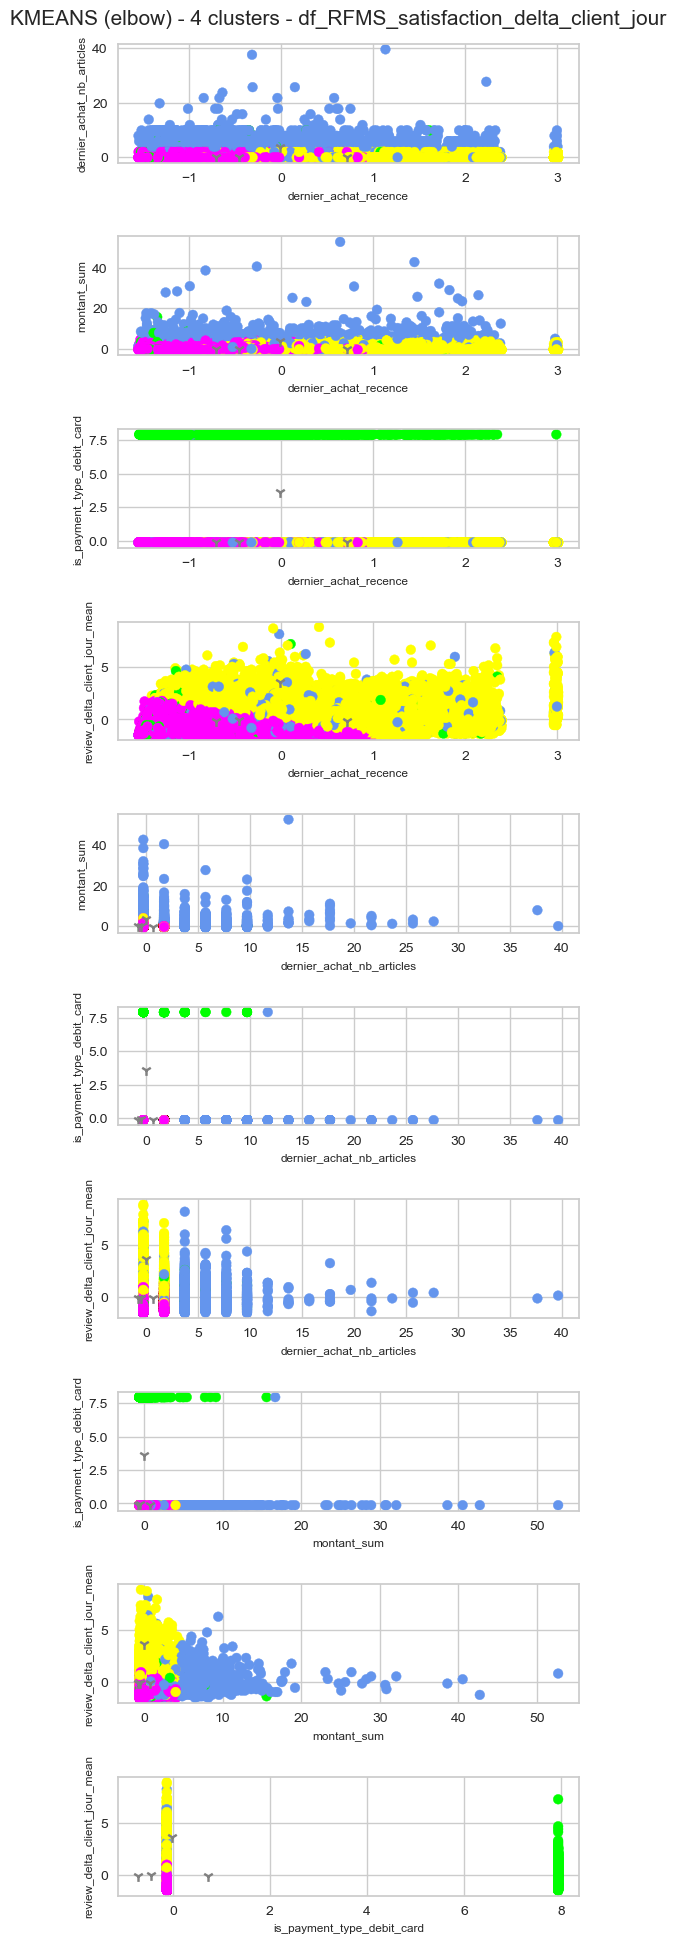



------------------------------ dernier_achat_review_delta_client_jour ------------------------------
key_in = df_RFMS_satisfaction_delta_client_jour 
 	- 4 clusters
 	- 5 colonnes = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'montant_sum', 'is_payment_type_debit_card', 'dernier_achat_review_delta_client_jour']
	- nb_subplots = 10 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = dernier_achat_nb_articles
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = montant_sum
num_ligne = 3 : col_1 = dernier_achat_recence , col_2 = is_payment_type_debit_card
num_ligne = 4 : col_1 = dernier_achat_recence , col_2 = dernier_achat_review_delta_client_jour
num_ligne = 5 : col_1 = dernier_achat_nb_articles , col_2 = montant_sum
num_ligne = 6 : col_1 = dernier_achat_nb_articles , col_2 = is_payment_type_debit_card
num_ligne = 7 : col_1 = dernier_achat_nb_articles , col_2 = dernier_achat_review_delta_client_jour
num_ligne = 8 : col_1 = montant_sum , col_2 = is_payment_type_debi

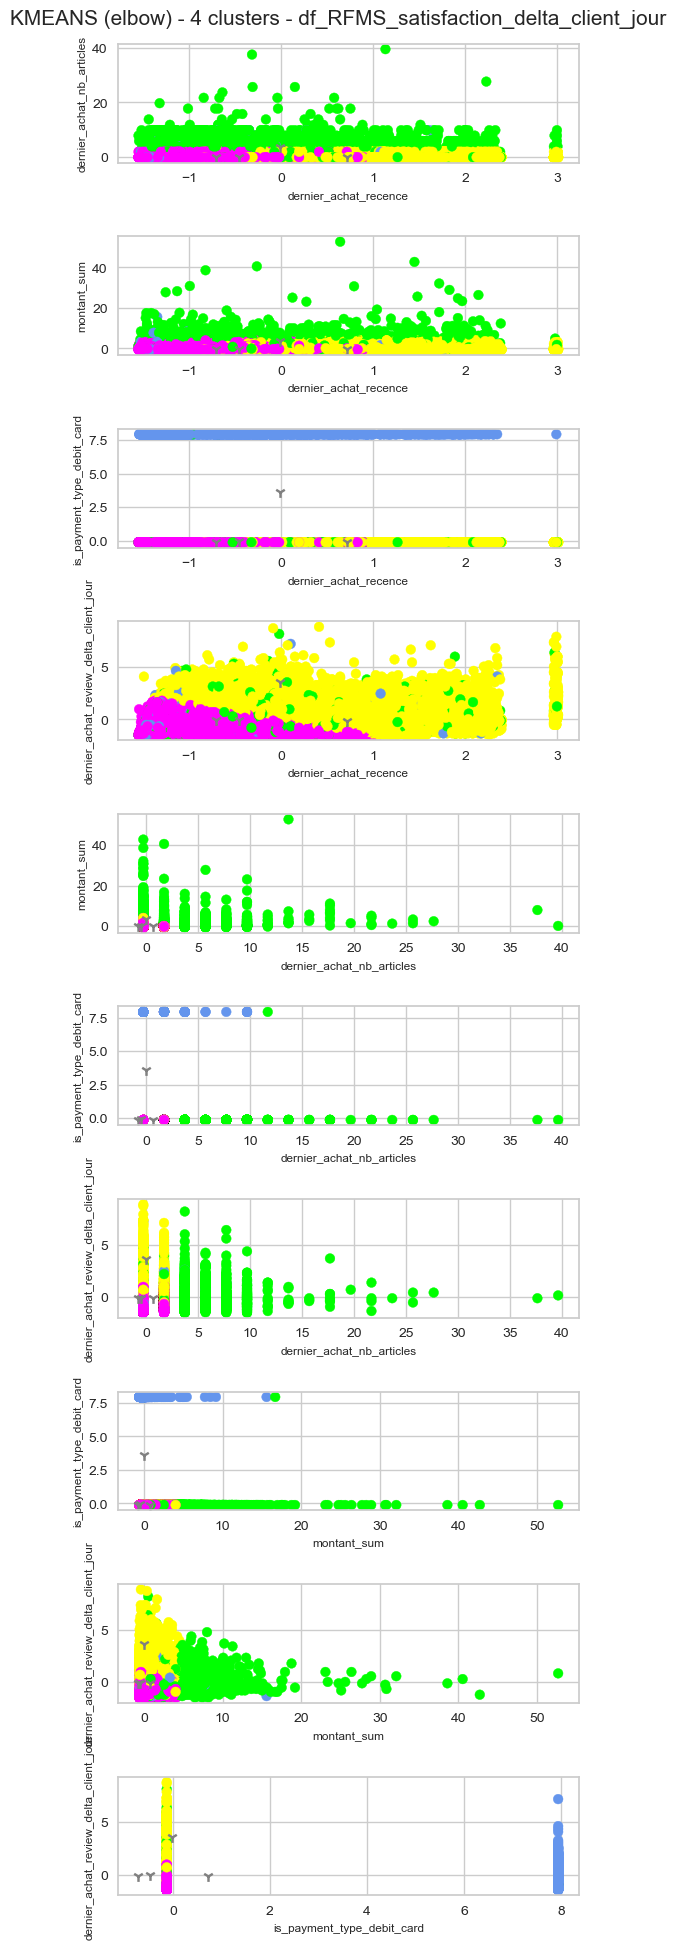

In [70]:
# Comparaison review_delta_client_jour_mean et dernier_achat_review_delta_client_jour (redondants ?)
for col_delta_client_jour_card in ['review_delta_client_jour_mean', 'dernier_achat_review_delta_client_jour']:
    
    print('-' * 30, col_delta_client_jour_card, '-' * 30)
    df_RFMS_satisfaction_delta_client_jour =  X_norm[['dernier_achat_recence',      # dict_recence['DA_sum']-------> OK
                                                      'dernier_achat_nb_articles',  # dict_frequence['DA_sum']-----> OK
                                                      'montant_sum',                # dict_monetaire['sum']--------> OK
                                                      'is_payment_type_debit_card', # dict_monetaire['bool']-------> OK
                                                      col_delta_client_jour_card]]  # dict_satisfaction['mean' / 'DA_sum']    
    
    
    kmeans_elbow_k_optimal(df_in             = df_RFMS_satisfaction_delta_client_jour,
                           key_in            = 'df_RFMS_satisfaction_delta_client_jour',
                           n_clusters_in     = 4,                                         # 4 clusters
                           kmeans_kwargs_in  = kmeans_kwargs_1)
    
# ---> CLUSTER : review_delta_client_jour_mean, dernier_achat_review_delta_client_jour
#                PAS DE DIFFERENCE => on privilégie la colonne la plus large (celle de tous les achats) : 
#                review_delta_client_jour_mean.
#
# ==> X_norm[['dernier_achat_recence',          # dict_recence['DA_sum']-------> OK
#             'dernier_achat_nb_articles',      # dict_frequence['DA_sum']-----> OK
#             'montant_sum',                    # dict_monetaire['sum']--------> OK
#             'is_payment_type_debit_card',     # dict_monetaire['bool']-------> OK
#             'review_delta_client_jour_mean']] # dict_satisfaction['mean']----> OK
# ==> création de df_RFMS_1.

In [ ]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @         df_RFMS_1         @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

In [ ]:
# Analyse 2D faite ci-dessus.

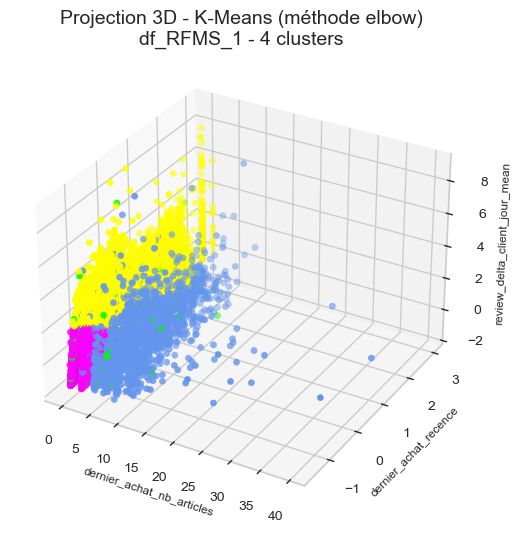

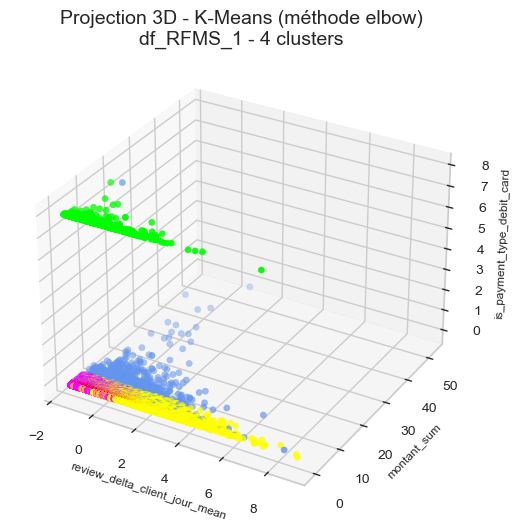

In [71]:
# Projection 3D des colonnes avec les meilleurs clusters

# Anciennes features : dernier_achat_recence, dernier_achat_nb_articles, montant_sum, is_payment_type_debit_card 
# Nouvelles features : review_delta_client_jour_mean

liste_1 = ['dernier_achat_nb_articles', 'dernier_achat_recence', 'review_delta_client_jour_mean']
liste_2 = ['review_delta_client_jour_mean', 'montant_sum', 'is_payment_type_debit_card']

for liste in [liste_1, liste_2]:
    kmeans_elbow_k_optimal_3D(df_in             = df_RFMS_1,
                              key_in            = 'df_RFMS_1',
                              n_clusters_in     = 4,                 # 4 clusters
                              kmeans_kwargs_in  = kmeans_kwargs_1,
                              liste_colonnes_in = liste)
    print('\n')

In [72]:
# Maj liste colonnes_cluster : is_mode_de_paiement_multiple remplacé par is_payment_type_debit_card
colonnes_cluster.append('review_delta_client_jour_mean')

# Maj liste colonnes_cluster :
print('colonnes_cluster df_RFMS_1 :', colonnes_cluster)

colonnes_cluster df_RFMS_1 : ['dernier_achat_recence', 'montant_sum', 'dernier_achat_nb_articles', 'is_payment_type_debit_card', 'review_delta_client_jour_mean']


# 2.1.2.3. VERTICALE RFMSL (RECENCE, FREQUENCE, MONETAIRE, SATISFACTION, LIVRAISON)

In [ ]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @   df_RFMSL_livraison_sum    @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Boucle sur les colonnes dict_livraison['sum'].

In [14]:
for col_sum in ['order_delta_validation_jour_sum', 'order_delta_livraison_transporteur_jour_sum', 
                'order_delta_livraison_client_jour_sum', 'order_livraison_on_time_sum']:    

    print('-' * 30, col_sum, '-' * 30)
    df_RFMSL_livraison_sum = X_norm[['dernier_achat_recence',         # dict_recence['DA_sum']-------> OK
                                     'dernier_achat_nb_articles',     # dict_frequence['DA_sum']-----> OK
                                     'montant_sum',                   # dict_monetaire['sum']--------> OK
                                     'is_payment_type_debit_card',    # dict_monetaire['bool']-------> OK
                                     'review_delta_client_jour_mean', # dict_satisfaction['mean']----> OK
                                     col_sum]]                        # dict_livraison['sum']

    liste_colonnes = ['dernier_achat_recence', col_sum, 'montant_sum']
    
    kmeans_elbow_k_optimal(df_in             = df_RFMSL_livraison_sum,
                           key_in            = 'df_RFMSL_livraison_sum',
                           n_clusters_in     = 4,                            # 4 clusters
                           kmeans_kwargs_in  = kmeans_kwargs_1,
                           liste_colonnes_in = liste_colonnes)

# ---> CLUSTER PETIT / PAS CLAIR : 'order_delta_validation_jour_sum', 'order_delta_livraison_transporteur_jour_sum'
#
# ---> CLUSTER DANS LE NEGATIF : 'order_livraison_on_time_sum'
#
# ---> PERTE CLUSTERS : 'order_delta_livraison_client_jour_sum'
#
#
# ==> X_norm[['dernier_achat_recence',          # dict_recence['DA_sum']-------> OK
#             'dernier_achat_nb_articles',      # dict_frequence['DA_sum']-----> OK
#             'montant_sum',                    # dict_monetaire['sum']--------> OK
#             'is_payment_type_debit_card',     # dict_monetaire['bool']-------> OK
#             'review_delta_client_jour_mean']] # dict_satisfaction['mean']----> OK


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Traces & graphiques supprimés.

In [ ]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @   df_RFMSL_livraison_DA_sum    @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Boucle sur les colonnes dict_livraison['DA_sum'].

------------------------------ dernier_achat_order_delta_validation_jour_sum ------------------------------
key_in = df_RFMSL_livraison_DA_sum 
 	- 4 clusters
 	- 3 colonnes = ['dernier_achat_recence', 'dernier_achat_order_delta_validation_jour_sum', 'montant_sum']
	- nb_subplots = 3 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = dernier_achat_order_delta_validation_jour_sum
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = montant_sum
num_ligne = 3 : col_1 = dernier_achat_order_delta_validation_jour_sum , col_2 = montant_sum

dict_nb_figure = {'dernier_achat_recence': 2, 'dernier_achat_order_delta_validation_jour_sum': 2, 'montant_sum': 2}


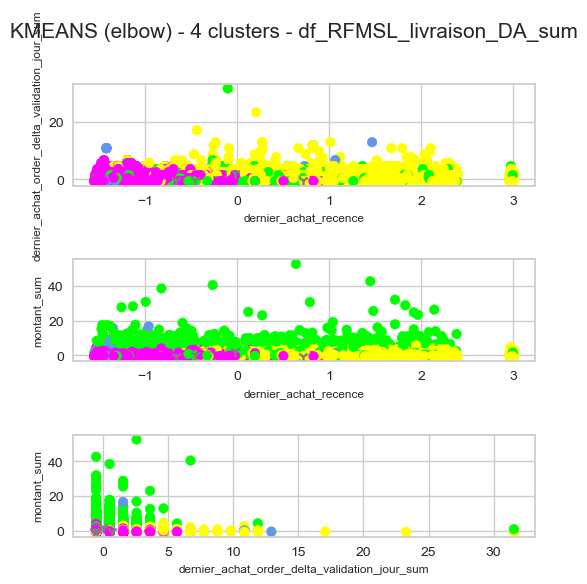


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

------------------------------ dernier_achat_order_delta_livraison_transporteur_jour_sum ------------------------------
key_in = df_RFMSL_livraison_DA_sum 
 	- 4 clusters
 	- 3 colonnes = ['dernier_achat_recence', 'dernier_achat_order_delta_livraison_transporteur_jour_sum', 'montant_sum']
	- nb_subplots = 3 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = dernier_achat_order_delta_livraison_transporteur_jour_sum
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = montant_sum
num_ligne = 3 : col_1 = dernier_achat_order_delta_livraison_transporteur_jour_sum , col_2 = montant_sum

dict_nb_figure = {'dernier_achat_recence': 2, 'dernier_achat_order_delta_livraison_transporteur_jour_sum': 2, 'montant_sum': 2}


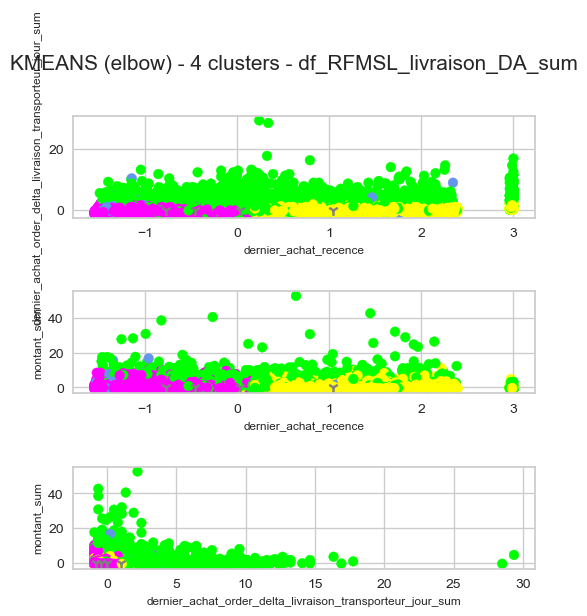


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

------------------------------ dernier_achat_order_delta_livraison_client_jour_sum ------------------------------
key_in = df_RFMSL_livraison_DA_sum 
 	- 4 clusters
 	- 3 colonnes = ['dernier_achat_recence', 'dernier_achat_order_delta_livraison_client_jour_sum', 'montant_sum']
	- nb_subplots = 3 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = dernier_achat_order_delta_livraison_client_jour_sum
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = montant_sum
num_ligne = 3 : col_1 = dernier_achat_order_delta_livraison_client_jour_sum , col_2 = montant_sum

dict_nb_figure = {'dernier_achat_recence': 2, 'dernier_achat_order_delta_livraison_client_jour_sum': 2, 'montant_sum': 2}


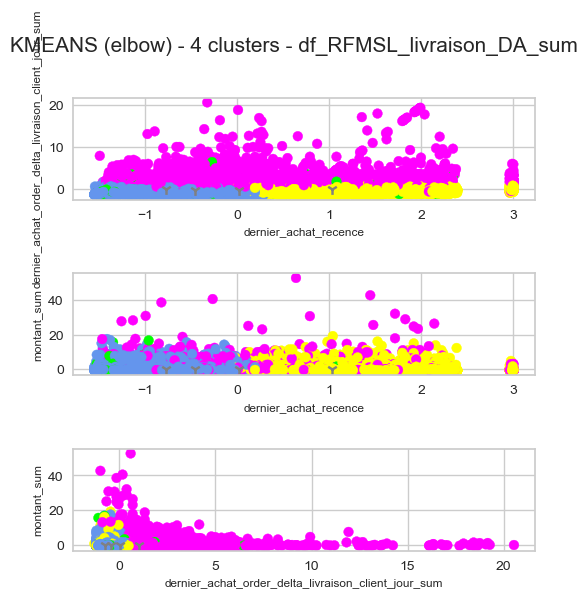


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

------------------------------ dernier_achat_order_livraison_on_time_sum ------------------------------
key_in = df_RFMSL_livraison_DA_sum 
 	- 4 clusters
 	- 3 colonnes = ['dernier_achat_recence', 'dernier_achat_order_livraison_on_time_sum', 'montant_sum']
	- nb_subplots = 3 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = dernier_achat_order_livraison_on_time_sum
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = montant_sum
num_ligne = 3 : col_1 = dernier_achat_order_livraison_on_time_sum , col_2 = montant_sum

dict_nb_figure = {'dernier_achat_recence': 2, 'dernier_achat_order_livraison_on_time_sum': 2, 'montant_sum': 2}


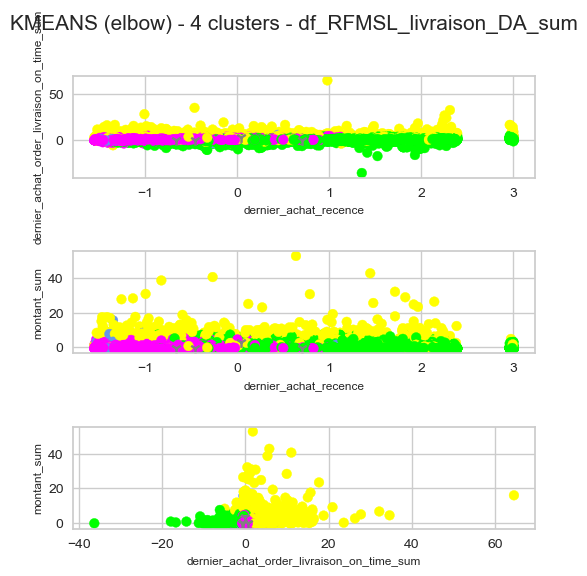


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 



In [74]:
for col_DA_sum in ['dernier_achat_order_delta_validation_jour_sum', 
                   'dernier_achat_order_delta_livraison_transporteur_jour_sum', 
                   'dernier_achat_order_delta_livraison_client_jour_sum', 'dernier_achat_order_livraison_on_time_sum']:    

    print('-' * 30, col_DA_sum, '-' * 30)
    df_RFMSL_livraison_DA_sum = X_norm[['dernier_achat_recence',         # dict_recence['DA_sum']-------> OK
                                        'dernier_achat_nb_articles',     # dict_frequence['DA_sum']-----> OK
                                        'montant_sum',                   # dict_monetaire['sum']--------> OK
                                        'is_payment_type_debit_card',    # dict_monetaire['bool']-------> OK
                                        'review_delta_client_jour_mean', # dict_satisfaction['mean']----> OK
                                        col_DA_sum]]                     # dict_livraison['DA_sum']

    liste_colonnes = ['dernier_achat_recence', col_DA_sum, 'montant_sum']
    
    kmeans_elbow_k_optimal(df_in             = df_RFMSL_livraison_DA_sum,
                           key_in            = 'df_RFMSL_livraison_DA_sum',
                           n_clusters_in     = 4,                            # 4 clusters
                           kmeans_kwargs_in  = kmeans_kwargs_1,
                           liste_colonnes_in = liste_colonnes)
    
# ---> CLUSTER DANS LE NEGATIF : 'dernier_achat_order_livraison_on_time_sum'
#
# ---> PERTE CLUSTERS : 'dernier_achat_order_delta_validation_jour_sum'
#                       'dernier_achat_order_delta_livraison_client_jour_sum' 
#
# ---> CLUSTER : 'dernier_achat_order_delta_livraison_transporteur_jour_sum'
#
#
# ==> X_norm[['dernier_achat_recence',                                      # dict_recence['DA_sum']-------> OK
#             'dernier_achat_nb_articles',                                  # dict_frequence['DA_sum']-----> OK
#             'montant_sum',                                                # dict_monetaire['sum']--------> OK
#             'is_payment_type_debit_card',                                 # dict_monetaire['bool']-------> OK
#             'review_delta_client_jour_mean',                              # dict_satisfaction['mean']----> OK
#             'dernier_achat_order_delta_livraison_transporteur_jour_sum']] # dict_livraison['DA_sum']
# ==> création de df_RFMSL_1.

In [ ]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @          df_RFMSL_1            @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

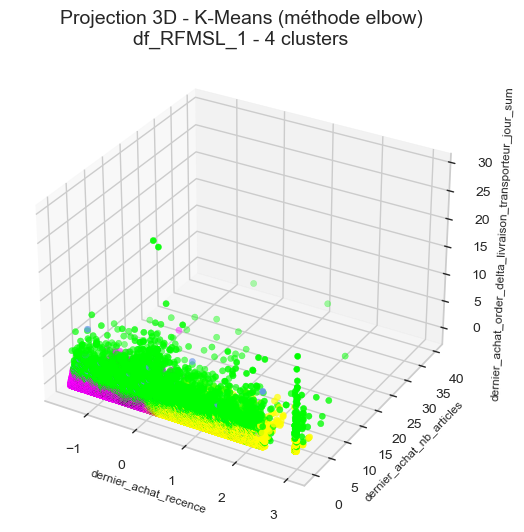

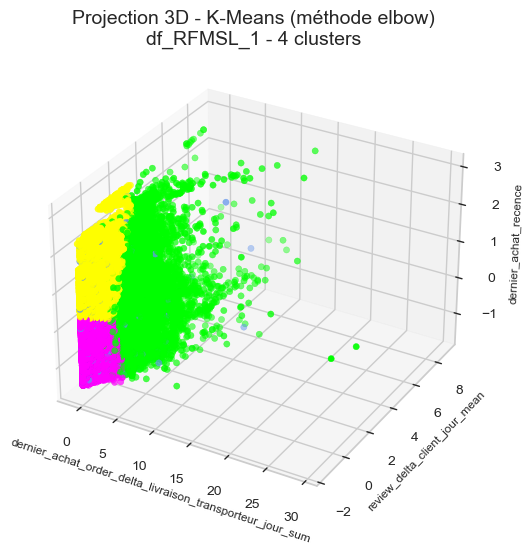

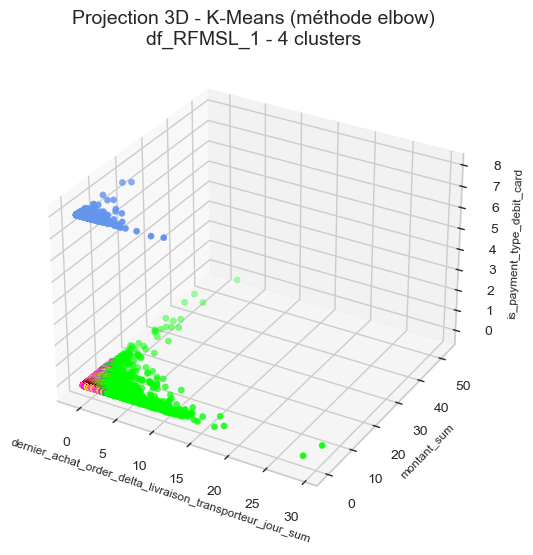

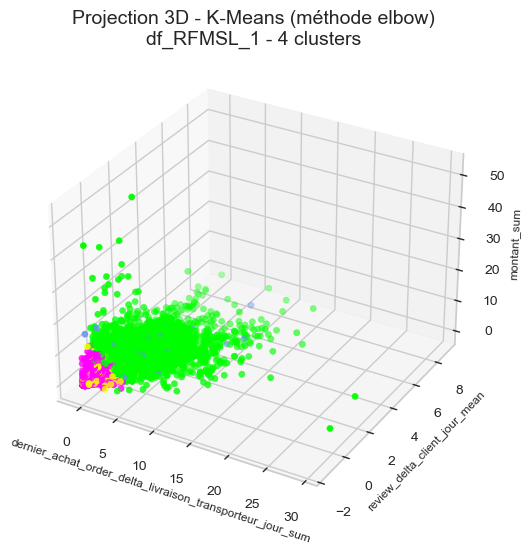

In [75]:
# Projection 3D des colonnes avec les meilleurs clusters (pour vérifier utilité de 
# dernier_achat_order_delta_livraison_transporteur_jour_sum).

# Anciennes features : dernier_achat_recence, dernier_achat_nb_articles, montant_sum, is_payment_type_debit_card,
#                      review_delta_client_jour_mean
# Nouvelles features : dernier_achat_order_delta_livraison_transporteur_jour_sum
        
liste_1 = ['dernier_achat_recence', 'dernier_achat_nb_articles', 
           'dernier_achat_order_delta_livraison_transporteur_jour_sum']
liste_2 = ['dernier_achat_order_delta_livraison_transporteur_jour_sum', 'review_delta_client_jour_mean', 
           'dernier_achat_recence']
liste_3 = ['dernier_achat_order_delta_livraison_transporteur_jour_sum', 'montant_sum', 'is_payment_type_debit_card']
liste_4 = ['dernier_achat_order_delta_livraison_transporteur_jour_sum', 'review_delta_client_jour_mean', 'montant_sum']

for liste in [liste_1, liste_2, liste_3, liste_4]:
    kmeans_elbow_k_optimal_3D(df_in             = df_RFMSL_1,
                              key_in            = 'df_RFMSL_1',
                              n_clusters_in     = 4,                 # 4 clusters
                              kmeans_kwargs_in  = kmeans_kwargs_1,
                              liste_colonnes_in = liste)
    print('\n')

In [76]:
# Maj liste colonnes_cluster :
colonnes_cluster.append('dernier_achat_order_delta_livraison_transporteur_jour_sum')

# Maj liste colonnes_cluster :
print('colonnes_cluster df_RFMS_1 :', colonnes_cluster)

colonnes_cluster df_RFMS_1 : ['dernier_achat_recence', 'montant_sum', 'dernier_achat_nb_articles', 'is_payment_type_debit_card', 'review_delta_client_jour_mean', 'dernier_achat_order_delta_livraison_transporteur_jour_sum']


In [ ]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @    df_RFMSL_livraison_mean     @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Boucle sur les colonnes dict_livraison['mean']

In [15]:
for col_mean in ['order_delta_validation_jour_mean', 'order_delta_livraison_transporteur_jour_mean',
                 'order_delta_livraison_client_jour_mean', 'order_livraison_on_time_mean']:    

    print('-' * 30, col_mean, '-' * 30)
    df_RFMSL_livraison_mean = \
    X_norm[['dernier_achat_recence',                                     # dict_recence['DA_sum']-------> OK
            'dernier_achat_nb_articles',                                 # dict_frequence['DA_sum']-----> OK
            'montant_sum',                                               # dict_monetaire['sum']--------> OK
            'is_payment_type_debit_card',                                # dict_monetaire['bool']-------> OK
            'review_delta_client_jour_mean',                             # dict_satisfaction['mean']----> OK
            'dernier_achat_order_delta_livraison_transporteur_jour_sum', # dict_livraison['DA_sum']-----> OK
            col_mean]]                                                   # dict_livraison['mean']

    liste_colonnes = ['dernier_achat_recence', col_mean, 'montant_sum']
    
    kmeans_elbow_k_optimal(df_in             = df_RFMSL_livraison_mean,
                           key_in            = 'df_RFMSL_livraison_mean',
                           n_clusters_in     = 4,                            # 4 clusters
                           kmeans_kwargs_in  = kmeans_kwargs_1,
                           liste_colonnes_in = liste_colonnes)

# ---> CLUSTER PETIT / PAS CLAIR : 'order_delta_validation_jour_mean', 'order_delta_livraison_transporteur_jour_mean',
#                                  'order_delta_livraison_client_jour_mean', 'order_livraison_on_time_mean'
#
#
# ==> X_norm[['dernier_achat_recence',                                      # dict_recence['DA_sum']-------> OK
#             'dernier_achat_nb_articles',                                  # dict_frequence['DA_sum']-----> OK
#             'montant_sum',                                                # dict_monetaire['sum']--------> OK
#             'is_payment_type_debit_card',                                 # dict_monetaire['bool']-------> OK
#             'review_delta_client_jour_mean',                              # dict_satisfaction['mean']----> OK
#             'dernier_achat_order_delta_livraison_transporteur_jour_sum']] # dict_livraison['DA_sum']-----> OK


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Traces & graphiques supprimés.

In [ ]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @   df_RFMSL_livraison_DA_mean   @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Boucle sur les colonnes dict_livraison['DA_mean']

In [16]:
for col_DA_mean in ['dernier_achat_order_delta_validation_jour_mean', 
                    'dernier_achat_order_delta_livraison_transporteur_jour_mean',
                    'dernier_achat_order_delta_livraison_client_jour_mean', 'dernier_achat_order_livraison_on_time_mean']:    

    print('-' * 30, col_DA_mean, '-' * 30)
    df_RFMSL_livraison_DA_mean = \
    X_norm[['dernier_achat_recence',                                     # dict_recence['DA_sum']-------> OK
            'dernier_achat_nb_articles',                                 # dict_frequence['DA_sum']-----> OK
            'montant_sum',                                               # dict_monetaire['sum']--------> OK
            'is_payment_type_debit_card',                                # dict_monetaire['bool']-------> OK
            'review_delta_client_jour_mean',                             # dict_satisfaction['mean']----> OK
            'dernier_achat_order_delta_livraison_transporteur_jour_sum', # dict_livraison['DA_sum']-----> OK
            col_DA_mean]]                                                # dict_livraison['DA_mean']

    liste_colonnes = ['dernier_achat_recence', col_DA_mean, 'montant_sum']
    
    kmeans_elbow_k_optimal(df_in             = df_RFMSL_livraison_DA_mean,
                           key_in            = 'df_RFMSL_livraison_DA_mean',
                           n_clusters_in     = 4,                            # 4 clusters
                           kmeans_kwargs_in  = kmeans_kwargs_1,
                           liste_colonnes_in = liste_colonnes)

# ---> CLUSTER PETIT / PAS CLAIR : 'dernier_achat_order_delta_validation_jour_mean',
#                                  'dernier_achat_order_delta_livraison_transporteur_jour_mean', 
#                                  'dernier_achat_order_delta_livraison_client_jour_mean', 
#                                  'dernier_achat_order_livraison_on_time_mean'
#
# ==> X_norm[['dernier_achat_recence',                                      # dict_recence['DA_sum']-------> OK
#             'dernier_achat_nb_articles',                                  # dict_frequence['DA_sum']-----> OK
#             'montant_sum',                                                # dict_monetaire['sum']--------> OK
#             'is_payment_type_debit_card',                                 # dict_monetaire['bool']-------> OK
#             'review_delta_client_jour_mean',                              # dict_satisfaction['mean']----> OK
#             'dernier_achat_order_delta_livraison_transporteur_jour_sum']] # dict_livraison['DA_sum']-----> OK


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Traces & graphiques supprimés.

In [ ]:
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# @    df_RFMSL_livraison_bool     @
# @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
# Boucle sur les colonnes dict_livraison['bool' / 'DA_bool']

In [17]:
# Comparaison is_order_livraison_on_time et is_dernier_achat_order_livraison_on_time (redondants ?)
for col_bool in ['is_order_livraison_on_time', 'is_dernier_achat_order_livraison_on_time']:
    
    print('-' * 30, col_bool, '-' * 30)
    df_RFMSL_livraison_bool = \
    X_norm[['dernier_achat_recence',                                     # dict_recence['DA_sum']-------> OK
            'dernier_achat_nb_articles',                                 # dict_frequence['DA_sum']-----> OK
            'montant_sum',                                               # dict_monetaire['sum']--------> OK
            'is_payment_type_debit_card',                                # dict_monetaire['bool']-------> OK
            'review_delta_client_jour_mean',                             # dict_satisfaction['mean']----> OK
            'dernier_achat_order_delta_livraison_transporteur_jour_sum', # dict_livraison['DA_sum']-----> OK
            col_bool]]                                                   # dict_livraison['bool' / 'DA_bool']    
    
    liste_colonnes = ['dernier_achat_recence', col_bool, 'montant_sum']
    
    kmeans_elbow_k_optimal(df_in             = df_RFMSL_livraison_bool,
                           key_in            = 'df_RFMSL_livraison_bool',
                           n_clusters_in     = 4,                            # 4 clusters
                           kmeans_kwargs_in  = kmeans_kwargs_1,
                           liste_colonnes_in = liste_colonnes)

# ---> VALEUR UNIQUE & PAS DE CLUSTER : 'is_order_livraison_on_time', 'is_dernier_achat_order_livraison_on_time'
#
# ==> X_norm[['dernier_achat_recence',                                      # dict_recence['DA_sum']-------> OK
#             'dernier_achat_nb_articles',                                  # dict_frequence['DA_sum']-----> OK
#             'montant_sum',                                                # dict_monetaire['sum']--------> OK
#             'is_payment_type_debit_card',                                 # dict_monetaire['bool']-------> OK
#             'review_delta_client_jour_mean',                              # dict_satisfaction['mean']----> OK
#             'dernier_achat_order_delta_livraison_transporteur_jour_sum']] # dict_livraison['DA_sum']-----> OK
# <=> df_RFMSL_1


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Traces & graphiques supprimés.

# 2.2. METHODE COEFFICIENT DE SILHOUETTE

In [80]:
# Dictionnaires pour valeurs silhouette (clé = nom df)
dict_silhouette_best_k        = {}
dict_silhouette_coefficients  = {}
dict_silhouette_indice_best_k = {}

In [81]:
# Clustering K-Means (avec toutes les variables) pour plusieurs tailles de cluster.
# Pour chaque taille, on calcule le coefficient de silouette pour choisir la taille de cluster la + appropriée.
def kmeans_silhouette_recherche_k_optimal(df_in, key_in, kmeans_kwargs_in, intervalle_k_in):

    silhouette_coefficients        = [] # Liste des coeeficients silhouette pour chaque k 
    silhouette_coefficients_indice = [] # indices
    best_k                         = 0  # valeur qui n'existe pas pour la silhouette (car on commence à 2)
    best_score                     = 0
    
    # colonnes
#    df = dict_X_norm[key_in]
    colonnes = df_in.columns.tolist()
    print('key_in =', key_in, '\n', 
          '\t- ', len(colonnes), 'colonnes =', colonnes)
        
    
    # On commence à 2 clusters pour le coefficient de silhouette
    for k in intervalle_k_in:
   
        kmeans = KMeans(n_clusters = k, **kmeans_kwargs_in)
        kmeans.fit(df_in)
        score = silhouette_score(df_in, kmeans.labels_)
        silhouette_coefficients.append(score)
        silhouette_coefficients_indice.append(k)
        print('k =', k, ', score =', score)
        
        # Maj meilleur score
        if (score > best_score):
            best_k     = k
            best_score = score
        
    print('\t- best_k =', best_k, 'clusters')
    
    # Indice du meilleur score dans la liste
    indice_best_k = silhouette_coefficients_indice.index(best_k)
    
    # Courbe
    fig = plt.figure(figsize = (7, 4))  # largeur, hauteur
    plt.plot(intervalle_k_in, silhouette_coefficients, color = 'blue', marker = 'o', linestyle = ':', linewidth = 2)
    plt.plot(best_k, silhouette_coefficients[indice_best_k], color = 'red', marker = 'o', markersize = 14)    # meilleur score en rouge    
    plt.legend([str(len(colonnes)) + ' colonnes'], fontsize = 10) # affichage uniquement du nombre de colonnes
    plt.title('METHODE COEFFICIENT DE SILHOUETTE - ' + str(key_in) + ' :\ncoefficient silhouette % clusters',
              fontsize = 14)   
    plt.xlabel('Nombre de clusters', fontsize = 12)
    plt.ylabel('Coefficient de silhouette', fontsize = 12)

    # Le coefficient de silhouette décroit avec le nombre de clusters
    # => il faut les valeurs pour lesquelles le coefficient de silhouette est le + élevé.        

    # Sauvegarde de la figure dans un fichier (pour réduire le poids du notebook)
#    path_name = './'
#    file_name = 'méthode coefficient silhouette ' + key_in +'.pdf'
#    plt.savefig(path_name + file_name, dpi = 'figure')
#    print('\nCourbe enregistrée dans fichier "' + file_name + '"')
#
#    plt.close(fig)   # Pour ne pas afficher la figure en mode interactif    
    plt.show()
    
    # Dictionnaires pour valeurs silhouette (clé = nom df)
    dict_silhouette_best_k[key_in]        = best_k
    dict_silhouette_coefficients[key_in]  = silhouette_coefficients
    dict_silhouette_indice_best_k[key_in] = indice_best_k

In [82]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
###########################################################################################
#   Sélection du nombre de clusters avec analyse de silhouette sur le clustering KMeans   #
###########################################################################################
def kmeans_silhouette_vizualizer(df_in, key_in, kmeans_kwargs_in, intervalle_k_in):

#    df = dict_X_norm[key_in]
    
    for n_clusters in intervalle_k_in:
        # Create a subplot with 1 row and 1 column
        
        fig, ax1 = plt.subplots(1, 1, figsize = (7, 4))  # largeur, hauteur

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(df_in) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters = n_clusters, **kmeans_kwargs_in)
        cluster_labels = clusterer.fit_predict(df_in)

    
        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed clusters
        silhouette_avg = silhouette_score(df_in, cluster_labels)
        print('For n_clusters =', n_clusters,
              'The average silhouette_score is :', silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(df_in, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0,
                              ith_cluster_silhouette_values,
                              facecolor = color,
                              edgecolor = color,
                              alpha = 0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title('The silhouette plot for the various clusters.')
        ax1.set_xlabel('The silhouette coefficient values')
        ax1.set_ylabel('Cluster label')
         
        # The vertical line for average silhouette score of all the values
        ax1.axvline(x = silhouette_avg, color = 'red', linestyle = '--')

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        
        plt.title('KMeans clustering on sample data\nSilhouette analysis with n_clusters = ' + str(n_clusters)
                  + ' ' + str(key_in), fontsize = 14, fontweight = 'bold')

    # Sauvegarde de la figure dans un fichier (pour réduire le poids du notebook)
#    path_name = './'
#    file_name = 'silhouette analysis ' + key_in +'.pdf'
#    plt.savefig(path_name + file_name, dpi = 'figure')
#    print('\nCourbe enregistrée dans fichier "' + file_name + '"')
#    
#    plt.close(fig)   # Pour ne pas afficher la figure en mode interactif    
    plt.show()

key_in = df_RFMSL_1 
 	-  6 colonnes = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'montant_sum', 'is_payment_type_debit_card', 'review_delta_client_jour_mean', 'dernier_achat_order_delta_livraison_transporteur_jour_sum']
k = 2 , score = 0.2874853518714268
k = 3 , score = 0.31260305807844635
k = 4 , score = 0.25886827990626626
k = 5 , score = 0.28302279452805307
k = 6 , score = 0.2943888809241507
k = 7 , score = 0.310716896056924
k = 8 , score = 0.3241052710313635
k = 9 , score = 0.3295505220708976
k = 10 , score = 0.27818819257363764
	- best_k = 9 clusters


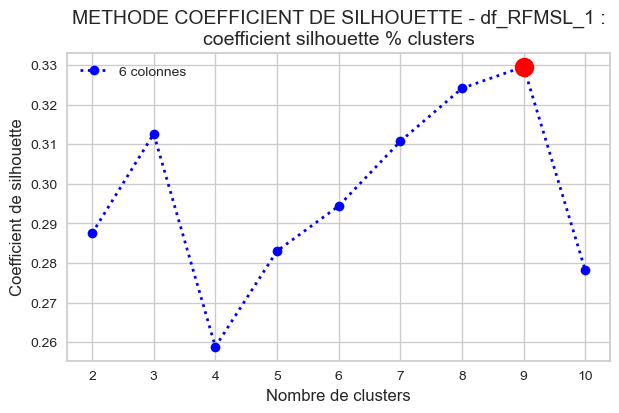

In [83]:
kmeans_silhouette_recherche_k_optimal(df_in            = df_RFMSL_1,
                                      key_in           = 'df_RFMSL_1',
                                      kmeans_kwargs_in = kmeans_kwargs_1,
                                      intervalle_k_in  = range(2, 11))     # 15 min

For n_clusters = 2 The average silhouette_score is : 0.2874853518714268
For n_clusters = 3 The average silhouette_score is : 0.31260305807844635
For n_clusters = 4 The average silhouette_score is : 0.25886827990626626
For n_clusters = 5 The average silhouette_score is : 0.28302279452805307
For n_clusters = 6 The average silhouette_score is : 0.2943888809241507
For n_clusters = 7 The average silhouette_score is : 0.310716896056924
For n_clusters = 8 The average silhouette_score is : 0.3241052710313635
For n_clusters = 9 The average silhouette_score is : 0.3295505220708976


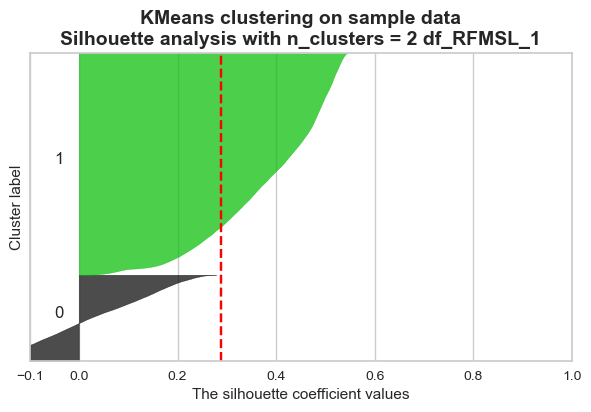

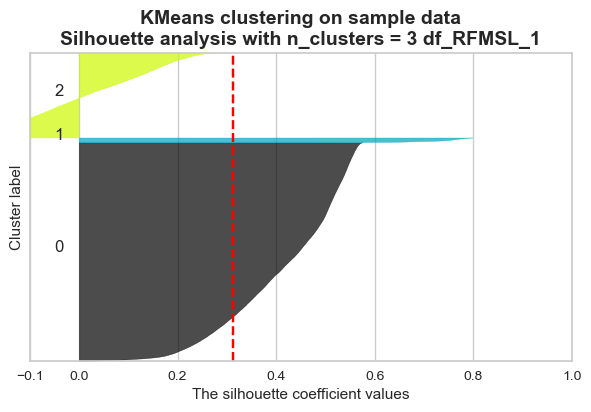

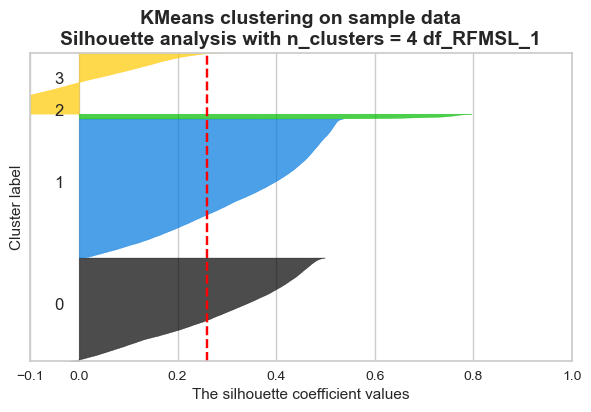

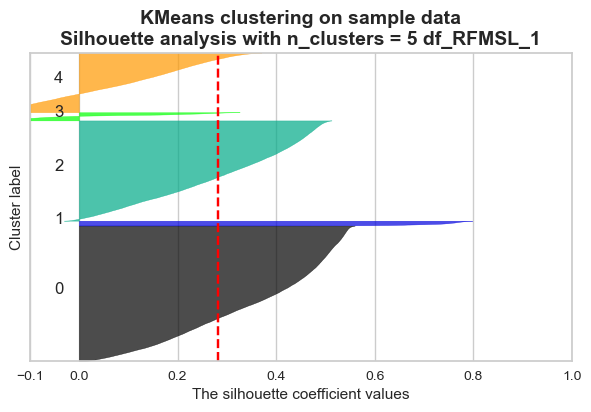

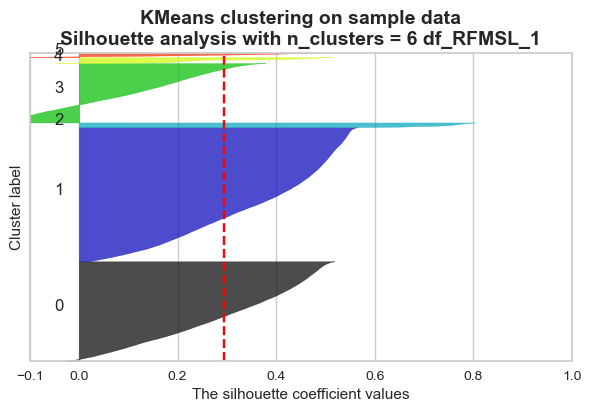

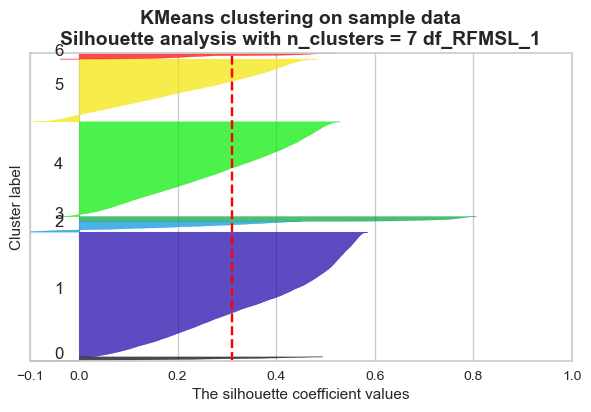

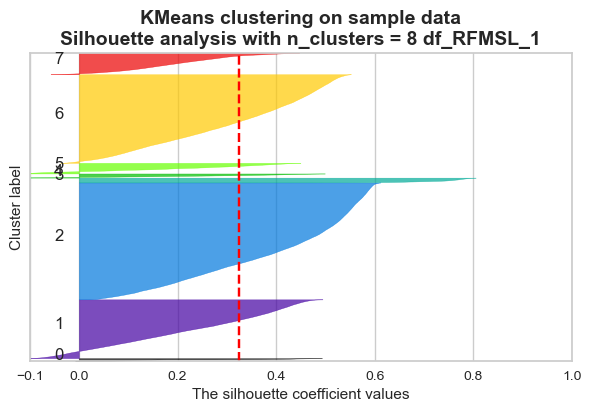

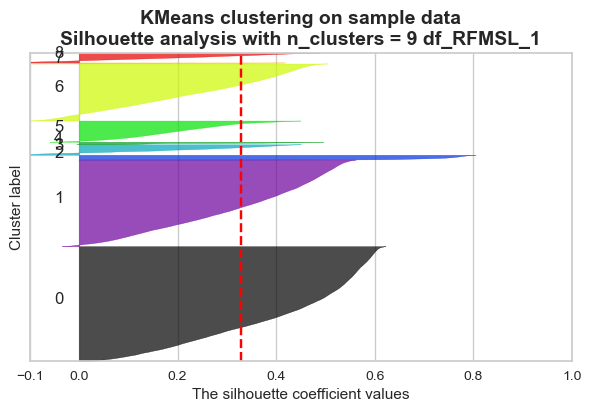

In [84]:
kmeans_silhouette_vizualizer(df_in            = df_RFMSL_1,
                             key_in           = 'df_RFMSL_1',
                             kmeans_kwargs_in = kmeans_kwargs_1,
                             intervalle_k_in  = range(2, 10))    # 23 min

# 2.3. K-MEANS AVEC LE NOMBRE DE CLUSTERS K OPTIMAL (DONNEES NORMALISEES)

In [ ]:
# Le sous-dataframe final (i.e. avec des clusters) est df_RFMSL_1.
#
# Numéro colonnes df_RFMSL_1 :
# 1 : 'dernier_achat_recence' ........................................... dict_recence['DA_sum']
# 2 : 'dernier_achat_nb_articles' ....................................... dict_frequence['DA_sum']
# 3 : 'montant_sum' ..................................................... dict_monetaire['sum']
# 4 : 'is_payment_type_debit_card' ...................................... dict_monetaire['bool']
# 5 : 'review_delta_client_jour_mean' ................................... dict_satisfaction['mean']
# 6 : 'dernier_achat_order_delta_livraison_transporteur_jour_sum' ....... dict_livraison['DA_sum']

In [85]:
print('df_RFMSL_1 ---->', len(df_RFMSL_1.columns), 'colonnes :\n', df_RFMSL_1.columns)

df_RFMSL_1 ----> 6 colonnes :
 Index(['dernier_achat_recence', 'dernier_achat_nb_articles', 'montant_sum',
       'is_payment_type_debit_card', 'review_delta_client_jour_mean',
       'dernier_achat_order_delta_livraison_transporteur_jour_sum'],
      dtype='object')


In [91]:
liste_123 = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'montant_sum'] # 123
liste_124 = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'is_payment_type_debit_card'] # 124
liste_125 = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'review_delta_client_jour_mean'] # 125
liste_126 = ['dernier_achat_recence', 'dernier_achat_nb_articles',
             'dernier_achat_order_delta_livraison_transporteur_jour_sum'] # 126

liste_134 = ['dernier_achat_recence', 'montant_sum', 'is_payment_type_debit_card'] # 134
liste_135 = ['dernier_achat_recence', 'montant_sum', 'review_delta_client_jour_mean'] # 135
liste_136 = ['dernier_achat_recence', 'montant_sum', 'dernier_achat_order_delta_livraison_transporteur_jour_sum'] # 136

liste_145 = ['dernier_achat_recence', 'is_payment_type_debit_card', 'review_delta_client_jour_mean'] # 145
liste_146 = ['dernier_achat_recence', 'is_payment_type_debit_card', 
             'dernier_achat_order_delta_livraison_transporteur_jour_sum'] # 146

liste_156 = ['dernier_achat_recence', 'review_delta_client_jour_mean', 
             'dernier_achat_order_delta_livraison_transporteur_jour_sum'] # 156
liste_165 = ['dernier_achat_recence', 'dernier_achat_order_delta_livraison_transporteur_jour_sum', 
             'review_delta_client_jour_mean']

liste_634 = ['dernier_achat_order_delta_livraison_transporteur_jour_sum', 'montant_sum', 'is_payment_type_debit_card']
liste_346 = ['montant_sum', 'is_payment_type_debit_card', 'dernier_achat_order_delta_livraison_transporteur_jour_sum']

liste_456 = ['is_payment_type_debit_card', 'review_delta_client_jour_mean', 
             'dernier_achat_order_delta_livraison_transporteur_jour_sum'] # 456

liste_452 = ['is_payment_type_debit_card', 'review_delta_client_jour_mean', 'dernier_achat_nb_articles'] # 452

liste_453 = ['is_payment_type_debit_card', 'review_delta_client_jour_mean', 'montant_sum'] # 453

In [92]:
##################################################
# Bilan du nombre de clusters suivant la méthode #
##################################################
print('Nombre de clusters pour df_RFMSL_1 :\n',
      '\t- méthode elbow\t\t:', dict_elbow_kl['df_RFMSL_1'].elbow, '\n',
      '\t- méthode silhouette\t:', dict_silhouette_best_k['df_RFMSL_1'])

# Dans la visualisation des clusters de la méthode silhouette (méthode kmeans_silhouette_vizualizer), 
# il semble y avoir 3-4 clusters principaux (i.e. taille importante).

Nombre de clusters pour df_RFMSL_1 :
 	- méthode elbow		: 5 
 	- méthode silhouette	: 9


# 2.3.1. ESSAI POUR 4 A 6 CLUSTERS

key_in = df_RFMSL_1 
 	- 4 clusters
 	- 3 colonnes = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'review_delta_client_jour_mean']
	- nb_subplots = 3 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = dernier_achat_nb_articles
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = review_delta_client_jour_mean
num_ligne = 3 : col_1 = dernier_achat_nb_articles , col_2 = review_delta_client_jour_mean

dict_nb_figure = {'dernier_achat_recence': 2, 'dernier_achat_nb_articles': 2, 'review_delta_client_jour_mean': 2}


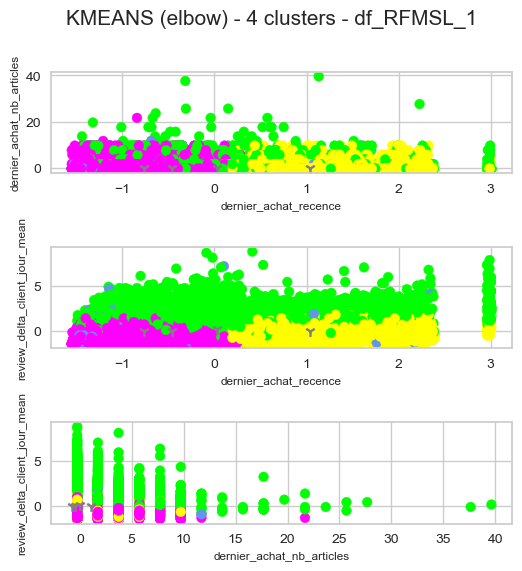


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

key_in = df_RFMSL_1 
 	- 5 clusters
 	- 3 colonnes = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'review_delta_client_jour_mean']
	- nb_subplots = 3 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = dernier_achat_nb_articles
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = review_delta_client_jour_mean
num_ligne = 3 : col_1 = dernier_achat_nb_articles , col_2 = review_delta_client_jour_mean

dict_nb_figure = {'dernier_achat_recence': 2, 'dernier_achat_nb_articles': 2, 'review_delta_client_jour_mean': 2}


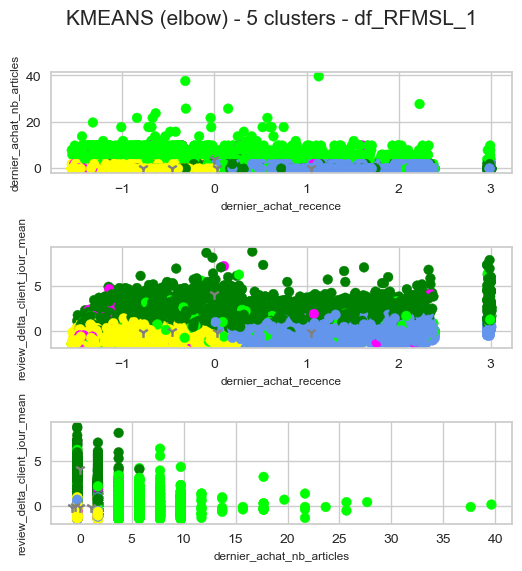


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 

key_in = df_RFMSL_1 
 	- 6 clusters
 	- 3 colonnes = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'review_delta_client_jour_mean']
	- nb_subplots = 3 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = dernier_achat_nb_articles
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = review_delta_client_jour_mean
num_ligne = 3 : col_1 = dernier_achat_nb_articles , col_2 = review_delta_client_jour_mean

dict_nb_figure = {'dernier_achat_recence': 2, 'dernier_achat_nb_articles': 2, 'review_delta_client_jour_mean': 2}


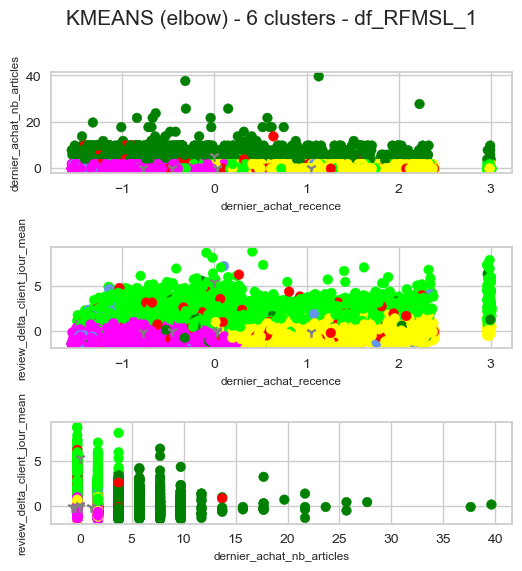


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 



In [93]:
for n_clusters in [4, 5, 6]:
    kmeans_elbow_k_optimal(df_in             = df_RFMSL_1,
                           key_in            = 'df_RFMSL_1', 
                           n_clusters_in     = n_clusters,       # nb clusters variable
                           kmeans_kwargs_in  = kmeans_kwargs_1,
                           liste_colonnes_in = liste_125)
    
# => choix de rester avec 4 clusters (1 des clusters est + petit que les autres).

# 2.3.2. IDENTIFICATION CLUSTERS

In [ ]:
# https://builtin.com/data-science/data-clustering-python

In [ ]:
# Couleurs des 4 clusters :
# 'yellow', 'fuchsia', 'cornflowerblue', 'lime'

key_in = df_RFMSL_1 
 	- 4 clusters
 	- 3 colonnes = ['dernier_achat_recence', 'dernier_achat_nb_articles', 'review_delta_client_jour_mean']
	- nb_subplots = 3 

num_ligne = 1 : col_1 = dernier_achat_recence , col_2 = dernier_achat_nb_articles
num_ligne = 2 : col_1 = dernier_achat_recence , col_2 = review_delta_client_jour_mean
num_ligne = 3 : col_1 = dernier_achat_nb_articles , col_2 = review_delta_client_jour_mean

dict_nb_figure = {'dernier_achat_recence': 2, 'dernier_achat_nb_articles': 2, 'review_delta_client_jour_mean': 2}


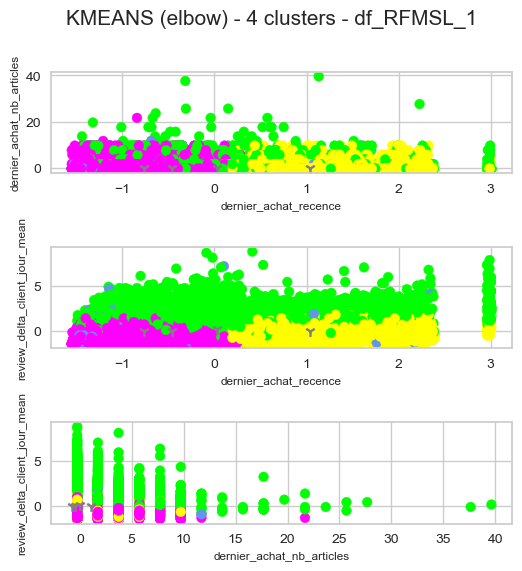


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 



In [94]:
##################################################################################################
# Colonnes 'dernier_achat_recence', 'dernier_achat_nb_articles', 'review_delta_client_jour_mean' #
##################################################################################################
kmeans_elbow_k_optimal(df_in             = df_RFMSL_1,
                       key_in            = 'df_RFMSL_1', 
                       n_clusters_in     = 4,                # 4 clusters
                       kmeans_kwargs_in  = kmeans_kwargs_1,
                       liste_colonnes_in = liste_125)

In [ ]:
# ANALYSE DES CLUSTERS (liste_125) :

##############################
#      cluster 'yellow'      #
##############################
# - dernier achat récent.
# - avis client rapide.
# - nombre d’articles faible à moyen dans le dernier achat. 

##############################
#      cluster 'fuchsia'     #
##############################
# - dernier achat ancien.
# - avis client rapide.
# - nombre d’articles faible à moyen dans le dernier achat. 

##############################
#  cluster 'cornflowerblue'  #
##############################
# - clients peu nombreux.
# - dernier achat ancien à récent.
# - avis client rapide à tardif.
# - nombre d'articles du dernier achat moyen.

##############################
#       cluster 'lime'       #
##############################
# - dernier achat ancien à récent.
# - avis client tardif.
# - nombre d’articles faible à important dans le dernier achat (faible et moyen fortement représentés).

key_in = df_RFMSL_1 
 	- 4 clusters
 	- 3 colonnes = ['montant_sum', 'is_payment_type_debit_card', 'dernier_achat_order_delta_livraison_transporteur_jour_sum']
	- nb_subplots = 3 

num_ligne = 1 : col_1 = montant_sum , col_2 = is_payment_type_debit_card
num_ligne = 2 : col_1 = montant_sum , col_2 = dernier_achat_order_delta_livraison_transporteur_jour_sum
num_ligne = 3 : col_1 = is_payment_type_debit_card , col_2 = dernier_achat_order_delta_livraison_transporteur_jour_sum

dict_nb_figure = {'montant_sum': 2, 'is_payment_type_debit_card': 2, 'dernier_achat_order_delta_livraison_transporteur_jour_sum': 2}


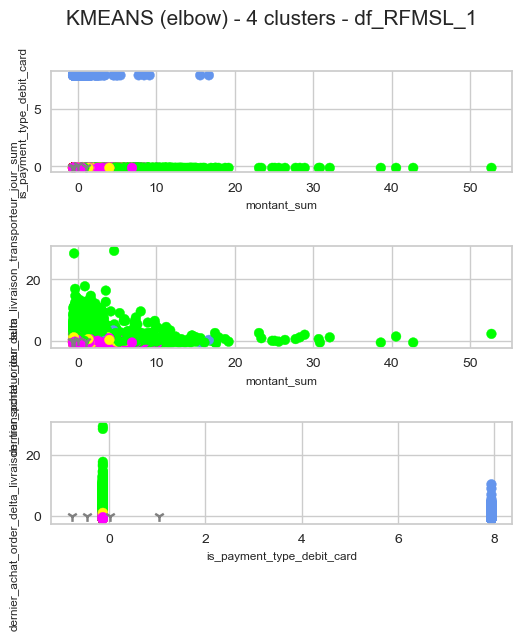


 @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ 



In [95]:
#####################################################################################################################
# Colonnes 'montant_sum', 'is_payment_type_debit_card', 'dernier_achat_order_delta_livraison_transporteur_jour_sum' #
#####################################################################################################################
kmeans_elbow_k_optimal(df_in             = df_RFMSL_1,
                       key_in            = 'df_RFMSL_1', 
                       n_clusters_in     = 4,                # 4 clusters
                       kmeans_kwargs_in  = kmeans_kwargs_1,
                       liste_colonnes_in = liste_346)

In [ ]:
# ANALYSE DES CLUSTERS (liste_346) :
# Différence carte de débit / crédit (https://www.creditmutuel.fr/cmne/fr/le-mag/differences-carte-credit-debit.html) :
#   - Carte de débit = carte à débit immédiat.
#   - Carte de crédit = carte à débit différé.
    
##############################
#      cluster 'yellow'      #
##############################
# - paiement en boléto / voucher / carte de crédit (i.e. carte à débit différé).
# - montant dépensé faible.
# - temps de transport du dernier achat rapide. 

##############################
#      cluster 'fuchsia'     #
##############################
# - paiement en boléto / voucher / carte de crédit (i.e. carte à débit différé).
# - montant dépensé faible.
# - temps de transport du dernier achat rapide. 
 

##############################
#  cluster 'cornflowerblue'  #
##############################
# - paiement en carte de débit (i.e. carte à débit immédiat).
# - montant dépensé faible à moyen.
# - temps de transport du dernier achat rapide à moyennement long.

##############################
#       cluster 'lime'       #
##############################
# - paiement en boléto / voucher / carte de crédit (i.e. carte à débit différé).
# - montant dépensé faible à fort.
# - temps de transport du dernier achat rapide à long.

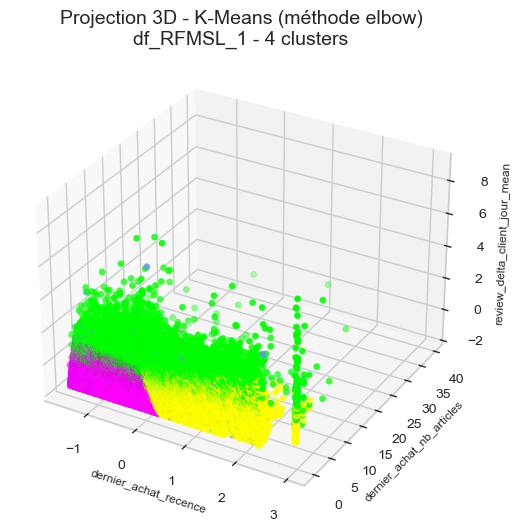

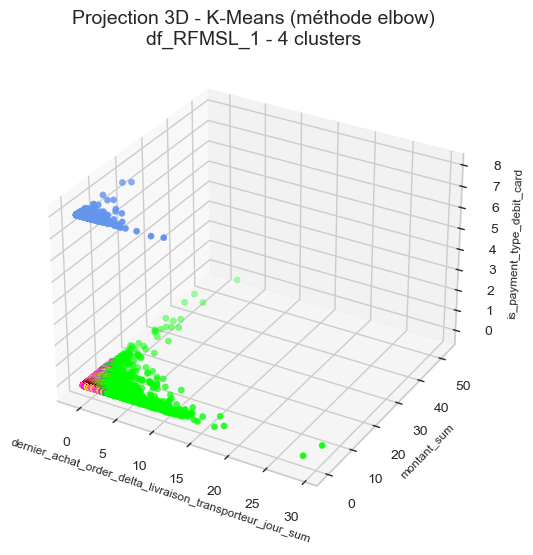

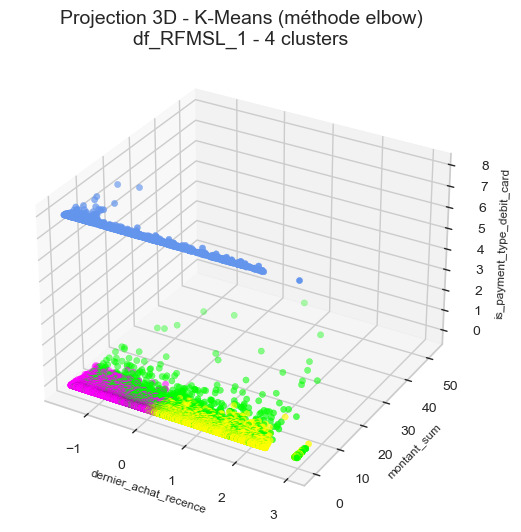

In [96]:
##################################
#   Projection 3D des colonnes   #
##################################
for liste in [liste_125, liste_634, liste_134]:
    kmeans_elbow_k_optimal_3D(df_in             = df_RFMSL_1,
                              key_in            = 'df_RFMSL_1',
                              n_clusters_in     = 4,               # 4 clusters
                              kmeans_kwargs_in  = kmeans_kwargs_1,
                              liste_colonnes_in = liste)
    print('\n')

In [97]:
#########################################################
#   ENREGISTREMENT DONNEES NETTOYEES DANS UN FICHIER    #
#########################################################
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html
df_RFMSL_1.to_csv(C_DATASET_CLEANED + 'data_customers_RFMSL_1.csv', 
                  sep = '\t', header = True, index = False)

# 2.4. K-MEANS AVEC LE NOMBRE DE CLUSTERS K OPTIMAL (DONNEES REDUITES)

In [ ]:
###############################################
#                X_norm_tsne                  #
###############################################

In [101]:
print('X_norm_tsne :', X_norm_tsne.shape, '---->', len(X_norm_tsne.columns), 'colonnes :\n', X_norm_tsne.columns.tolist())


# Sous-ensemble, pour plus de lisibilité
X_norm_tsne_sample = X_norm_tsne.sample(frac = 0.2, replace = True, random_state = 1)  # ensemble = 20 % des points initiaux
print('\nX_norm_tsne_sample :', X_norm_tsne_sample.shape)

X_norm_tsne : (88771, 2) ----> 2 colonnes :
 ['TSNE_1', 'TSNE_2']

X_norm_tsne_sample : (17754, 2)


In [102]:
kmeans_elbow_recherche_k_optimal(df_in              = X_norm_tsne,
                                 df_sample_in       = X_norm_tsne_sample,
                                 key_in             = 'TSNE',
                                 kmeans_kwargs_in   = kmeans_kwargs_1,
                                 intervalle_k_in    = range(2, 11),
                                 afficher_courbe_in = False)

key_in = TSNE 
 	-  2 colonnes = ['TSNE_1', 'TSNE_2']
	- elbow (coude)		= 4 clusters
	- elbow_sample (coude)	= 4 clusters


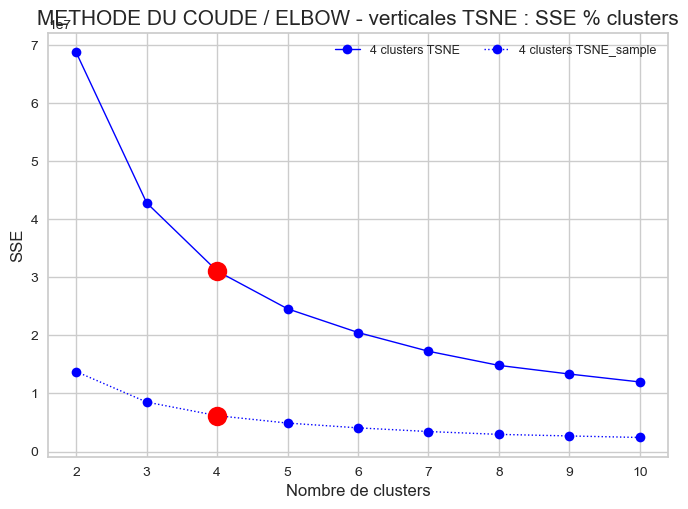

In [103]:
# Synthèse des courbes elbow pour la verticale RFM
kmeans_elbow_recherche_k_optimal_synthese(intervalle_k_in   = range(2, 11), 
                                          type_verticale_in = 'TSNE', 
                                          liste_key_in      = ['TSNE'])

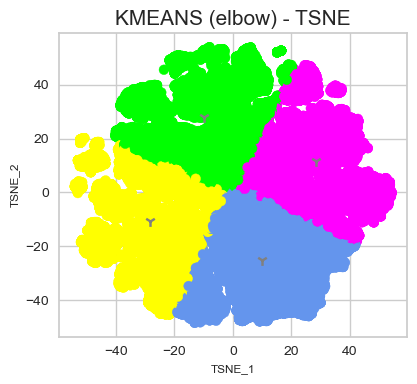

In [105]:
# Couleurs : https://matplotlib.org/stable/gallery/color/named_colors.html
colormap = np.array(['yellow', 'fuchsia', 'cornflowerblue', 'lime', 'green'])  # couleurs des 5 clusters
    
#df = dict_X_norm['X_norm_tsne']
df = X_norm_tsne


#################################################
#                 4 clusters                    #
#################################################
cls4 = KMeans(n_clusters = dict_elbow_kl['TSNE'].elbow, **kmeans_kwargs_1)
cls4.fit(df)


#################################################
#             Graphique en 2D                   #
#################################################
fig = plt.figure(figsize = (8, 4))   # longueur, hauteur

ax = fig.add_subplot(121)
ax.scatter(df['TSNE_1'], df['TSNE_2'], c = colormap[cls4.labels_])
# le centre du cluster est mis pour l'instant en croix grise pour mieux voir les clusters.
ax.scatter(cls4.cluster_centers_[:, 0], cls4.cluster_centers_[:, 1], 
           s = 60, marker = '1', c = 'grey')
ax.set_xlabel('TSNE_1', fontsize = 8.5)
ax.set_ylabel('TSNE_2', fontsize = 8.5)
        
plt.title('KMEANS (elbow) - TSNE', fontsize = 15)

fig.tight_layout()
plt.show()  

# 3. CLUSTERING ALGORITHME DBSCAN

In [ ]:
# https://www.reneshbedre.com/blog/dbscan-python.html
# https://machinelearningknowledge.ai/tutorial-for-dbscan-clustering-in-python-sklearn/

# 3.1. COMPUTE REQUIRED PARAMETERS FOR DBSCAN CLUSTERING

In [106]:
# check the shape of dataset
print('df_RFMSL_1 shape\t= ', df_RFMSL_1.shape)
print('df_RFMSL_1_sample shape\t= ', df_RFMSL_1_sample.shape)

df_RFMSL_1 shape	=  (88771, 6)
df_RFMSL_1_sample shape	=  (17754, 6)


In [ ]:
# 2 paramètres de calcul sont requis pour le clustering DBSCAN : 
#   1) minPts = the minimum number of data points in a given ε-neighborhood to form clusters.
#   2) ε (appelé epsilon) ou eps = the radius of neighborhoods for a given data point p.

In [107]:
########################################
# 1) minPts = 2 * number of dimensions #
########################################
def parameter_min_sample(df_in):
    
    nb_colonnes = len(df_in.columns)
    minPts = 2 * nb_colonnes
    
    return(minPts)

In [108]:
minPts = parameter_min_sample(df_in = df_RFMSL_1)
print('minPts\t\t=', minPts)
      
minPts_sample = parameter_min_sample(df_in = df_RFMSL_1_sample)
print('minPts_sample\t=', minPts_sample)

minPts		= 12
minPts_sample	= 12


In [109]:
########################################
# 2) ε parameter                       #
########################################
# The ε parameter is difficult to set and depends on the distance function. It should be as small as possible.
# To determine the optimal ε parameter, we will compute the k-nearest neighbor (kNN) distances (average distance
# of every data point to its k-nearest neighbors) of an input dataset using the k-nearest neighbor method (unsupervised 
# nearest neighbors learning). 

# NearestNeighbors function requires n_neighbors (number of neighbors) parameter, which can be same as the minPts value.

# n_neighbors = minPts + 1 as kneighbors function returns distance of point to itself (i.e. first column will be zeros)
def parameter_epsilon(df_in, minPts_in):
    
    ###############################
    #      NearestNeighbors       #
    ###############################
    nbrs = NearestNeighbors(n_neighbors = minPts_in + 1).fit(df_in)
    
    # Find the k-neighbors of a point
    neigh_dist, neigh_ind = nbrs.kneighbors(df_in)
    
    # sort the neighbor distances (lengths to points) in ascending order
    # axis = 0 represents sort along first axis i.e. sort along row
    sort_neigh_dist = np.sort(neigh_dist, axis = 0)

    # Now, get the sorted kth column (distances with kth neighbors) and plot the kNN distance plot
    k_dist = sort_neigh_dist[:, minPts_in]


    
    ###############################
    #     Point coude / genou     #
    ###############################
    # Le point 'genou' ou 'coude' (valeur seuil avec un changement brusque) de la courbe aide à trouver la valeur 
    # optimale de ε.
    # Les points sous le point de coude appartiennent à un cluster, et les points au-dessus du point de coude sont du bruit 
    # ou des valeurs aberrantes (les points de bruit auront une distance kNN plus élevée). 
    kneedle = KneeLocator(x         = range(1, len(neigh_dist) + 1), 
                          y         = k_dist, 
                          S         = 1.0, 
                          curve     = 'concave', 
                          direction = 'increasing', 
                          online    = True)

    # get the estimate of knee / elbow point
    eps = kneedle.knee_y
    print('eps = knee / elbow point =', eps)


    
    ###############################
    #          Affichage          #
    ###############################
    # Distance plot
    kneedle.plot_knee()   
    plt.show()
    
    return eps

eps = knee / elbow point = 3.30936174428279


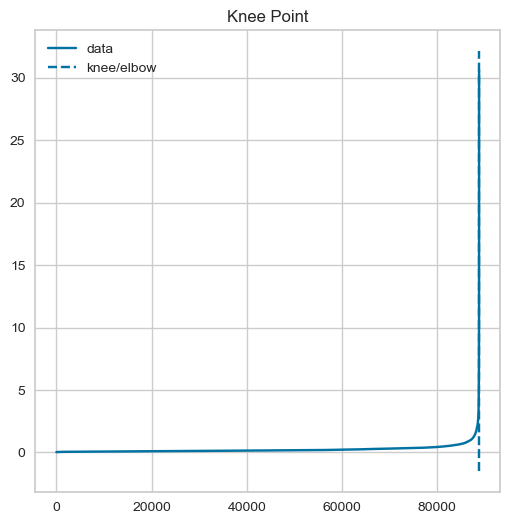

In [110]:
eps = parameter_epsilon(df_in     = df_RFMSL_1, 
                        minPts_in = minPts)

eps = knee / elbow point = 12.1757226897302


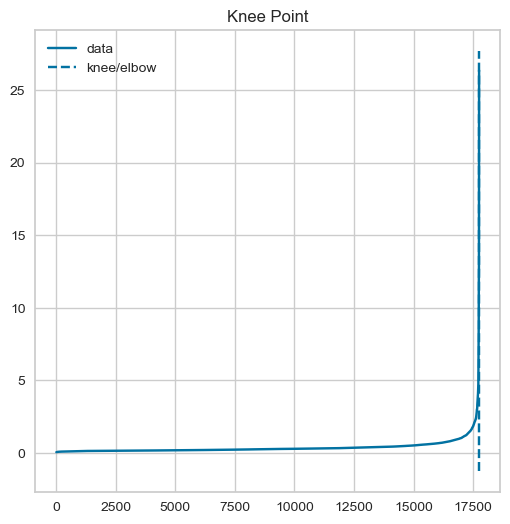

In [111]:
eps_sample = parameter_epsilon(df_in     = df_RFMSL_1_sample, 
                               minPts_in = minPts_sample)

In [112]:
print('eps\t\t=', eps)
print('eps_sample\t=', eps_sample)

eps		= 3.30936174428279
eps_sample	= 12.1757226897302


# 3.2. COMPUTE DBSCAN CLUSTERING & VIZUALISATION

In [113]:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
######################################
#          DBSCAN algorithm          #
######################################
def dbscan_algorithm(df_in, eps_in, min_samples_in):
    
    print('eps_in =', round(eps_in, 3), ', min_samples_in =', min_samples_in, '\n')

    db = DBSCAN(eps = eps_in, min_samples = min_samples_in).fit(df_in)

    # cluster labels (type = ndarray)
    labels = db.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    # (-1 value represents noisy points could not assigned to any cluster.)
    # >>>>>>> nombre de clusters
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    # >>>>>>> nombre de points de bruit
    n_noise    = list(labels).count(-1)

    print('n_clusters\t= %d' % n_clusters,
          '\nn_noise\t\t= %d' % n_noise)

    # CLuster size
    # >>>>>>> affichage par importance
    print('\ntaille clusters :\n', Counter(labels))
    
#    # >>>>>>> affichage par valeur unique
#    unique, counts = np.unique(labels, return_counts=True)
#    result = np.column_stack((unique, counts)) 
#    print('\n  unique counts\n', result)
    
    return db

In [114]:
######################################
#        DBSCAN vizualization        #
######################################
def dbscan_visualization(df_in, dbscan_in, colonne_1_in, colonne_2_in):
        
    p = sns.scatterplot(data    = df_in, 
                        x       = colonne_1_in, 
                        y       = colonne_2_in, 
                        hue     = dbscan_in.labels_, 
                        legend  = 'full', 
                        palette = 'deep')

    sns.move_legend(p, 'upper right', bbox_to_anchor = (1.17, 1.), title = 'Clusters')
    plt.show()

# 3.2.1. ALGORITHME DBSCAN SUR DATAFRAME df_RFMSL_1_sample

In [ ]:
###############################################
#       Paramètres par défaut de DBSCAN       #
###############################################

In [115]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
# eps_in = 0.5 (valeur par défaut), min_sample_in = 5 (valeur par défaut)
dbscan_1_sample = dbscan_algorithm(df_in = df_RFMSL_1_sample, eps_in = 0.5, min_samples_in = 5)

eps_in = 0.5 , min_samples_in = 5 

n_clusters	= 24 
n_noise		= 1271

taille clusters :
 Counter({0: 15189, -1: 1271, 1: 900, 7: 150, 4: 81, 6: 27, 2: 22, 5: 12, 17: 9, 13: 8, 19: 8, 12: 7, 15: 7, 18: 7, 14: 6, 9: 6, 11: 6, 20: 6, 8: 5, 10: 5, 16: 5, 23: 5, 22: 5, 21: 4, 3: 3})


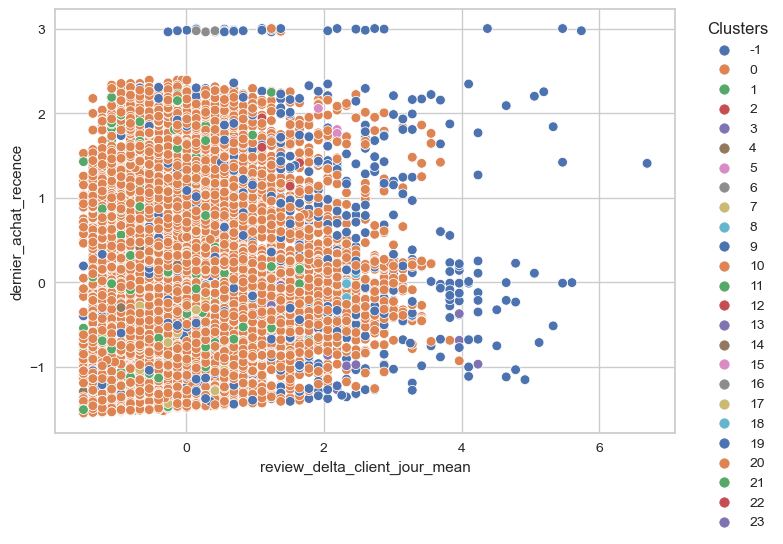

In [116]:
dbscan_visualization(df_in        = df_RFMSL_1_sample, 
                     dbscan_in    = dbscan_1_sample, 
                     colonne_1_in = 'review_delta_client_jour_mean', 
                     colonne_2_in = 'dernier_achat_recence')

In [ ]:
###############################################
#        Paramètres optimaux calculés         #
###############################################

In [117]:
dbscan_2_sample = dbscan_algorithm(df_in = df_RFMSL_1_sample, eps_in = eps_sample, min_samples_in = minPts_sample)
# => 1 cluster unique.

eps_in = 12.176 , min_samples_in = 12 

n_clusters	= 1 
n_noise		= 1

taille clusters :
 Counter({0: 17753, -1: 1})


# 3.2.2. ALGORITHME DBSCAN SUR DATAFRAME df_RFMSL_1

In [ ]:
###############################################
#       Paramètres par défaut de DBSCAN       #
###############################################

In [118]:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html
# eps_in = 0.5 (valeur par défaut), min_sample_in = 5 (valeur par défaut)
dbscan_1 = dbscan_algorithm(df_in = df_RFMSL_1, eps_in = 0.5, min_samples_in = 5)

eps_in = 0.5 , min_samples_in = 5 

n_clusters	= 55 
n_noise		= 2709

taille clusters :
 Counter({0: 78285, 1: 5314, -1: 2709, 9: 1123, 6: 698, 10: 162, 14: 102, 18: 33, 2: 23, 5: 21, 19: 20, 12: 19, 22: 16, 8: 15, 17: 12, 21: 10, 31: 9, 16: 8, 28: 8, 53: 8, 11: 7, 13: 7, 26: 7, 24: 7, 20: 7, 3: 6, 48: 6, 33: 6, 25: 6, 45: 6, 7: 5, 40: 5, 34: 5, 51: 5, 41: 5, 39: 5, 49: 5, 42: 5, 30: 5, 32: 5, 54: 5, 35: 5, 37: 5, 47: 5, 15: 4, 4: 4, 23: 4, 27: 4, 29: 4, 46: 4, 50: 4, 44: 3, 52: 3, 38: 3, 36: 2, 43: 2})


In [1]:
dbscan_visualization(df_in        = df_RFMSL_1, 
                     dbscan_in    = dbscan_1, 
                     colonne_1_in = 'review_delta_client_jour_mean', 
                     colonne_2_in = 'dernier_achat_recence')


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Graphique supprimé.

In [ ]:
###############################################
#        Paramètres optimaux calculés         #
###############################################

In [ ]:
# eps_in = 3.309, min_samples_in = 12
# ==> MemoryError

In [ ]:
#########################################################
# eps_in : augmentation % valeur par défaut (0.5)       #
#          et jusqu'à valeur optimale (3.309)           #
#########################################################

In [120]:
# eps_in = 0.6, min_sample_in = 5 (valeur par défaut)
dbscan_2 = dbscan_algorithm(df_in = df_RFMSL_1, eps_in = 0.6, min_samples_in = 5)

eps_in = 0.6 , min_samples_in = 5 

n_clusters	= 39 
n_noise		= 1954

taille clusters :
 Counter({0: 78796, 1: 5499, -1: 1954, 7: 1191, 5: 785, 8: 214, 11: 44, 12: 41, 9: 28, 13: 24, 6: 22, 16: 12, 34: 11, 18: 10, 22: 8, 28: 8, 2: 7, 10: 7, 29: 7, 17: 7, 14: 6, 19: 6, 3: 5, 15: 5, 38: 5, 27: 5, 35: 5, 23: 5, 32: 5, 31: 5, 25: 5, 20: 5, 37: 5, 24: 5, 21: 5, 36: 5, 33: 5, 4: 4, 26: 3, 30: 2})


In [2]:
dbscan_visualization(df_in        = df_RFMSL_1, 
                     dbscan_in    = dbscan_2, 
                     colonne_1_in = 'review_delta_client_jour_mean', 
                     colonne_2_in = 'dernier_achat_recence')


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Graphique supprimé.

In [122]:
# eps_in = 0.8, min_sample_in = 5 (valeur par défaut)
dbscan_3 = dbscan_algorithm(df_in = df_RFMSL_1, eps_in = 0.8, min_samples_in = 5)

eps_in = 0.8 , min_samples_in = 5 

n_clusters	= 20 
n_noise		= 1074

taille clusters :
 Counter({0: 79309, 1: 5669, 3: 1223, -1: 1074, 2: 889, 6: 298, 7: 107, 10: 75, 11: 39, 15: 21, 8: 9, 4: 8, 5: 6, 17: 6, 16: 6, 12: 6, 18: 6, 14: 6, 9: 5, 13: 5, 19: 4})


In [9]:
dbscan_visualization(df_in        = df_RFMSL_1, 
                     dbscan_in    = dbscan_3, 
                     colonne_1_in = 'review_delta_client_jour_mean', 
                     colonne_2_in = 'dernier_achat_recence')


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Graphique supprimé.

In [124]:
# eps_in = 1, min_sample_in = 5 (valeur par défaut)
dbscan_4 = dbscan_algorithm(df_in = df_RFMSL_1, eps_in = 1, min_samples_in = 5)

eps_in = 1 , min_samples_in = 5 

n_clusters	= 18 
n_noise		= 649

taille clusters :
 Counter({0: 79538, 1: 5731, 3: 1260, 2: 933, -1: 649, 6: 326, 7: 127, 8: 93, 9: 57, 4: 9, 10: 7, 11: 6, 12: 6, 15: 5, 14: 5, 17: 5, 13: 5, 16: 5, 5: 4})


In [8]:
dbscan_visualization(df_in        = df_RFMSL_1, 
                     dbscan_in    = dbscan_4, 
                     colonne_1_in = 'review_delta_client_jour_mean', 
                     colonne_2_in = 'dernier_achat_recence')


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Graphique supprimé.

In [ ]:
# eps_in = 2, min_sample_in = 5 (valeur par défaut)
# ==> MemoryError

In [ ]:
#########################################################
# min_samples_in : diminution % valeur optimale (12)    #
#                  et jusqu'à valeur par défaut (5)     #
#########################################################

In [126]:
# eps_in = 1, min_sample_in = 10
dbscan_5 = dbscan_algorithm(df_in = df_RFMSL_1, eps_in = 1, min_samples_in = 10)

eps_in = 1 , min_samples_in = 10 

n_clusters	= 9 
n_noise		= 938

taille clusters :
 Counter({0: 79407, 1: 5694, 3: 1253, -1: 938, 2: 903, 4: 310, 5: 112, 7: 79, 6: 54, 8: 21})


In [7]:
dbscan_visualization(df_in        = df_RFMSL_1, 
                     dbscan_in    = dbscan_5, 
                     colonne_1_in = 'review_delta_client_jour_mean', 
                     colonne_2_in = 'dernier_achat_recence')


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Graphique supprimé.

In [128]:
# eps_in = 1, min_sample_in = 8
dbscan_6 = dbscan_algorithm(df_in = df_RFMSL_1, eps_in = 1, min_samples_in = 8)

eps_in = 1 , min_samples_in = 8 

n_clusters	= 9 
n_noise		= 857

taille clusters :
 Counter({0: 79471, 1: 5701, 3: 1256, 2: 913, -1: 857, 4: 313, 5: 116, 8: 81, 7: 55, 6: 8})


In [6]:
dbscan_visualization(df_in        = df_RFMSL_1, 
                     dbscan_in    = dbscan_6, 
                     colonne_1_in = 'review_delta_client_jour_mean', 
                     colonne_2_in = 'dernier_achat_recence')


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Graphique supprimé.

In [130]:
# eps_in = 1, min_sample_in = 5
dbscan_7 = dbscan_algorithm(df_in = df_RFMSL_1, eps_in = 1, min_samples_in = 5)

eps_in = 1 , min_samples_in = 5 

n_clusters	= 18 
n_noise		= 649

taille clusters :
 Counter({0: 79538, 1: 5731, 3: 1260, 2: 933, -1: 649, 6: 326, 7: 127, 8: 93, 9: 57, 4: 9, 10: 7, 11: 6, 12: 6, 15: 5, 14: 5, 17: 5, 13: 5, 16: 5, 5: 4})


In [3]:
dbscan_visualization(df_in        = df_RFMSL_1, 
                     dbscan_in    = dbscan_7, 
                     colonne_1_in = 'review_delta_client_jour_mean', 
                     colonne_2_in = 'dernier_achat_recence')


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Graphique supprimé.

In [132]:
# eps_in = 1, min_sample_in = 4
dbscan_8 = dbscan_algorithm(df_in = df_RFMSL_1, eps_in = 1, min_samples_in = 4)

eps_in = 1 , min_samples_in = 4 

n_clusters	= 21 
n_noise		= 583

taille clusters :
 Counter({0: 79555, 1: 5739, 4: 1261, 2: 940, -1: 583, 6: 327, 8: 129, 9: 97, 10: 62, 15: 11, 5: 10, 13: 8, 11: 7, 16: 7, 12: 6, 3: 5, 17: 5, 14: 4, 7: 4, 20: 4, 18: 4, 19: 3})


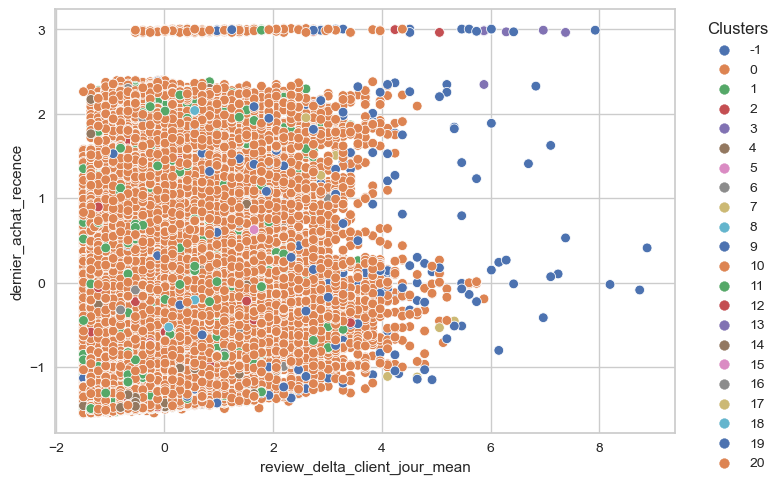

In [133]:
dbscan_visualization(df_in        = df_RFMSL_1, 
                     dbscan_in    = dbscan_8, 
                     colonne_1_in = 'review_delta_client_jour_mean', 
                     colonne_2_in = 'dernier_achat_recence')

In [ ]:
#########################################################
# min_samples_in : augmentation % valeur optimale (12)  #
#########################################################

In [134]:
# eps_in = 1, min_sample_in = 20
dbscan_9 = dbscan_algorithm(df_in = df_RFMSL_1, eps_in = 1, min_samples_in = 20)

eps_in = 1 , min_samples_in = 20 

n_clusters	= 8 
n_noise		= 1331

taille clusters :
 Counter({0: 79249, 1: 5645, -1: 1331, 2: 1223, 3: 869, 4: 277, 5: 77, 6: 60, 7: 40})


In [4]:
dbscan_visualization(df_in        = df_RFMSL_1, 
                     dbscan_in    = dbscan_9, 
                     colonne_1_in = 'review_delta_client_jour_mean', 
                     colonne_2_in = 'dernier_achat_recence')


# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Graphique supprimé.

# 3.2.3. ANALYSE PARAMETRES DBSCAN

In [ ]:
# DBSCAN df_RFMSL_1_sample :
# | eps_in                  | min_samples_in        | n_clusters | n_noise |
# |-------------------------|-----------------------|------------|---------|
# | 0.5 (valeur par défaut) | 5 (valeur par défaut) |     24     |   1271  |
# | 12.176 (optimal)        | 12 (optimal)          |      1     |      1  |

In [ ]:
# DBSCAN RFMSL_1 :
# | eps_in                   | min_samples_in          | n_clusters    |    n_noise     |
# |--------------------------|-------------------------|---------------|----------------|
# | 0.5 (valeur par défaut)  |  5 (valeur par défaut)  |     55        |      2709      |
# | 3.309 (optimal)          | 12 (optimal)            | MemoryError   | MemoryError    |
# | eps_in : augmentation % valeur par défaut (0.5) et jusqu'à valeur optimale (3.309)  |
# | 0.6                      |  5                      |      39       |      1954      |
# | 0.8                      |  5                      |      20       |      1074      |
# | 1                        |  5                      |      18       |       649      |
# | 2                        |  5 (valeur par défaut)  | MemoryError   |  MemoryError   |
# | min_samples_in : diminution % valeur optimale (12) et jusqu'à valeur par défaut (5) |   
# | 1                        | 10                      |       9       |       938      |
# | 1                        |  8                      |       9       |       857      |
# | 1                        |  5                      |      18       |       649      |
# | 1                        |  4                      |      21       |       583      | <= OPTIMAL
# | min_samples_in : augmentation % valeur optimale (12)                                |
# | 1                        | 20                      |       8       |      1331      |

In [ ]:
# K-Means est l'algorithme optimal pour ce dataset.

In [136]:
df_RFMSL_1.columns

Index(['dernier_achat_recence', 'dernier_achat_nb_articles', 'montant_sum',
       'is_payment_type_debit_card', 'review_delta_client_jour_mean',
       'dernier_achat_order_delta_livraison_transporteur_jour_sum'],
      dtype='object')

In [10]:
for index, row in df_RFMSL_1.iterrows():
    print('index =', index, 
          ', dernier_achat_recence =', row['dernier_achat_recence'],
          ', dernier_achat_nb_articles =', row['dernier_achat_nb_articles'],
          '\t, montant_sum  =', row['montant_sum'],
          '\t, dernier_achat_order_delta_livraison_transporteur_jour_sum  =',
          row['dernier_achat_order_delta_livraison_transporteur_jour_sum'])
 
    
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# >>>   Extrait traces pour github :   >>>
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
# Traces supprimées.
# index = 0 , dernier_achat_recence = 1.5330260454416875 , dernier_achat_nb_articles = -0.2455106642990177, 
# montant_sum  = -0.09747191279749634 	, dernier_achat_order_delta_livraison_transporteur_jour_sum  = 1.0712329987355325
# index = 1 , dernier_achat_recence = 0.3714559882479767 , dernier_achat_nb_articles = 1.7482892790262117, 
# montant_sum  = 0.40586072789311606 	, dernier_achat_order_delta_livraison_transporteur_jour_sum  = 2.768009491039256
# index = 2 , dernier_achat_recence = 1.5920889297057745 , dernier_achat_nb_articles = -0.2455106642990177, 
# montant_sum  = -0.12191425497981913 	, dernier_achat_order_delta_livraison_transporteur_jour_sum  = 2.4852134089886357
# index = 3 , dernier_achat_recence = -0.19292268360885453 , dernier_achat_nb_articles = -0.2455106642990177,
# montant_sum  = -0.1337449733204643 	, dernier_achat_order_delta_livraison_transporteur_jour_sum  = 3.616397737191118
# index = 4 , dernier_achat_recence = 1.8874033510262094 , dernier_achat_nb_articles = -0.2455106642990177, 
# montant_sum  = -0.11629173537238396 	, dernier_achat_order_delta_livraison_transporteur_jour_sum  = 0.5056408346342911

# [...]